# Tech Challenge - Fase 4 - Análise de Negócios

## Introdução

O preço do petróleo é um dos principais indicadores econômicos globais, influenciado por uma ampla gama de fatores, como eventos geopolíticos, crises econômicas e oscilações na demanda global por energia. Essa volatilidade apresenta desafios e oportunidades para empresas que dependem diretamente do mercado de petróleo, tornando a análise de dados e a previsão de preços ferramentas essenciais para a tomada de decisões estratégicas.

Neste projeto, buscamos abordar essas necessidades por meio de uma solução abrangente que combina visualização interativa de dados e previsão automatizada de preços. Para isso, utilizaremos dados históricos do preço do petróleo Brent, disponíveis no site do IPEA, organizados em duas colunas: data e preço (em dólares).

Nosso trabalho envolverá:

* **Desenvolvimento de um dashboard interativo:** Focado em storytelling, o dashboard apresentará insights relevantes sobre as flutuações no preço do petróleo, incluindo fatores externos que influenciam essas variações.
* **Criação de um modelo de Machine Learning para previsão diária dos preços:** Utilizaremos técnicas de séries temporais para modelar os dados históricos e gerar previsões.
* **Plano de deploy do modelo:** Garantiremos que a solução possa ser implementada em produção, incluindo um MVP funcional utilizando Streamlit.

A partir dessa abordagem, o objetivo é não apenas fornecer uma análise rica e informativa, mas também empoderar o cliente com ferramentas práticas para antecipar tendências e adaptar-se rapidamente às dinâmicas do mercado de petróleo.



## Coletando os dados

In [1]:
pip install statsmodels


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install pandas


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install matplotlib


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# tratamento de dados
import pandas as pd
import numpy as np

# dataviz
import seaborn as sns
import matplotlib.pyplot as plt

# ML
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, ARIMA, Naive, SeasonalNaive, SeasonalWindowAverage, WindowAverage
from statsforecast.utils import ConformalIntervals

import joblib

import warnings
warnings.filterwarnings('ignore')

c:\Users\Igor\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\core.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [6]:
dados = pd.read_csv(r'https://raw.githubusercontent.com/torvess/Tech_Challeng_FIAP_Fase_04/refs/heads/main/Dados/dados_petroleo.csv')

* Preço por barril do petróleo bruto tipo Brent. Produzido no Mar do Norte (Europa), Brent é uma classe de petróleo bruto que serve como benchmark para o preço internacional de diferentes tipos de petróleo. Neste caso, é valorado no chamado preço FOB (free on board), que não inclui despesa de frete e seguro no preço.

In [7]:
dados.head()

data  preco
0  2024-11-18  74.35
1  2024-11-15  73.45
2  2024-11-14  73.39
3  2024-11-13  72.86
4  2024-11-12  72.56

In [8]:
# conhecendo os dados
print(f'Número de linhas: {dados.shape[0]:,}')
print(f'Número de colunas: {dados.shape[1]}')

print('                                          ')

print(f'Data mínima: {dados.data.min()}')
print(f'Data máxima: {dados.data.max()}')

Número de linhas: 11,302
Número de colunas: 2
                                          
Data mínima: 1987-05-20
Data máxima: 2024-11-18


In [9]:
# nenhum valor nulo
dados.isnull().sum().sum()

0

In [10]:
dados.duplicated().sum().sum()

0

In [11]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11302 entries, 0 to 11301
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   data    11302 non-null  object 
 1   preco   11302 non-null  float64
dtypes: float64(1), object(1)
memory usage: 176.7+ KB


## Limpeza e preparação dos dados

In [12]:
dados['data'] = pd.to_datetime(dados['data'], format='%Y-%m-%d')

In [13]:
# criando um df para fazer alteraçoes
dados_petroleo = dados.copy()

In [14]:
dados_petroleo = dados_petroleo[dados_petroleo['data'] <= pd.to_datetime('2023-12-31')]

In [15]:
dados_petroleo.head(3)

data  preco
225 2023-12-29  77.69
226 2023-12-28  79.04
227 2023-12-27  80.97

## *Análise exploratória: Preço Petroleo*

### Análise Geral:

In [16]:
dias_da_semana = {
    0: 'segunda-feira',
    1: 'terça-feira',
    2: 'quarta-feira',
    3: 'quinta-feira',
    4: 'sexta-feira',
    5: 'sábado',
    6: 'domingo'
}

# criando colunas necessarias para a analise
dados_petroleo = dados_petroleo.assign(
                                    semana_ano = dados_petroleo.data.dt.isocalendar().week,
                                    dia_semana = dados_petroleo.data.dt.isocalendar().day,
                                    nome_dia = dados_petroleo.data.dt.isocalendar().day.apply(lambda x: dias_da_semana.get(x)),
                                    ano = dados_petroleo.data.dt.isocalendar().year,
                                    mes = dados_petroleo.data.dt.month,
                                    nome_mes = dados_petroleo.data.dt.strftime('%B')
                                        )

# reordenando as colunas
dados_petroleo = dados_petroleo[['ano', 'mes', 'nome_mes', 'semana_ano', 'dia_semana', 'nome_dia', 'data', 'preco']]

In [17]:
dados_petroleo.head(2)

ano  mes  nome_mes  semana_ano  dia_semana     nome_dia       data  \
225  2023   12  December          52           5       sábado 2023-12-29   
226  2023   12  December          52           4  sexta-feira 2023-12-28   

     preco  
225  77.69  
226  79.04

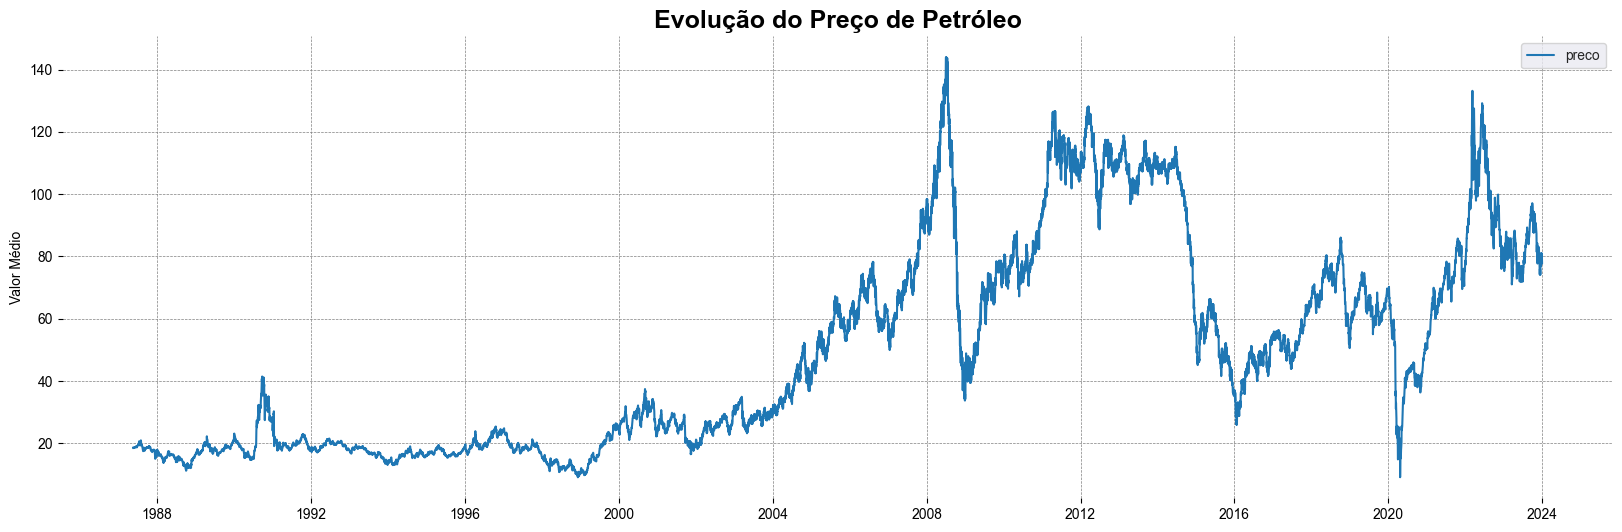

In [18]:
# tamanho da figura
fig, ax = plt.subplots(figsize=(20, 6))
# tema do fundo
sns.set_style("darkgrid")
# formatando os grids
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# removendo as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

# plotando informaçoes do grafico
ax = sns.lineplot(data=dados_petroleo.groupby('data').agg({'preco':'mean'}))
ax.set_title('Evolução do Preço de Petróleo', fontsize=18, weight='bold')
ax.set_ylabel('Valor Médio')
ax.set_xlabel('')

plt.show()

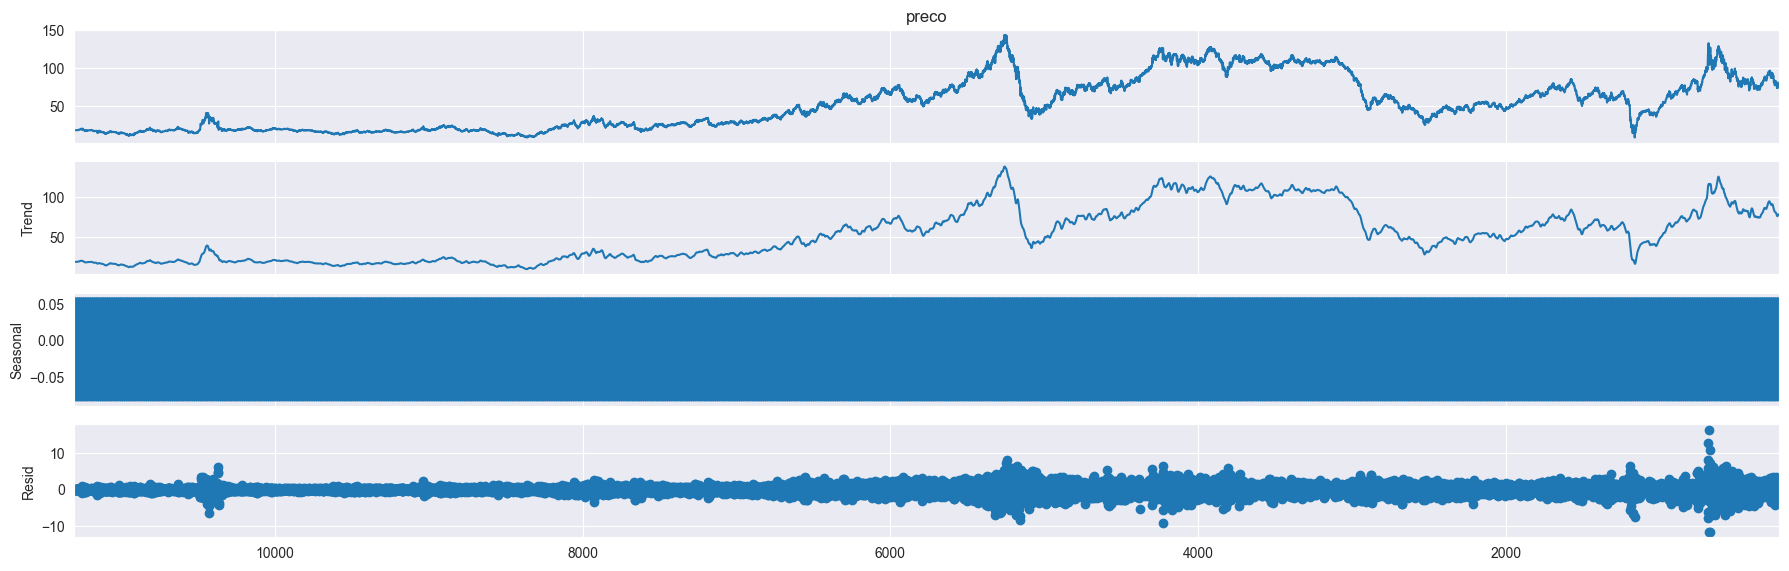

In [19]:
dados_petroleo = dados_petroleo.sort_values(by='data')
decomposicao = seasonal_decompose(dados_petroleo['preco'], model='additive', period=12)

fig = decomposicao.plot()
fig.set_size_inches(20, 6)
plt.show()

Analisando a serie no decorrer do tempo, tivemos tendências contrarias em períodos diferentes.

* Entre 2005 e 2009 forte tendência de aumento de preços seguido por uma queda brusca
* Entre 2010 e 2012 novo aumento seguido por 3 anos sem queda ou novos aumentos
* 2015 novos aumentos que seguiram até 2020
* Entre 2020 e 2023 nova tendência de aumento seguido por queda

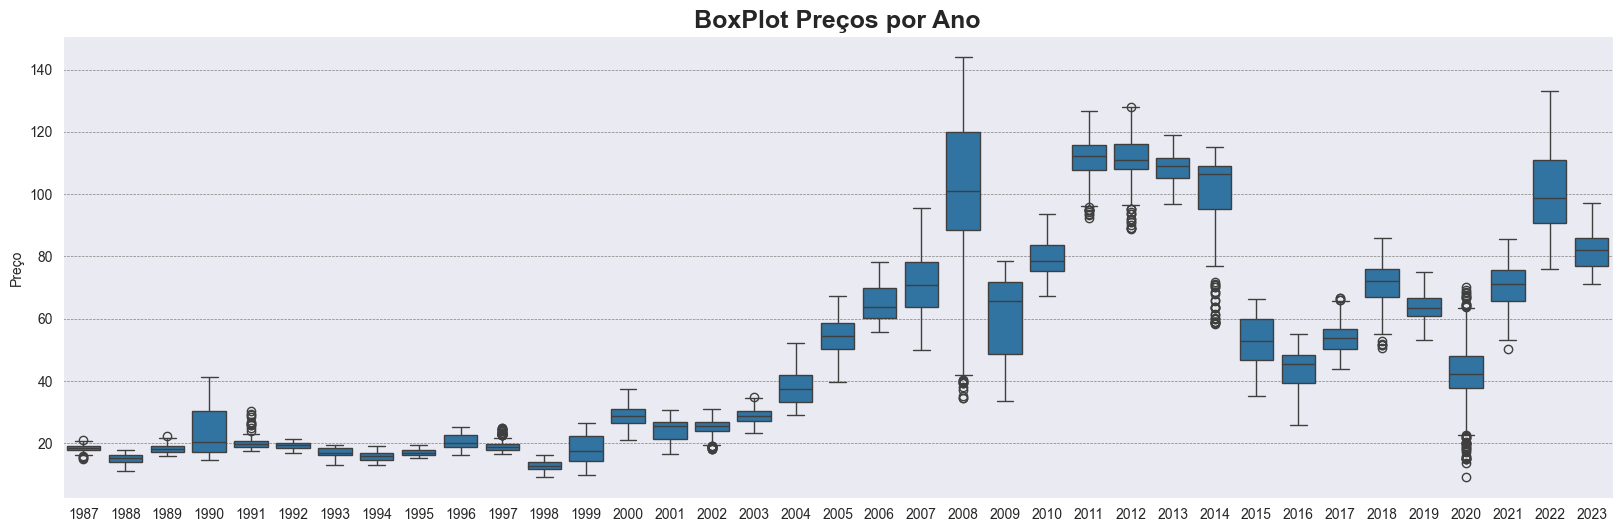

In [20]:
# tamanho da figura
fig, ax = plt.subplots(figsize=(20, 6))
# tema do fundo
sns.set_style("darkgrid")
# formatando os grids
plt.grid(color='gray', linestyle='--', linewidth=0.5)

ax = sns.boxplot(data=dados_petroleo, x='ano', y='preco')
ax.set_title('BoxPlot Preços por Ano', fontsize=18, weight='bold')
ax.set_ylabel('Preço')
ax.set_xlabel('')

plt.show()

Análise dos Preços do Barril de Petróleo Brent (1987-2023)

* 1987: O preço médio ficou abaixo de 20 dólares, com a presença de alguns outliers.

* 1988: O preço continuou abaixo de 20 dólares, levemente inferior ao ano anterior, sem outliers.

* 1989: A média do preço permaneceu abaixo de 20 dólares, com um aumento observável e alguns outliers.

* 1990: O preço médio atingiu 20 dólares, com um aumento significativo, sem outliers.

* 1991: O preço médio permaneceu em 20 dólares, com um aumento significativo e a presença de alguns outliers.

* 1992: A média manteve-se em 20 dólares, com aumento significativo, sem outliers.

* 1993: O preço ficou abaixo de 20 dólares, sem outliers.

* 1994: O preço manteve-se abaixo de 20 dólares, sem outliers.

* 1995: Continuou abaixo de 20 dólares, sem outliers.

* 1996: O preço médio subiu para 20 dólares, com um aumento significativo, sem outliers.

* 1997: O preço caiu novamente para abaixo de 20 dólares, com a presença de alguns outliers.

* 1998: Houve uma redução considerável, permanecendo abaixo de 20 dólares, sem outliers.

* 1999: A média do preço ficou abaixo de 20 dólares, mas houve um aumento prolongado, sem outliers.

* 2000: O preço mínimo foi ligeiramente acima de 20 dólares, com um aumento considerável nos preços, sem outliers.

* 2001: O preço mínimo caiu para abaixo de 20 dólares, com valores inferiores ao ano anterior, sem outliers.

* 2002: O preço médio aproximou-se de 30 dólares, semelhante ao ano anterior, mas apresentou outliers inferiores, indicando uma anomalia.

* 2003: O preço subiu, com alguns outliers superiores ao valor máximo.

* 2004: Aumento significativo, ultrapassando 40 dólares, sem outliers.

* 2005: Continuação do aumento significativo, ultrapassando 60 dólares, sem outliers.

* 2006: Aumento significativo, ultrapassando 60 dólares, sem outliers.

* 2007: Aumento significativo, ultrapassando 80 dólares, sem outliers.

* **2008: O preço teve um aumento significativo, mas houve uma grande discrepância entre a média e os valores mínimo e máximo, com outliers no valor mínimo. Sugere-se investigar as causas desse comportamento.**

* 2009: A queda drástica levou o preço do barril abaixo de 80 dólares, sem outliers.

* 2010: Pequeno aumento, ultrapassando 100 dólares, sem outliers.

* 2011: Aumento significativo, ultrapassando 120 dólares, com outliers no valor mínimo.

* 2012: Aumento significativo, ultrapassando 120 dólares, com outliers tanto no valor mínimo quanto no máximo.

* 2013: Aumento significativo, ultrapassando 60 dólares, sem outliers.

* **2014: Pequena queda no preço, com alguns outliers abaixo de 60 dólares. Recomenda-se investigar as causas.**

* **2015: Queda drástica, com valores variando entre 35 e 65 dólares, sem outliers. Investigação das causas é sugerida.**

* 2016: Pequena queda no preço, sem outliers.

* 2017: Pequeno aumento, com alguns outliers acima do valor máximo.

* 2018: Novo aumento, ultrapassando 120 dólares, com outliers no valor mínimo.

* 2019: Preço abaixo de 80 dólares, sem outliers.

* **2020: A variação foi extrema, com preços entre 10 e 70 dólares, apresentando outliers nos valores mínimo e máximo. Recomenda-se investigar as causas.**

* 2021: Aumento no preço, indicando uma normalização, com outliers insignificativos.

* 2022: Aumento considerável em relação ao ano anterior, variando entre 75 e 135 dólares, sem outliers.

* 2023: Queda no preço, variando entre 75 e 95 dólares, sem outliers.

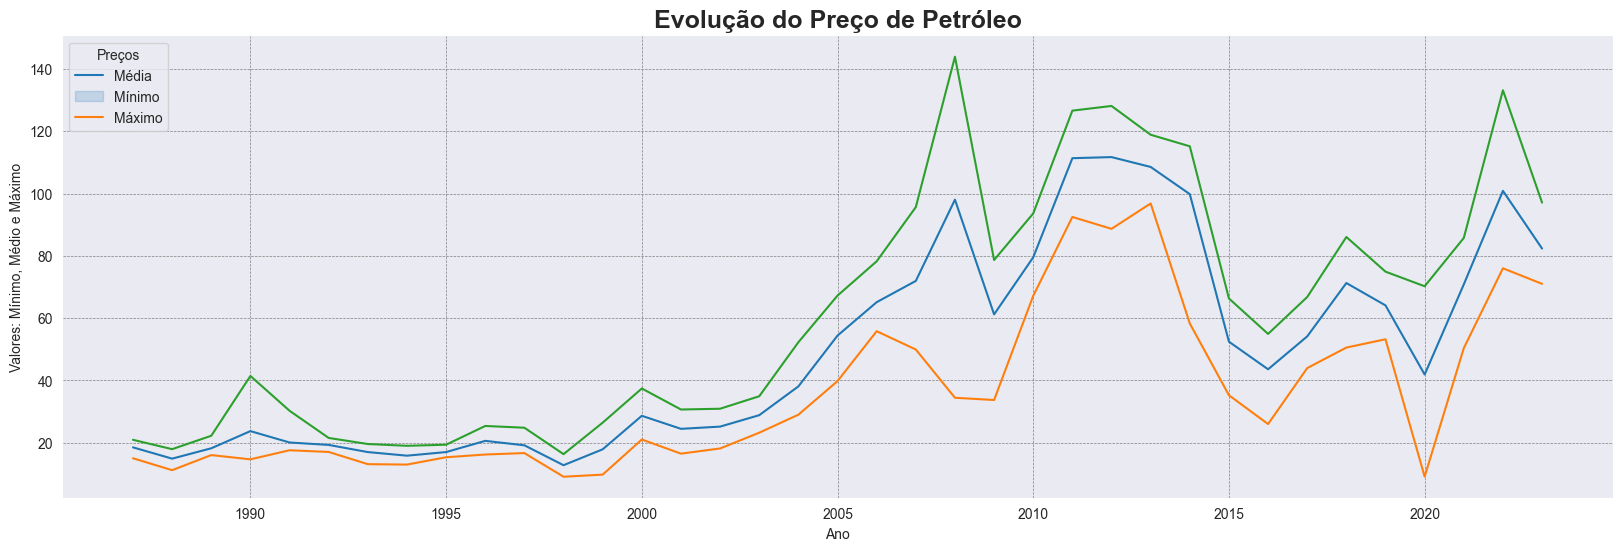

In [21]:
# Plotando o gráfico de evolução do preço do petróleo
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# removendo as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

# Agrupando os dados por ano e calculando as estatísticas
dados_agrupados = dados_petroleo.groupby('ano').agg({'preco': ['mean', 'min', 'max']}).reset_index()

# Plotando o gráfico
ax = sns.lineplot(data=dados_agrupados, x='ano', y=('preco', 'mean'), label='Média')
ax = sns.lineplot(data=dados_agrupados, x='ano', y=('preco', 'min'), label='Mínimo')
ax = sns.lineplot(data=dados_agrupados, x='ano', y=('preco', 'max'), label='Máximo')

ax.set_title('Evolução do Preço de Petróleo', fontsize=18, weight='bold')
ax.set_ylabel('Valores: Mínimo, Médio e Máximo')
ax.set_xlabel('Ano')

# Adicionando a legenda
ax.legend(title='Preços', labels=['Média', 'Mínimo', 'Máximo'], loc='upper left')

plt.show()

In [22]:
dados_petroleo.describe().T

count                           mean                  min  \
ano         11077.0                    2005.951702               1987.0   
mes         11077.0                       6.554392                  1.0   
semana_ano  11077.0                      26.716349                  1.0   
dia_semana  11077.0                       3.540399                  1.0   
data          11077  2006-06-14 20:50:27.678974592  1987-05-20 00:00:00   
preco       11077.0                      52.761207                  9.1   

                            25%                  50%                  75%  \
ano                      1998.0               2007.0               2014.0   
mes                         4.0                  7.0                 10.0   
semana_ano                 14.0                 27.0                 40.0   
dia_semana                  2.0                  3.0                  5.0   
data        1998-04-15 00:00:00  2007-02-09 00:00:00  2014-10-11 00:00:00   
preco                      20.4                47.81                75.56   

                            max        std  
ano                      2023.0  10.036234  
mes                        12.0   3.428295  
semana_ano                 53.0  14.958594  
dia_semana                  7.0   1.813167  
data        2023-12-29 00:00:00        NaN  
preco                    143.95  33.238777

## Criação do modelo de Machine Learning

In [23]:
# verificando se a série é estacionária
class VerificaEstacionaridade():
    def __init__(self, data, column):
        self.data = data
        self.column = column

    # analisando se a série é estacionária
    def adf_test(self):
        adf_result = adfuller(self.data[self.column])
        print("Teste ADF:")
        print(f"p-valor: {adf_result[1]}")
        if adf_result[1] >= 0.05:
            print('A série não é estacionária')
        else:
            print('A série é estacionária')

    def kpss_test(self):
        kpss_result = kpss(self.data[self.column], regression="c")
        print("\nTeste KPSS:")
        print(f"p-valor: {kpss_result[1]}")
        if kpss_result[1] <= 0.05:
            print('A série não é estacionária')
        else:
            print('A série é estacionária')

In [24]:
dados_teste = VerificaEstacionaridade(dados_petroleo, 'preco')
dados_teste.adf_test()
dados_teste.kpss_test()

Teste ADF:
p-valor: 0.24680667532234557
A série não é estacionária

Teste KPSS:
p-valor: 0.01
A série não é estacionária


**Visto que a série não é estacionária, é preciso utilizar modelos que levem em consideração:**

* Tendência
* Sazonalidade
* Ruídos

* ## Seleção das features 

In [25]:
# copia para preservar o df
dados_ml = dados_petroleo.copy()

In [26]:
dados_ml.head()

ano  mes nome_mes  semana_ano  dia_semana      nome_dia       data  \
11301  1987    5      May          21           3  quinta-feira 1987-05-20   
11300  1987    5      May          21           4   sexta-feira 1987-05-21   
11299  1987    5      May          21           5        sábado 1987-05-22   
11298  1987    5      May          22           1   terça-feira 1987-05-25   
11297  1987    5      May          22           2  quarta-feira 1987-05-26   

       preco  
11301  18.63  
11300  18.45  
11299  18.55  
11298  18.60  
11297  18.63

In [27]:
# seleção de colunas numéricas
dados_ml = dados_ml[['data', 'preco']]

dados_ml.head(2)

data  preco
11301 1987-05-20  18.63
11300 1987-05-21  18.45

* ## Escolhendo o melhor modelo

In [28]:
# validação dos modelos
def wmape(y_true, y_pred):
    return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

In [29]:
# treino e teste para validaçao dos modelos
treino = dados_ml[:-15][['data', 'preco']]
treino.rename(columns={'data':'ds', 'preco':'y'}, inplace=True)
treino['unique_id'] = 'serie_unica'

teste = dados_ml[-15:][['data', 'preco']]
teste.rename(columns={'data':'ds', 'preco':'y'}, inplace=True)
teste['unique_id'] = 'serie_unica'

h = len(teste)

wmape: 4.43%
Percentual de acerto 95.57%


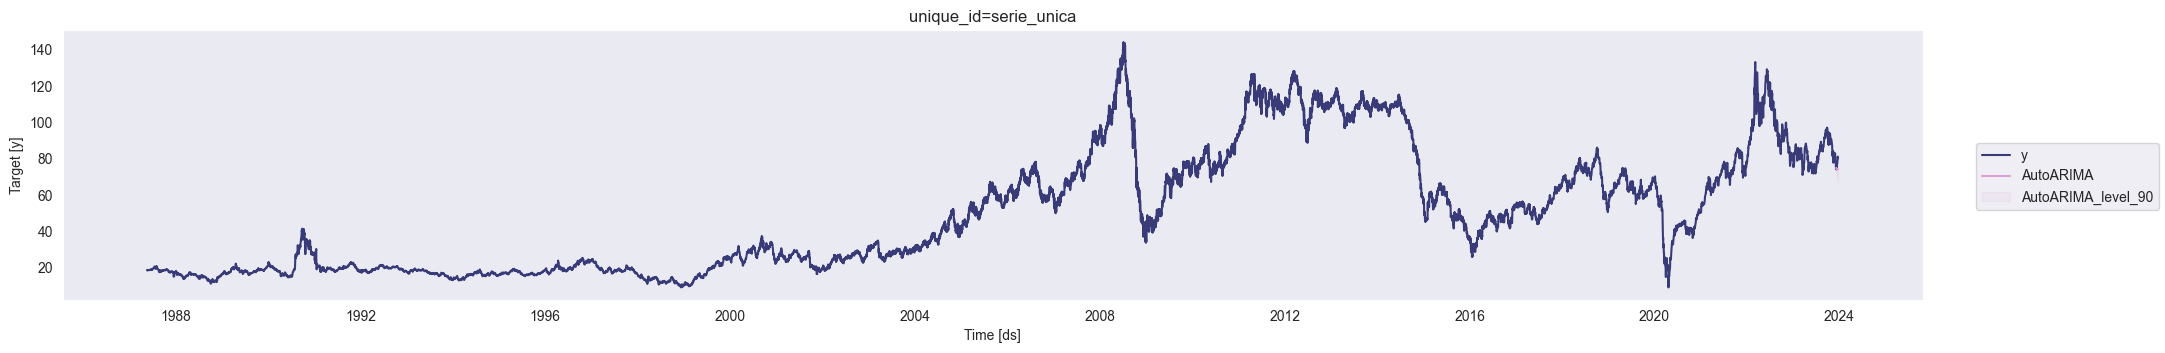

In [30]:
model_a = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
model_a.fit(treino)

forecast_dados = model_a.predict(h=h, level=[90])
forecast_dados = forecast_dados.reset_index().merge(teste, on=['ds', 'unique_id'], how='inner')

wmape_arima = wmape(forecast_dados['y'].values, forecast_dados['AutoARIMA'].values)
print(f'wmape: {wmape_arima:.2%}')
print(f'Percentual de acerto {1- wmape_arima:.2%}')

model_a.plot(treino, forecast_dados, level=[90], engine= 'matplotlib')

wmape: 4.81%
Percentual de acerto 95.19%


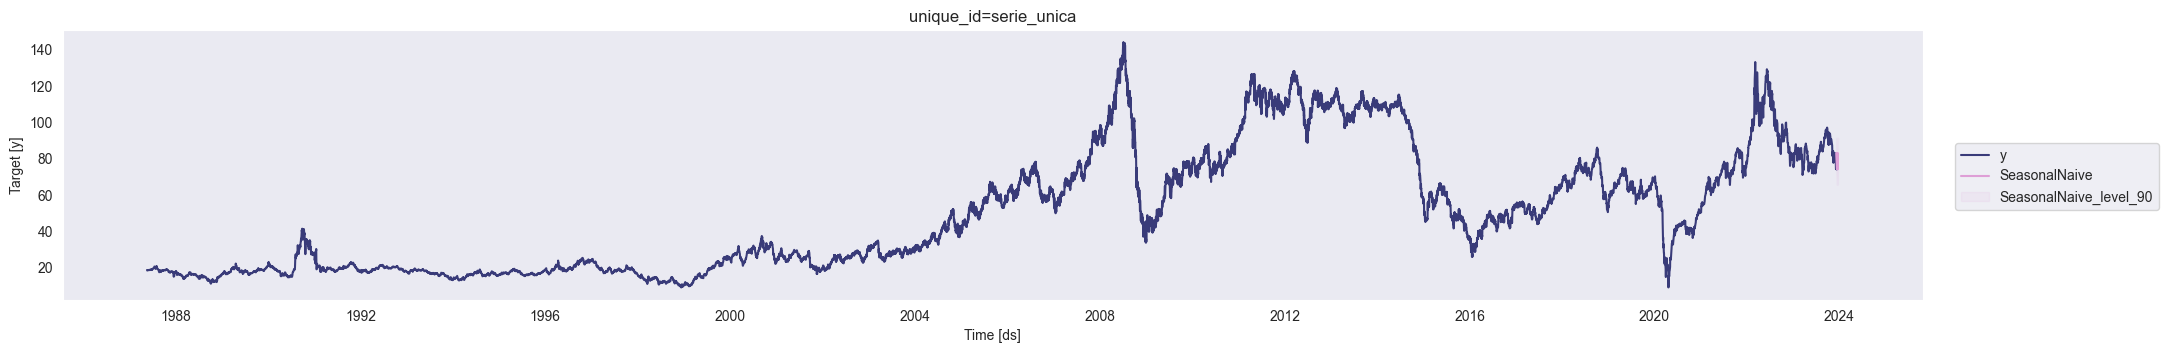

In [31]:
model_s = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='D', n_jobs=-1)
model_s.fit(treino)

forecast_dados_s = model_s.predict(h=h, level=[90])
forecast_dados_s = forecast_dados_s.reset_index().merge(teste, on=['ds', 'unique_id'], how='inner')

wmape_sn = wmape(forecast_dados_s['y'].values, forecast_dados_s['SeasonalNaive'].values)
print(f'wmape: {wmape_sn:.2%}')
print(f'Percentual de acerto {1- wmape_sn:.2%}')

model_s.plot(treino, forecast_dados_s, level=[90],engine ='matplotlib')

WMAPE: 4.34%
Percentual de acerto 95.66%


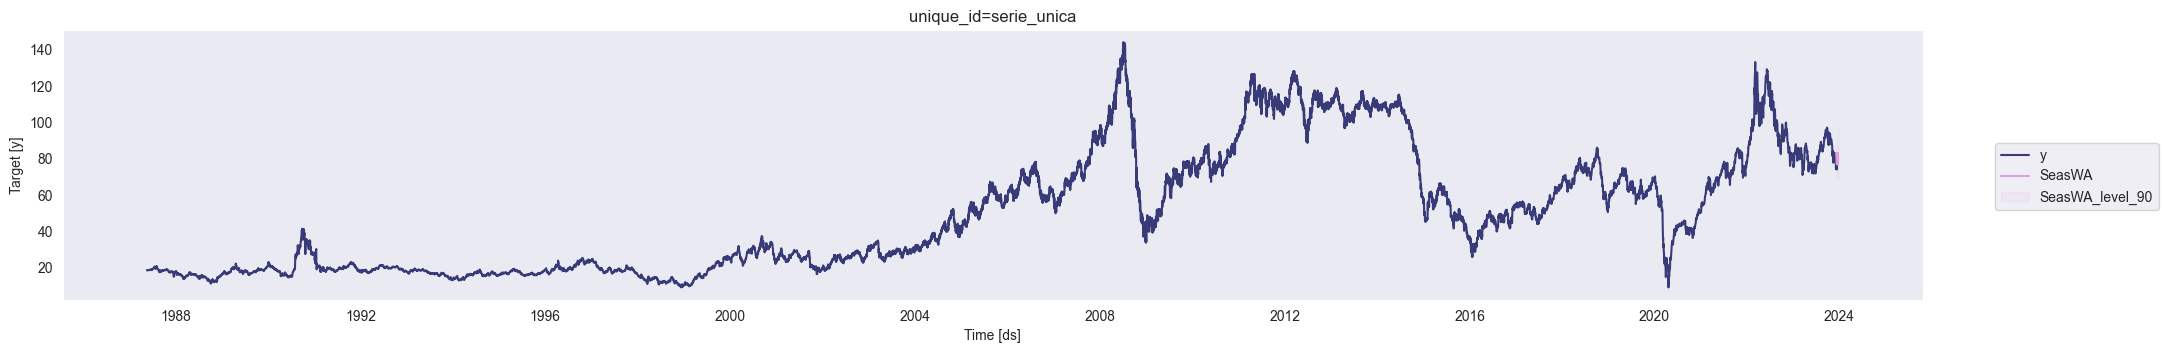

In [32]:
intervals = ConformalIntervals(h=h, n_windows=2)


model_sm = StatsForecast(models=[SeasonalWindowAverage(season_length=7, window_size=2, prediction_intervals=intervals)], freq='D', n_jobs=-1)
model_sm.fit(treino)

forecast_dados_sm = model_sm.predict(h=h, level=[90])
forecast_dados_sm = forecast_dados_sm.reset_index().merge(teste, on=['ds', 'unique_id'], how='inner')

wmape_swa = wmape(forecast_dados_sm['y'].values, forecast_dados_sm['SeasWA'].values)
print(f"WMAPE: {wmape_swa:.2%}")
print(f'Percentual de acerto {1- wmape_swa:.2%}')

model_sm.plot(treino, forecast_dados_sm, level=[90], engine ='matplotlib')

## Pipeline

In [33]:
# classe para preparação dos dados
class PreProcessData:
    def __init__(self, data):
        self.data = data
        self.model_SeasonalNaive = None

    # tratamento do df
    def preprocess_data(self):
        self.data['data'] = pd.to_datetime(self.data['data'], format='%Y-%m-%d')
        self.data['unique_id'] = 'serie_unica'
        self.data.rename(columns={'data':'ds', 'preco':'y'}, inplace=True)
        self.data.dropna(inplace=True)
        self.data = self.data[['ds', 'y', 'unique_id']].reset_index(drop=True)
        return self.data

# classe para divisão de treino e teste
class SplitTrainTeste:
    def __init__(self, data):
        self.data = data
        self.train = None
        self.test = None
        self.h = None

    # divisão treino e teste
    def split_train_teste(self):
        self.train = self.data[:-15].dropna()
        self.test = self.data[-15:].dropna()
        self.h = len(self.test.index)
        print(f'{len(self.train):,} valores para treino')
        print(f'{len(self.test):,} valores para teste')
        return self.train, self.test, self.h


# classe para instanciar o modelo
class ModelSeasonalNaive():
    def __init__(self, train_data, h):
        self.train_data = train_data
        self.h = h

    # treinamento a aplicacao dos modelos
    def fit_SeasonalNaive(self):
        self.model_SeasonalNaive = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='D', n_jobs=-1)
        self.model_SeasonalNaive.fit(self.train_data)
        print('Treinamento concluído')

    def predic_SeasonalNaive(self, date):
        self.h = (pd.Timestamp(date) - self.train_data['ds'].max()).days
        forecast = self.model_SeasonalNaive.predict(h=self.h, level=[90])
        return  forecast[forecast['ds'] == date]['SeasonalNaive'].values[0]

In [34]:
# processando os dados
dados_model = dados_ml.copy()
processar_dados = PreProcessData(dados_model)
dados_model = processar_dados.preprocess_data()

display(dados_model.head(2))

ds      y    unique_id
0 1987-05-20  18.63  serie_unica
1 1987-05-21  18.45  serie_unica

In [35]:

# dividindo em treino e teste
split = SplitTrainTeste(dados_model)
train, test, h = split.split_train_teste()

11,062 valores para treino
15 valores para teste


In [36]:
# treinando o modelo
model_sv = ModelSeasonalNaive(train, h)
model_sv.fit_SeasonalNaive()

Treinamento concluído


In [37]:
# prevendo valores
model_sv.predic_SeasonalNaive('2024-11-27')

74.33

In [38]:

# salvando o modelo
joblib.dump(model_sv, r'C:\Users\tamir\OneDrive\Área de Trabalho\Pos-Tech Fase 4.joblib')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\tamir\\OneDrive\\Área de Trabalho\\Pos-Tech Fase 4.joblib'

In [ ]:

# testando o modelo salvo
model_t = joblib.load(r'C:\Users\tamir\OneDrive\Área de Trabalho\Pos-Tech Fase 4.joblib')
model_t.predic_SeasonalNaive('2024-11-27')

np.float64(74.33)

## Passo 4: Complementando a análise com dados externos

### Introdução

O preço do petróleo Brent é amplamente influenciado por um conjunto de fatores econômicos, políticos e estruturais. Analisar esses elementos em conjunto com os preços históricos permite identificar padrões e compreender as dinâmicas que movem este mercado crucial. Para enriquecer a análise e fornecer insights mais profundos, integraremos dados externos relevantes que ajudam a explicar as variações no preço do petróleo. Abaixo, apresentamos os principais conjuntos de dados que serão utilizados:

* **Produção de petróleo:** Refere-se ao volume total de petróleo bruto extraído globalmente em um determinado período. A oferta de petróleo no mercado é diretamente impactada pela produção, sendo um fator-chave na definição dos preços, especialmente durante eventos como cortes na produção pela OPEP.

* **Consumo de energia:** Representa a demanda global por energia em diversas formas, incluindo petróleo. Esse indicador reflete o crescimento econômico e o comportamento do consumo em setores industriais e residenciais, influenciando diretamente os preços.

* **PIB mundial:** O Produto Interno Bruto (PIB) global é uma medida do desempenho econômico agregado dos países. Uma economia global forte geralmente aumenta a demanda por energia e, consequentemente, por petróleo, enquanto crises econômicas têm o efeito contrário.

* **S&P 500:** Este índice representa o desempenho das 500 maiores empresas listadas na Bolsa de Valores dos Estados Unidos. É um indicador de confiança no mercado financeiro e pode se correlacionar com o preço do petróleo, especialmente durante períodos de volatilidade econômica.

* **Taxa de juros:** Refere-se ao custo do crédito e ao retorno esperado sobre investimentos. Taxas de juros elevadas podem desestimular o crescimento econômico, reduzindo a demanda por petróleo, enquanto taxas mais baixas tendem a estimular a atividade econômica e o consumo de energia.

Esses dados, em conjunto com os históricos de preços do petróleo Brent, serão analisados para identificar correlações e tendências ao longo do tempo. Essa abordagem multidimensional permitirá compreender como diferentes fatores influenciam o mercado de petróleo, gerando insights valiosos para a tomada de decisão estratégica.

## *Análise exploratótia: Produção*

In [ ]:
import numpy as np

In [ ]:
producao = pd.read_csv("https://raw.githubusercontent.com/Tamireees/Tech_Challenge_fase04/refs/heads/main/producao.csv", sep=';')
producao.head()

year barrels per year  country
0  2000              5.7  Albania
1  2001              5.6  Albania
2  2002              7.1  Albania
3  2003              6.8  Albania
4  2004              7.6  Albania

In [ ]:

producao.shape

(2571, 3)

In [ ]:

producao.columns

Index(['year', 'barrels per year', 'country'], dtype='object')

In [ ]:
# Substituir '--' por NaN
producao['barrels per year'] = producao['barrels per year'].replace('--', 0)

In [ ]:
producao['year'] = pd.to_datetime(producao['year'], format='%Y').dt.year
producao['barrels per year'] = producao['barrels per year'].astype(float)

In [ ]:
producao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2571 entries, 0 to 2570
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              2571 non-null   int32  
 1   barrels per year  2571 non-null   float64
 2   country           2571 non-null   object 
dtypes: float64(1), int32(1), object(1)
memory usage: 50.3+ KB


In [ ]:
# Verificando se há valores duplicados:
producao.value_counts()

# Temos valores repetidos, porem ja era esperado.

year  barrels per year  country       
2023  21973.0           United States     1
2000  0.2               Mongolia          1
      0.4               Tajikistan        1
      0.5               Bulgaria          1
      0.9               Philippines       1
                                         ..
      7.0               Ivory Coast       1
      7.5               Czech Republic    1
      9.0               Chile             1
      10.0              Suriname          1
      12.0              Myanmar           1
Name: count, Length: 2571, dtype: int64

In [ ]:
mean_producao = producao.groupby('year').agg({'barrels per year': 'mean'}).reset_index()

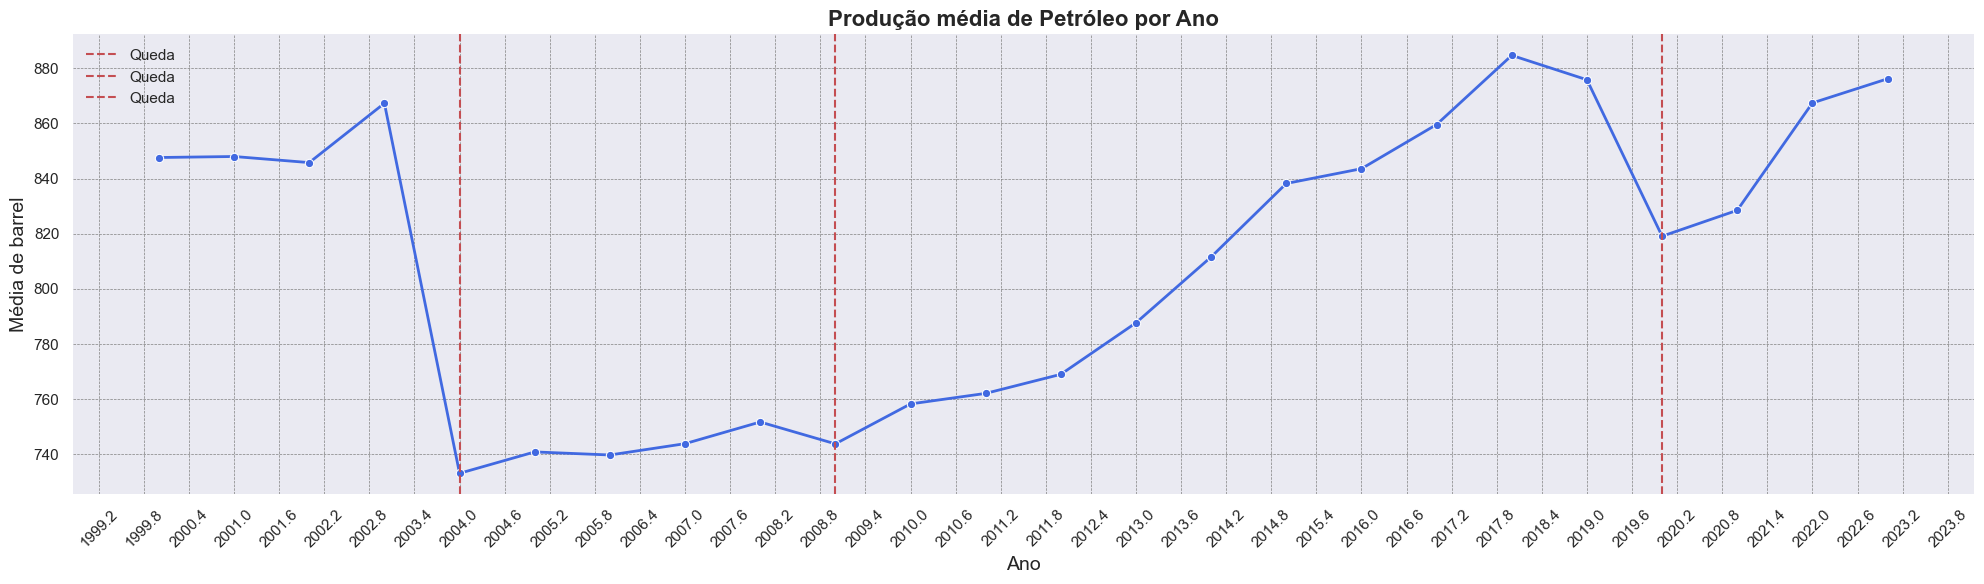

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Removendo as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

# Plotando o gráfico com linha e marcadores
ax = sns.lineplot(x='year', y='barrels per year', data=mean_producao, marker='o', color='royalblue', linewidth=2)

# Ajuste dos rótulos e exibição de datas
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(50))

plt.axvline(x=2004, color='r', linestyle='--', label='Queda')
plt.axvline(x=2009, color='r', linestyle='--', label='Queda')
plt.axvline(x=2020, color='r', linestyle='--', label='Queda')

plt.title('Produção média de Petróleo por Ano', fontsize=16, weight='bold')
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Média de barrel', fontsize=14)
plt.legend(loc='upper left', frameon=False)
plt.tight_layout()

# Exibindo o gráfico
plt.show()

In [ ]:
mean_producao.head()

year  barrels per year
0  2000        847.622353
1  2001        847.989412
2  2002        845.781176
3  2003        867.289535
4  2004        733.121296

In [ ]:
df_filtrado.head()


ano  mes  nome_mes  semana_ano  dia_semana      nome_dia       data  preco
0  2023   12  dezembro          52           5        sábado 2023-12-29  77.69
1  2023   12  dezembro          52           4   sexta-feira 2023-12-28  79.04
2  2023   12  dezembro          52           3  quinta-feira 2023-12-27  80.97
3  2023   12  dezembro          52           2  quarta-feira 2023-12-26  80.23
4  2023   12  dezembro          51           5        sábado 2023-12-22  80.23

In [ ]:

mean_preco = df_filtrado.groupby('ano').agg({'preco': 'mean'}).reset_index()

mean_preco.head()

ano      preco
0  2000  28.660672
1  2001  24.475664
2  2002  25.187327
3  2003  28.861247
4  2004  38.102351

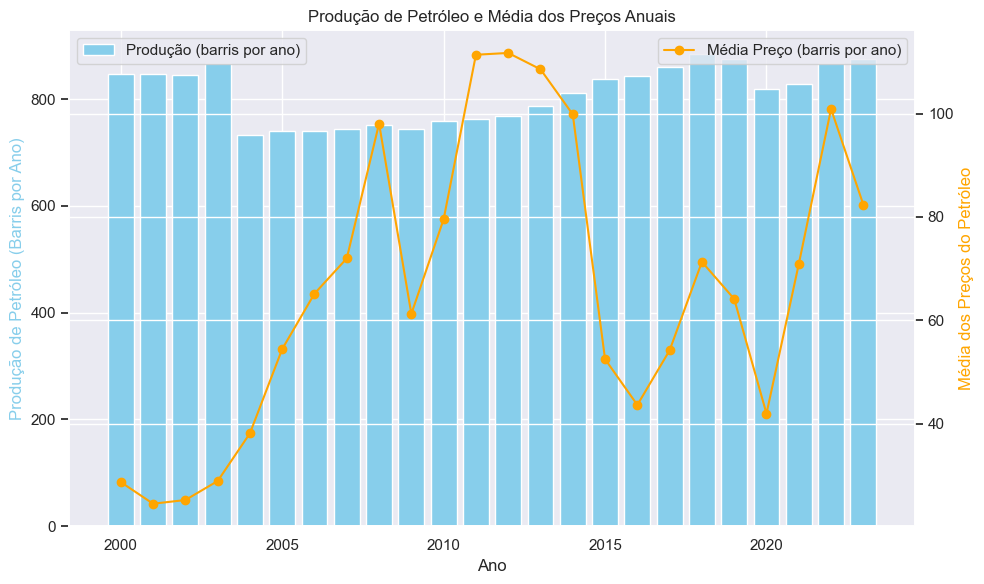

In [ ]:
# Mesclando os dois DataFrames com base no ano
dados = pd.merge(mean_producao, mean_preco, left_on='year', right_on='ano', how='inner')

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico de barras para a produção de petróleo
ax1.bar(dados['year'], dados['barrels per year'], color='skyblue', label='Produção (barris por ano)')
ax1.set_ylabel('Produção de Petróleo (Barris por Ano)', color='skyblue')
ax1.set_xlabel('Ano')

# Eixo secundário para a linha do preço do petróleo
ax2 = ax1.twinx()
ax2.plot(mean_preco['ano'], mean_preco['preco'], color='orange', marker='o', label='Média Preço (barris por ano)')
ax2.set_ylabel('Média dos Preços do Petróleo', color='orange')

# Título e exibição da legenda
plt.title('Produção de Petróleo e Média dos Preços Anuais')
fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

*Crescimento da Produção de Petróleo: A produção de petróleo aumentou de forma significativa desde o início dos anos 2000, estabilizando-se em torno de 2010. Esse crescimento reflete avanços na capacidade de produção, possivelmente devido a novas descobertas, avanços tecnológicos, ou investimentos na infraestrutura de extração de petróleo.*

*Volatilidade dos Preços do Petróleo: A linha laranja que representa a média dos preços anuais do petróleo mostra uma grande volatilidade. Os preços subiram acentuadamente até cerca de 2008, atingindo um pico, seguido por uma queda acentuada. Depois de 2010, os preços continuaram a flutuar, com uma queda significativa por volta de 2015 e outra em torno de 2020, talvez relacionada a crises econômicas ou eventos globais (como a pandemia de COVID-19 em 2020).*

In [ ]:
producao_soma_por_ano = producao.groupby('year')['barrels per year'].sum().reset_index()
producao_soma_por_ano['percent_growth'] = producao_soma_por_ano['barrels per year'].pct_change() * 100
producao_soma_por_ano.head()

year  barrels per year  percent_growth
0  2000           72047.9             NaN
1  2001           72079.1        0.043305
2  2002           71891.4       -0.260408
3  2003           74586.9        3.749405
4  2004           79177.1        6.154164

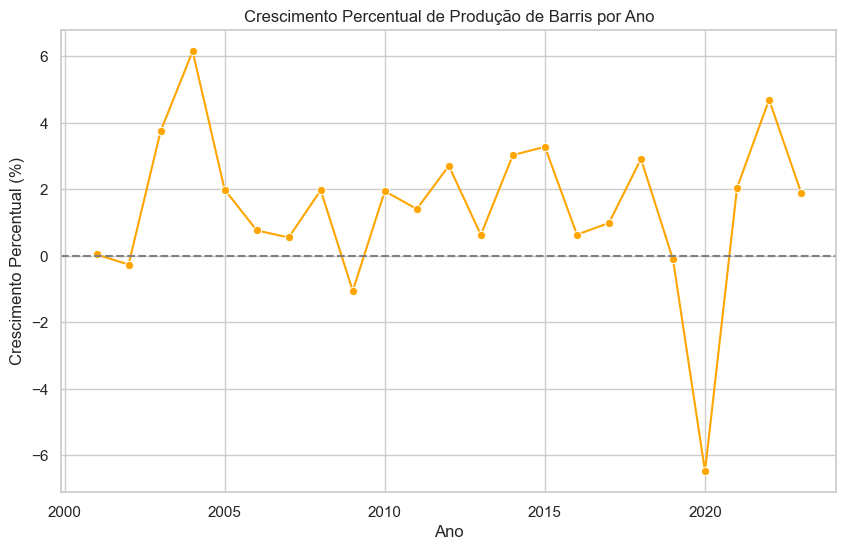

In [ ]:
sns.set(style="whitegrid")

# Cria um gráfico de linha para a porcentagem de crescimento
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='percent_growth', data=producao_soma_por_ano, marker='o', color='orange')

# Configura os rótulos e título
plt.xlabel('Ano')
plt.ylabel('Crescimento Percentual (%)')
plt.title('Crescimento Percentual de Produção de Barris por Ano')

# Exibe o gráfico
plt.axhline(0, color='gray', linestyle='--')  # Linha horizontal no 0 para referência
plt.show()

*O gráfico da produção anual de barris de petróleo ao longo dos anos de 2000 a 2023, acompanhada da taxa de crescimento percentual anual. A análise dos dados oferece insights importantes sobre as flutuações no setor de petróleo, bem como sobre o impacto de eventos globais específicos na produção.*

*Estabilidade Inicial (2000–2002): Entre 2000 e 2002, a produção de petróleo manteve-se estável, com oscilações muito pequenas, como o crescimento marginal de 0,04% em 2001 e uma leve queda de 0,26% em 2002.*

*Período de Crescimento Moderado (2003–2008): De 2003 a 2008, a produção apresentou um crescimento constante, especialmente notável em 2004 (6,15%), refletindo um aumento na demanda global impulsionado pelo crescimento econômico em várias regiões, especialmente na Ásia.*

*Crise Econômica Global (2009): Em 2009, observa-se uma queda de -1,05% na produção, refletindo o impacto da crise econômica global de 2008-2009, que reduziu a demanda e afetou a produção e os preços do petróleo.*

*Recuperação e Crescimento (2010–2019): Após a crise, a produção volta a crescer, apresentando valores consistentes de aumento na maioria dos anos, com destaques como 2015 (3,28%) e 2018 (2,92%). Esse período reflete o fortalecimento da economia global e a recuperação da demanda por petróleo.*

*Impacto da Pandemia (2020): Em 2020, há uma queda expressiva de -6,48% na produção, a maior de toda a série, devido à pandemia de COVID-19, que levou a uma redução drástica na demanda por petróleo e no consumo global de energia.*

*Recuperação Pós-Pandemia (2021–2023): A partir de 2021, a produção retoma um crescimento moderado. Em 2022, destaca-se uma recuperação significativa de 4,69%, com a demanda global voltando aos níveis pré-pandêmicos. Em 2023, o crescimento continua, embora em um ritmo mais moderado (1,9%).*

In [ ]:
producao_media_por_pais = producao.groupby('country')['barrels per year'].mean().reset_index()

In [ ]:
valores_zerados = (producao_media_por_pais['barrels per year'] == 0).sum()
print(f"Número de valores zerados: {valores_zerados}")

Número de valores zerados: 2


In [ ]:
producao_soma_por_pais = producao_media_por_pais[producao_media_por_pais['barrels per year'] != 0]

In [ ]:
media_produção_top_10_paises = producao_media_por_pais.nlargest(10, 'barrels per year')
media_produção_top_10_paises.head(10)

country  barrels per year
108         United States      12829.750000
85           Saudi Arabia      10813.791667
84                 Russia      10044.875000
25                  China       4386.625000
22                 Canada       4065.083333
50                   Iran       3918.333333
106  United Arab Emirates       3321.750000
51                   Iraq       3147.166667
18                 Brazil       2658.791667
59                 Kuwait       2629.500000

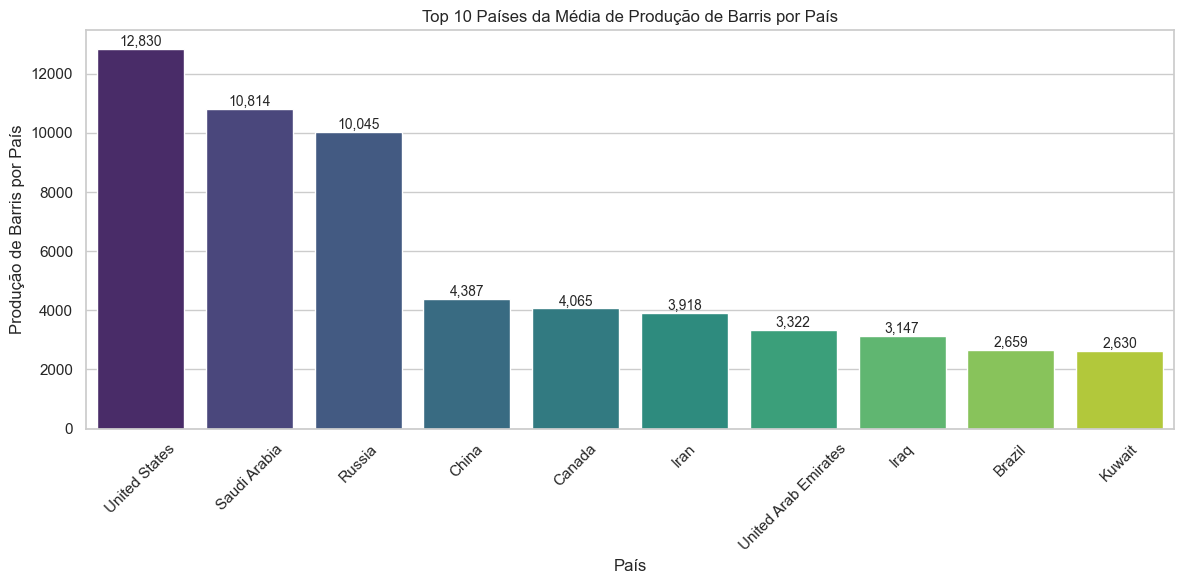

In [ ]:
plt.figure(figsize=(12, 6))  # Ajusta o tamanho da figura
ax = sns.barplot(x='country', y='barrels per year', data=media_produção_top_10_paises, palette='viridis')

plt.title('Top 10 Países da Média de Produção de Barris por País')
plt.xlabel('País')
plt.ylabel('Produção de Barris por País')

plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}',  # Formata o valor com vírgulas
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Posição da anotação
                ha='center', va='bottom', fontsize=10)  # Alinhamento e tamanho da fonte

plt.tight_layout()  


*Os dados apresentados mostram a produção de petróleo em barris por ano para os principais países produtores, destacando o domínio de algumas nações no setor.*

*Estados Unidos lidera a produção global com 307.914 milhões de barris anuais, refletindo sua posição consolidada como principal produtor mundial. A capacidade de extração dos EUA se apoia em avanços tecnológicos, como o fraturamento hidráulico (fracking), que aumentou significativamente a produção nas últimas décadas.*

*Arábia Saudita ocupa o segundo lugar, com 259.531 milhões de barris, impulsionada por suas vastas reservas no Oriente Médio e pelo papel central que desempenha na Organização dos Países Exportadores de Petróleo (OPEP).*

*Rússia, em terceiro, com 241.077 milhões de barris, também desempenha um papel fundamental no mercado global de petróleo, fornecendo uma quantidade significativa para a Europa e a Ásia.*

*China e Canadá produzem 105.279 milhões e 97.562 milhões de barris, respectivamente. A China, embora seja um grande consumidor de petróleo, possui também uma produção significativa. O Canadá, por sua vez, conta com reservas consideráveis de petróleo, especialmente nas areias betuminosas de Alberta.*

*Outros países notáveis incluem o Irã (94.040 milhões), que enfrenta desafios devido a sanções econômicas, e os Emirados Árabes Unidos (79.722 milhões), que são conhecidos por suas reservas abundantes e política energética de expansão.*

*Iraque (75.532 milhões), Brasil (63.811 milhões), e Kuwait (63.108 milhões) completam a lista, cada um com um papel relevante na produção global. O Brasil, o único país da *América Latina na lista, destaca-se pela exploração de petróleo em águas profundas, como na região do pré-sal.*

*Esses dados sublinham a importância estratégica do petróleo para cada uma dessas economias e evidenciam as diferenças na capacidade de produção entre os países, influenciando o mercado energético global.*

## *Análise exploratótia: Consumo de energia*:

In [ ]:
consumo = pd.read_csv('https://raw.githubusercontent.com//Tamireees//Tech_Challenge_fase04//refs//heads//main//consumo.csv', sep=';')


In [ ]:
consumo['QBTU'] = pd.to_numeric(consumo['QBTU'], errors='coerce') # QBTU (quilocalorias por tonelada de petróleo equivalente) 


In [ ]:
# Conversão de QBTU para Barris
consumo['barrels'] = consumo['QBTU'] / 0.0058

print(consumo)

       ano   QBTU                       pais    barrels
0     2000  0.562                   Colombia  96.896552
1     2000  0.002   Saint Vincent/Grenadines   0.344828
2     2000  0.132        U.S. Virgin Islands  22.758621
3     2000  0.297                 Uzbekistan  51.206897
4     2000  0.001     British Virgin Islands   0.172414
...    ...    ...                        ...        ...
4779  2022    NaN       United Arab Emirates        NaN
4780  2022  0.051                    Albania   8.793103
4781  2022  0.247                     Angola  42.586207
4782  2022  0.055                Afghanistan   9.482759
4783  2022  0.017                      Aruba   2.931034

[4784 rows x 4 columns]


In [ ]:
# Média do Consumo de Energia (barris) por ano:
consumo_medio_por_ano = consumo.groupby('ano')['barrels'].mean().reset_index()
consumo_medio_por_ano.head()

ano    barrels
0  2000  44.927605
1  2001  34.489539
2  2002  38.195339
3  2003  47.571214
4  2004  31.021891

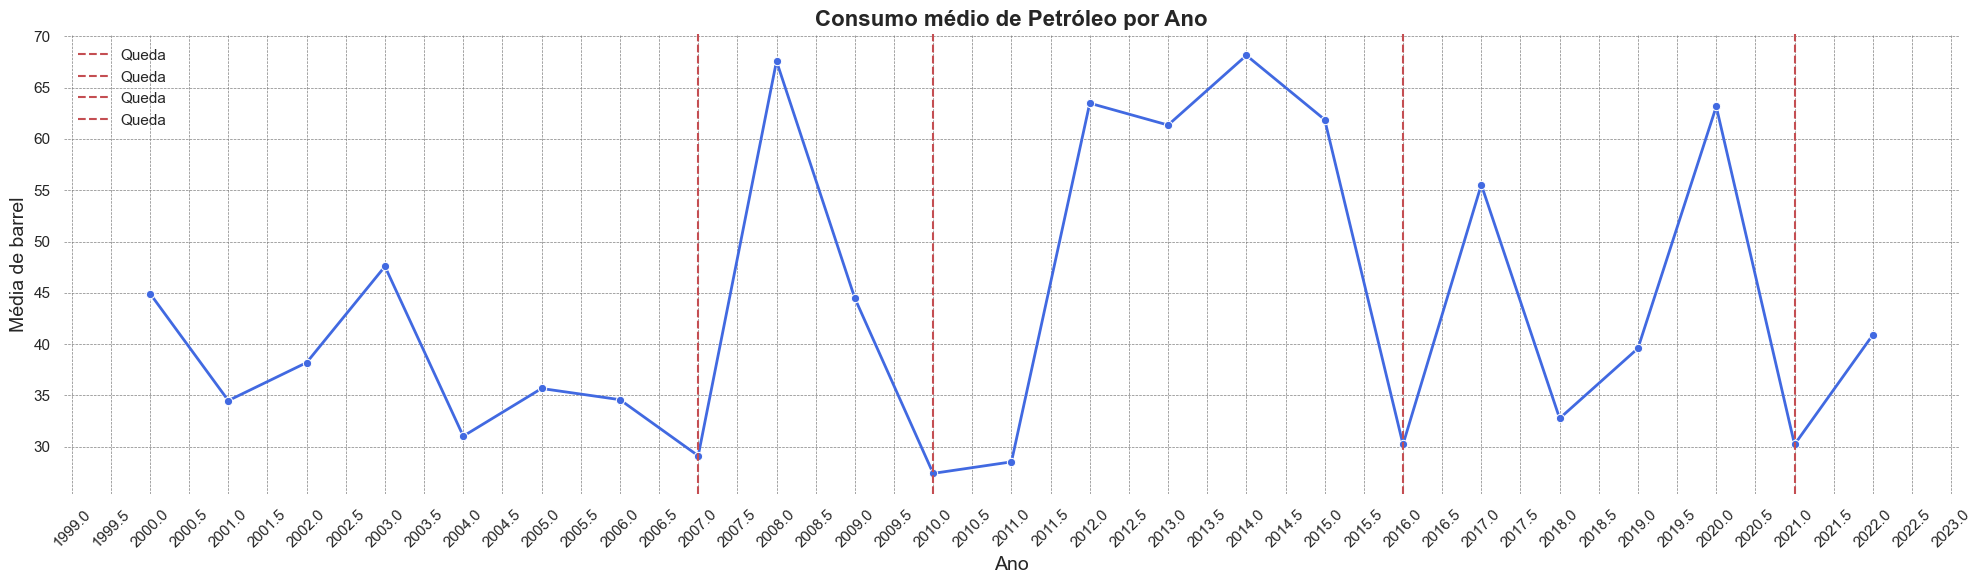

In [ ]:
# Plotando o gráfico novamente
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Removendo as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

# Plotando o gráfico com linha e marcadores
ax = sns.lineplot(x='ano', y='barrels', data=consumo_medio_por_ano, marker='o', color='royalblue', linewidth=2)

# Ajuste dos rótulos e exibição de datas
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(50))

# Adicionando uma linha vertical para marcar a crise de 2008
plt.axvline(x=2007, color='r', linestyle='--', label='Queda')
plt.axvline(x=2010, color='r', linestyle='--', label='Queda')
plt.axvline(x=2016, color='r', linestyle='--', label='Queda')
plt.axvline(x=2021, color='r', linestyle='--', label='Queda')

# Destacando o período de crise com faixa sombreada
#ax.axvspan(pd.to_datetime("2008-05"), pd.to_datetime("2009-03"), color='red', alpha=0.2, label='Crise de 2008-2009')

# Personalizando títulos e eixos
plt.title('Consumo médio de Petróleo por Ano', fontsize=16, weight='bold')
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Média de barrel', fontsize=14)
plt.legend(loc='upper left', frameon=False)
plt.tight_layout()

# Exibindo o gráfico
plt.show()

In [ ]:
consumo_medio_por_ano.head()

ano    barrels
0  2000  44.927605
1  2001  34.489539
2  2002  38.195339
3  2003  47.571214
4  2004  31.021891

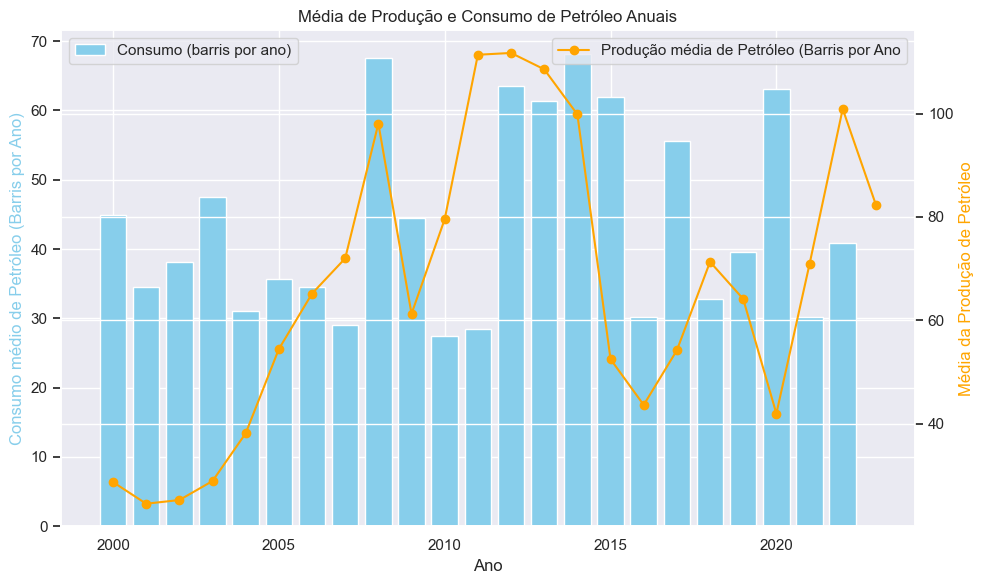

In [ ]:
# Mesclando os dois DataFrames com base no ano
consumo_producao = pd.merge(consumo_medio_por_ano, mean_preco, left_on='ano', right_on='ano', how='inner')

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico de barras para a consumo de petróleo:
ax1.bar(consumo_medio_por_ano['ano'], consumo_medio_por_ano['barrels'], color='skyblue', label='Consumo (barris por ano)')
ax1.set_ylabel('Consumo médio de Petróleo (Barris por Ano)', color='skyblue')
ax1.set_xlabel('Ano')

# Gráfico de barras para a producao de petróleo:
ax2 = ax1.twinx()
ax2.plot(mean_preco['ano'], mean_preco['preco'], color='orange', marker='o', label='Produção média de Petróleo (Barris por Ano')
ax2.set_ylabel('Média da Produção de Petróleo', color='orange')

# Título e exibição da legenda
plt.title('Média de Produção e Consumo de Petróleo Anuais')
fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

* *O consumo médio de petróleo, representado pelas barras, parece relativamente estável ao longo dos anos, com algumas flutuações, mas sem uma tendência de crescimento ou declínio acentuado. Isso indica que a demanda por petróleo estável ao longo do tempo, apesar de eventuais variações.*

* *A linha laranja mostra que a produção de petróleo passou por várias oscilações, com uma queda acentuada em meados dos anos 2000 e um aumento significativo a partir de 2010.
Esse aumento recente na produção pode estar associado a novas tecnologias de extração, como o fracking, ou à exploração de novos campos petrolíferos.*

* *O gráfico destaca a relação complexa entre produção e consumo de petróleo, onde fatores externos e avanços tecnológicos parecem ter papel significativo. A análise dessas tendências ajuda a entender a segurança energética e a dependência de importações, além de fornecer insights sobre a resiliência da produção frente a demandas flutuantes.*


In [ ]:
# Média do Consumo de Energia (pais) por ano:
consumo_medio_por_pais = consumo.groupby('pais')['barrels'].mean().reset_index()
consumo_medio_por_pais.head()

pais     barrels
0      Afghanistan    7.908546
1          Albania    9.490255
2          Algeria  117.091454
3   American Samoa    1.146927
4           Angola   34.325337

In [ ]:
Consumo_medio_top_10_paises = consumo_medio_por_pais.nlargest(10, 'barrels')
Consumo_medio_top_10_paises.head(10)

pais      barrels
197   United States  6254.741379
39            China  4530.459770
94            Japan  1702.586207
86            India  1129.310345
150          Russia  1017.241379
71          Germany   986.206897
24           Brazil   973.563218
34           Canada   806.034483
168     South Korea   763.793103
158    Saudi Arabia   745.689655

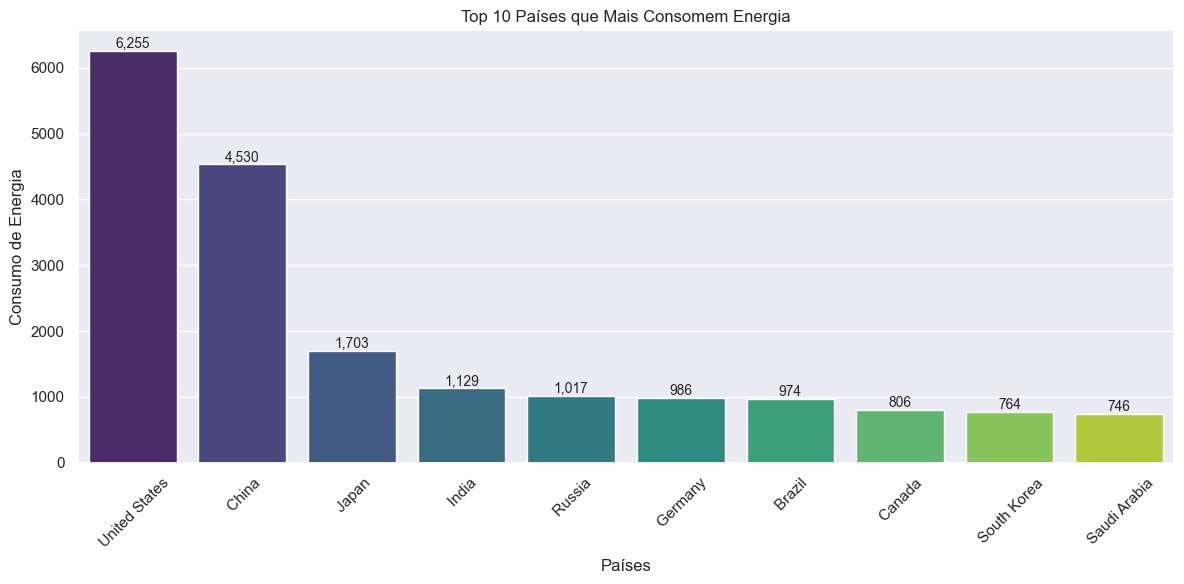

In [ ]:
plt.figure(figsize=(12, 6))  # Ajusta o tamanho da figura
ax = sns.barplot(x='pais', y='barrels', data=Consumo_medio_top_10_paises, palette='viridis')
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}',  # Formata o valor com vírgulas
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Posição da anotação
                ha='center', va='bottom', fontsize=10)  # Alinhamento e tamanho da fonte

# Ajusta a rotação dos valores no eixo x
plt.xticks(rotation=45)  # Define rotação de 45 graus

plt.title('Top 10 Países que Mais Consomem Energia')
plt.xlabel('Países')
plt.ylabel('Consumo de Energia')
plt.tight_layout()
plt.show()

## *Análise exploratótia: PIB Mundial*:

In [ ]:
pib_mundial = pd.read_csv('https://github.com/Tamireees/Tech_Challenge_fase04/raw/refs/heads/main/GDR=PIB.csv', sep=',')
#Fonte: WorldBank = https://databank.worldbank.org/reports.aspx?source=2&series=NY.GDP.MKTP.KD&country=#


In [ ]:
pib_mundial = pib_mundial.drop(['Series Name', 'Series Code', 'Country Code'], axis=1)
pib_mundial.head()

Country Name  2000 [YR2000]  2001 [YR2001]  2002 [YR2002]  2003 [YR2003]  \
0        World   4.838856e+13   4.936862e+13   5.050550e+13   5.207333e+13   
1          NaN            NaN            NaN            NaN            NaN   
2          NaN            NaN            NaN            NaN            NaN   
3          NaN            NaN            NaN            NaN            NaN   
4          NaN            NaN            NaN            NaN            NaN   

   2004 [YR2004]  2005 [YR2005]  2006 [YR2006]  2007 [YR2007]  2008 [YR2008]  \
0   5.440062e+13   5.657984e+13   5.909356e+13   6.167789e+13   6.294999e+13   
1            NaN            NaN            NaN            NaN            NaN   
2            NaN            NaN            NaN            NaN            NaN   
3            NaN            NaN            NaN            NaN            NaN   
4            NaN            NaN            NaN            NaN            NaN   

   ...  2014 [YR2014]  2015 [YR2015]  2016 [YR2016]  2017 [YR2017]  \
0  ...   7.307523e+13   7.535966e+13   7.748522e+13   8.016639e+13   
1  ...            NaN            NaN            NaN            NaN   
2  ...            NaN            NaN            NaN            NaN   
3  ...            NaN            NaN            NaN            NaN   
4  ...            NaN            NaN            NaN            NaN   

   2018 [YR2018]  2019 [YR2019]  2020 [YR2020]  2021 [YR2021]  2022 [YR2022]  \
0   8.280115e+13   8.498894e+13   8.249703e+13   8.766122e+13   9.036960e+13   
1            NaN            NaN            NaN            NaN            NaN   
2            NaN            NaN            NaN            NaN            NaN   
3            NaN            NaN            NaN            NaN            NaN   
4            NaN            NaN            NaN            NaN            NaN   

   2023 [YR2023]  
0   9.282706e+13  
1            NaN  
2            NaN  
3            NaN  
4            NaN  

[5 rows x 25 columns]

In [ ]:
pib_mundial_T = pib_mundial.transpose().reset_index()

In [ ]:
pib_mundial_T = pib_mundial_T.dropna(axis=1)

In [ ]:
pib_mundial_T = pib_mundial_T.rename(columns=
                 { 'index': 'ano',
                     0: 'pib_anual'   })

In [ ]:
pib_mundial_T.drop(0, axis=0, inplace=True)

In [ ]:
pib_mundial_T.head()

ano              pib_anual
1  2000 [YR2000]  48388557167110.898438
2  2001 [YR2001]  49368620392265.296875
3  2002 [YR2002]  50505499243552.296875
4  2003 [YR2003]       52073329170330.5
5  2004 [YR2004]  54400621045246.601562

In [ ]:
pib_mundial_T['ano'] = pib_mundial_T['ano'].apply(lambda x: int(x.split()[0]))

In [ ]:
pib_mundial_T['pib_anual'] = pd.to_numeric(pib_mundial_T['pib_anual'], errors='coerce')

In [ ]:
pib_mundial_T.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 1 to 24
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ano        24 non-null     int64  
 1   pib_anual  24 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 516.0 bytes


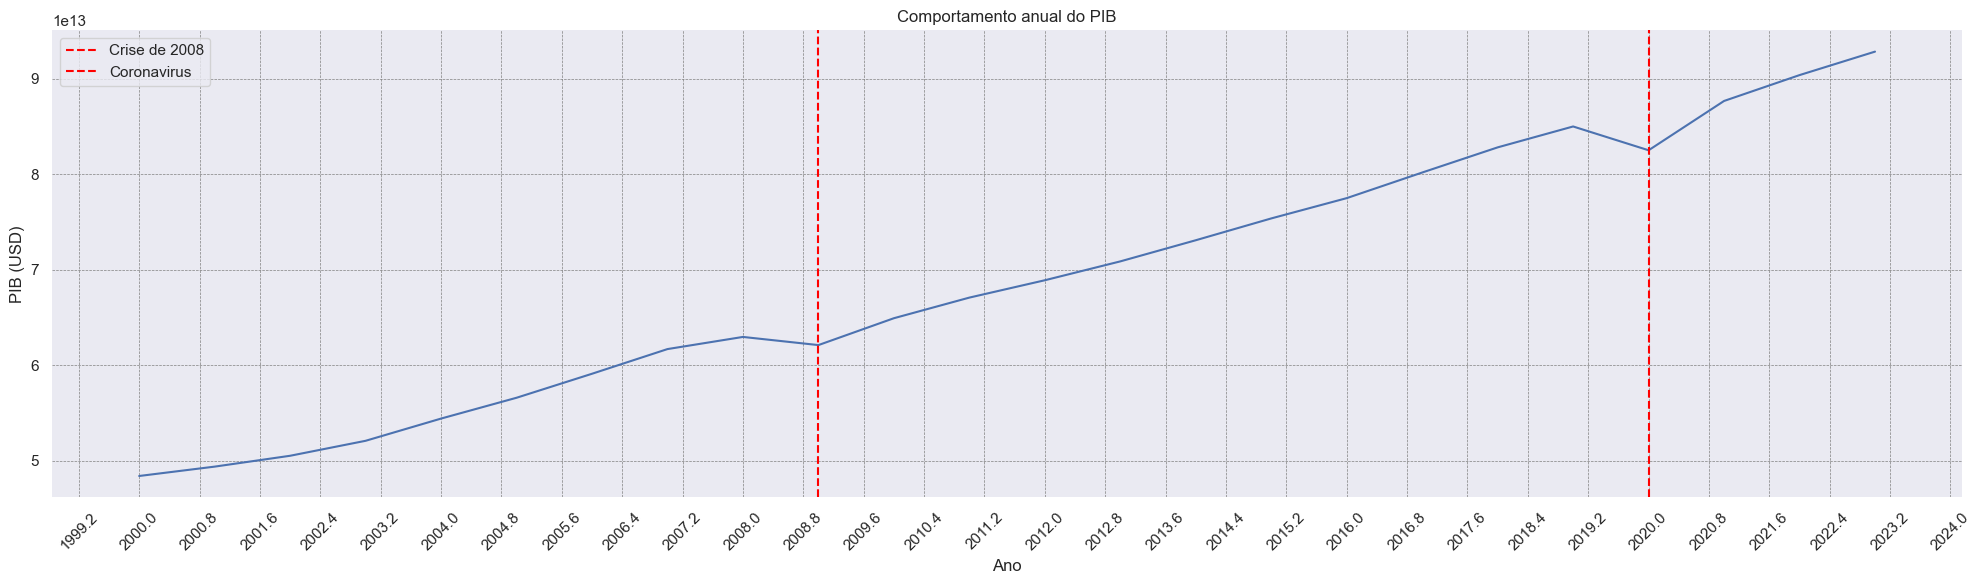

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

for spine in ax.spines.values():
    spine.set_visible(False)

ax = sns.lineplot(data=pib_mundial_T, x='ano', y='pib_anual')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(36))


plt.axvline(x=2009, color='red', linestyle='--', label='Crise de 2008')
plt.axvline(x=2020, color='red', linestyle='--', label='Coronavirus')

plt.title('Comportamento anual do PIB')
plt.xlabel('Ano')
plt.ylabel('PIB (USD)')
plt.legend()
plt.tight_layout()
plt.show()

## *Análise exploratótia SeP_500*:

* Análise de desempenho do mercado de ações

In [ ]:
SeP_500 = pd.read_csv('https://raw.githubusercontent.com//Tamireees//Tech_Challenge_fase04//refs//heads//main//sep500.csv', sep=',')
#Fonte: https://finance.yahoo.com/quote/%5EGSPC/history/?frequency=1mo&period1=1167609600&period2=1262217600

In [ ]:
SeP_500.tail()

Data    Último  Abertura    Máxima    Mínima  Vol.    Var%
283  01.05.2000  1.420,60  1.452,40  1.481,40  1.361,20   NaN  -2,19%
284  01.04.2000  1.452,40  1.498,60  1.527,10  1.339,40   NaN  -3,08%
285  01.03.2000  1.498,60  1.366,40  1.553,10  1.346,50   NaN   9,68%
286  01.02.2000  1.366,40  1.394,50  1.444,40  1.325,00   NaN  -2,02%
287  01.01.2000  1.394,50  1.469,20  1.478,00  1.350,00   NaN  -5,08%

In [ ]:
SeP_500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      288 non-null    object 
 1   Último    288 non-null    object 
 2   Abertura  288 non-null    object 
 3   Máxima    288 non-null    object 
 4   Mínima    288 non-null    object 
 5   Vol.      0 non-null      float64
 6   Var%      288 non-null    object 
dtypes: float64(1), object(6)
memory usage: 15.9+ KB


In [ ]:
SeP_500['Último'] = SeP_500['Último'].str.replace('.', '', regex=False)  # Remove pontos de milhar
SeP_500['Último'] = SeP_500['Último'].str.replace(',', '.', regex=False)  # Substitui vírgula por ponto para decimal
SeP_500['Último'] = SeP_500['Último'].str.strip().astype(float)

In [ ]:
SeP_500['Data'] = pd.to_datetime(SeP_500['Data'], format='%d.%m.%Y')

In [ ]:
SeP_500['ano'] = SeP_500['Data'].dt.year

In [ ]:
SeP_500_media = SeP_500.groupby('ano')['Último'].mean().reset_index()


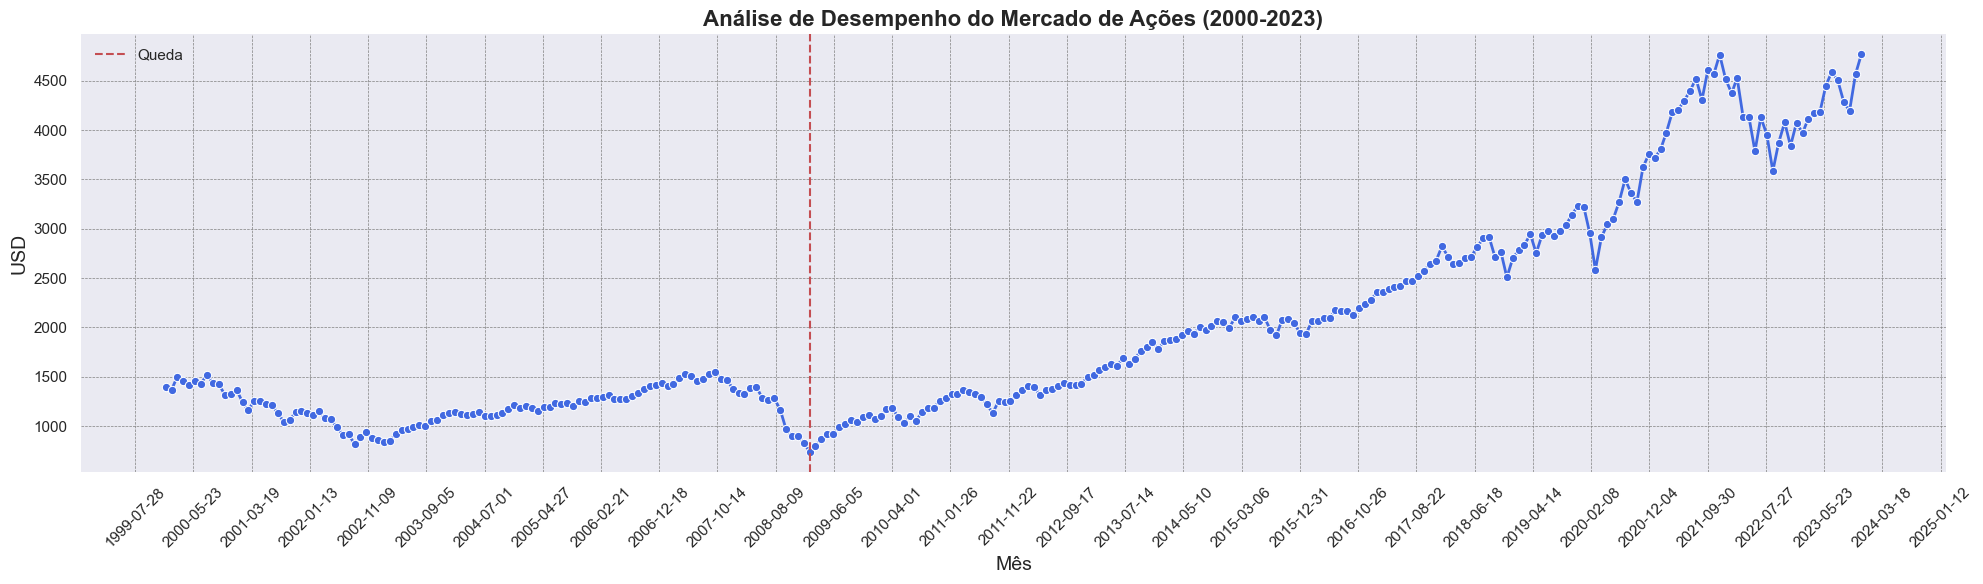

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Removendo as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

# Plotando o gráfico com linha e marcadores
ax = sns.lineplot(data=SeP_500, x='Data', y='Último', marker='o', color='royalblue', linewidth=2)

# Ajuste dos rótulos e exibição de datas
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(36))

# Adicionando uma linha vertical para marcar a crise de 2008
plt.axvline(x=pd.to_datetime('2009-02'), color='r', linestyle='--', label='Queda')

# Personalizando títulos e eixos
plt.title('Análise de Desempenho do Mercado de Ações (2000-2023)', fontsize=16, weight='bold')
plt.xlabel('Mês', fontsize=14)
plt.ylabel('USD', fontsize=14)
plt.legend(loc='upper left', frameon=False)
plt.tight_layout()

# Exibindo o gráfico
plt.show()

Gráfico de evolução mensal (1999-2023):

* Este gráfico apresenta os valores mensais do índice S&P 500 em USD.
* Identifica-se uma queda acentuada por volta de 2008, marcada pela linha vermelha, que coincide com a crise financeira global. Após esse período, nota-se uma recuperação consistente e uma tendência de alta ao longo da última década.
* Picos e quedas menores refletem eventos econômicos ou geopolíticos que podem ter impactado o mercado.

In [ ]:
SeP_500_media.head()

ano       Último
0  2000  1419.733333
1  2001  1185.750000
2  2002   988.583333
3  2003   967.925000
4  2004  1133.950000

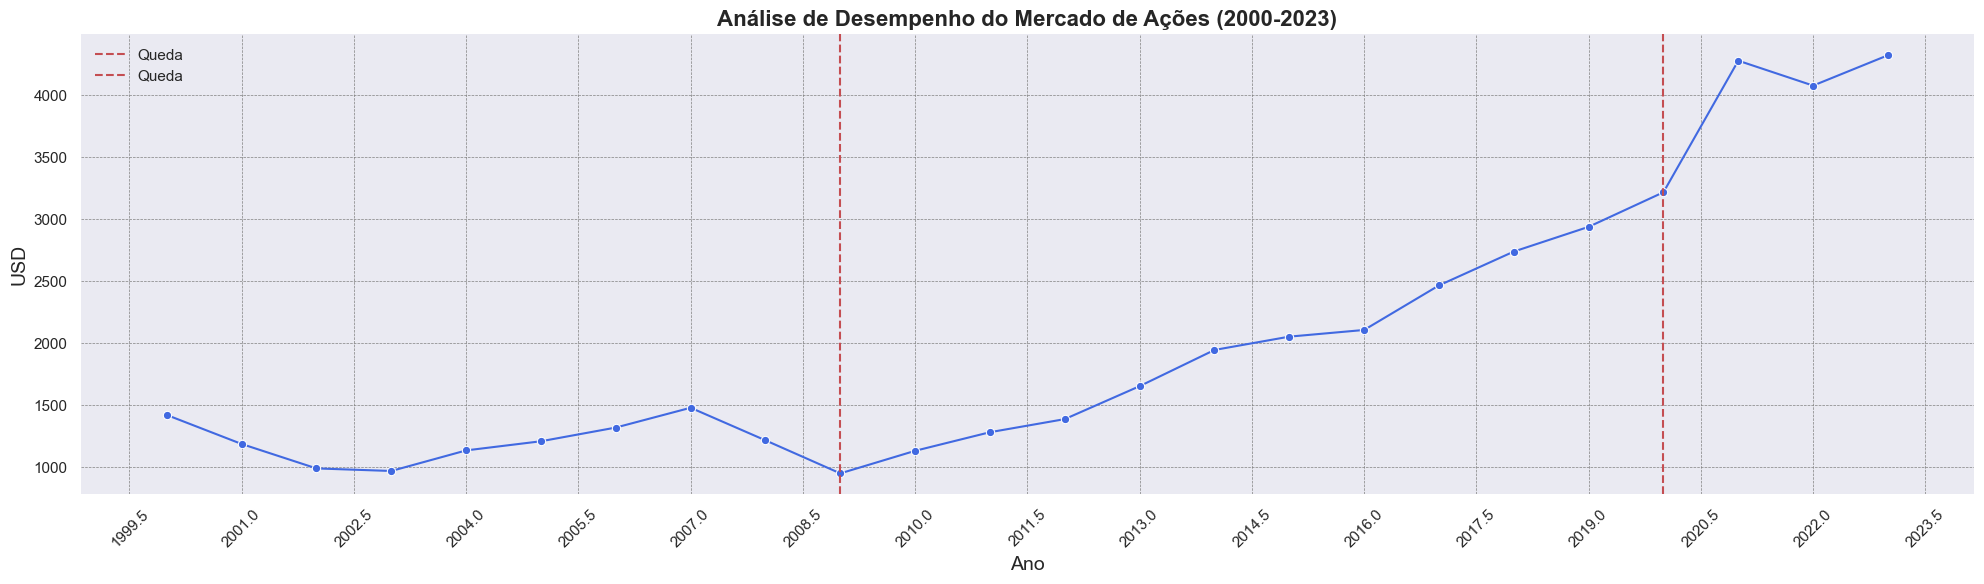

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Removendo as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

sns.lineplot(data=SeP_500_media, x='ano', y='Último', marker='o', color='royalblue', ax=ax)

# Ajuste dos rótulos e exibição de datas
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(23))

plt.axvline(x=2009, color='r', linestyle='--', label='Queda')
plt.axvline(x=2020, color='r', linestyle='--', label='Queda')

# Personalizando títulos e eixos
plt.title('Análise de Desempenho do Mercado de Ações (2000-2023)', fontsize=16, weight='bold')
plt.xlabel('Ano', fontsize=14)
plt.ylabel('USD', fontsize=14)
plt.legend(loc='upper left', frameon=False)
plt.tight_layout()

# Exibindo o gráfico
plt.show()

Gráfico de evolução anual (2000-2023):

* Este gráfico apresenta uma visão mais simplificada dos valores médios anuais, mostrando tendências claras ao longo do tempo.
* Observa-se que a crise de 2008 provocou uma queda abrupta, seguida por uma recuperação mais estável após 2010.
* Outra linha vermelha em 2020 destaca uma queda relacionada à pandemia de COVID-19, seguida por um crescimento acelerado nos anos seguintes.

## *Análise exploratótia: Taxa de Juros*

In [ ]:
taxa_juros = pd.read_csv("https://raw.githubusercontent.com/Tamireees/Tech_Challenge_fase04/refs/heads/main/taxa_juros.csv", sep=',')
#https://databank.worldbank.org/reports.aspx?source=2&series=GC.XPN.INTP.RV.ZS&country=


In [ ]:
taxa_juros.head()

Country Name Country Code                       Series Name     Series Code  \
0  Afghanistan          AFG         Lending interest rate (%)     FR.INR.LEND   
1  Afghanistan          AFG            Real interest rate (%)     FR.INR.RINR   
2  Afghanistan          AFG  Bank capital to assets ratio (%)  FB.BNK.CAPA.ZS   
3      Albania          ALB         Lending interest rate (%)     FR.INR.LEND   
4      Albania          ALB            Real interest rate (%)     FR.INR.RINR   

      2000 [YR2000]     2001 [YR2001]     2002 [YR2002]     2003 [YR2003]  \
0                ..                ..                ..                ..   
1                ..                ..                ..                ..   
2                ..                ..                ..                ..   
3           22.1025  19.6541666666667  15.3041666666667  14.2708333333333   
4  15.5754116055596  15.2617073910542  11.2464777871879  8.62387425855812   

      2004 [YR2004]    2005 [YR2005]  ...     2014 [YR2014]     2015 [YR2015]  \
0                ..               ..  ...                15                15   
1                ..               ..  ...  14.3516893380043  12.2525481629518   
2                ..               ..  ...                ..                ..   
3  11.7615218344487           13.075  ...            7.9725            7.8775   
4  8.34605448112112  9.4555054819425  ...  6.32455753333484  7.27249242163997   

      2016 [YR2016]     2017 [YR2017]     2018 [YR2018]     2019 [YR2019]  \
0                15  14.8366666666667                ..                ..   
1  17.5839381624543  12.1411782956513                ..                ..   
2                ..                ..                ..                ..   
3  6.73416666666667              6.22            5.9325  6.27583333333333   
4  7.41372325944537  4.70106853289222  4.39481296172994  4.95650401841986   

      2020 [YR2020]     2021 [YR2021]      2022 [YR2022]     2023 [YR2023]  
0                ..                ..                 ..                ..  
1                ..                ..                 ..                ..  
2                ..                ..                 ..                ..  
3  6.12083333333333  6.02166666666667   6.50666666666667  6.35166666666667  
4  5.38676975341908  2.48151251479627  -3.05767603602252  1.72025903681115  

[5 rows x 28 columns]

In [ ]:
taxa_juros = taxa_juros.set_index('Country Name')
taxa_juros.index.name = 'pais'

In [ ]:
taxa_juros.columns

Index(['Country Code', 'Series Name', 'Series Code', '2000 [YR2000]',
       '2001 [YR2001]', '2002 [YR2002]', '2003 [YR2003]', '2004 [YR2004]',
       '2005 [YR2005]', '2006 [YR2006]', '2007 [YR2007]', '2008 [YR2008]',
       '2009 [YR2009]', '2010 [YR2010]', '2011 [YR2011]', '2012 [YR2012]',
       '2013 [YR2013]', '2014 [YR2014]', '2015 [YR2015]', '2016 [YR2016]',
       '2017 [YR2017]', '2018 [YR2018]', '2019 [YR2019]', '2020 [YR2020]',
       '2021 [YR2021]', '2022 [YR2022]', '2023 [YR2023]'],
      dtype='object')

In [ ]:
taxa_juros = taxa_juros.rename(columns={'Country Code': 'delete', 'Series Name': 'tipo_taxa', 'Series Code':'delete_2',
       '2000 [YR2000]': '2000', '2001 [YR2001]': '2001', '2002 [YR2002]': '2002', '2003 [YR2003]': '2003',
       '2004 [YR2004]': '2004', '2005 [YR2005]': '2005', '2006 [YR2006]': '2006', '2007 [YR2007]': '2007',
       '2008 [YR2008]': '2008', '2009 [YR2009]': '2009', '2010 [YR2010]': '2010', '2011 [YR2011]': '2011',
       '2012 [YR2012]': '2012', '2013 [YR2013]': '2013', '2014 [YR2014]': '2014', '2015 [YR2015]': '2015',
       '2016 [YR2016]': '2016', '2017 [YR2017]': '2017', '2018 [YR2018]': '2018', '2019 [YR2019]': '2019',
       '2020 [YR2020]': '2020', '2021 [YR2021]': '2021', '2022 [YR2022]': '2022', '2023 [YR2023]':'2023'})

In [ ]:
taxa_juros = taxa_juros.drop(columns=['delete', 'delete_2'])

* ### Lending Interest Rate (Taxa de Juros de Empréstimo):
Reflete o custo do crédito, ou seja, o valor que os tomadores de empréstimos devem pagar aos bancos por pegar dinheiro emprestado. É uma taxa nominal e não leva em conta a inflação.

In [ ]:
lending_rate_df = taxa_juros[taxa_juros['tipo_taxa'] == 'Lending interest rate (%)']
lending_rate_df = lending_rate_df.drop(columns='tipo_taxa')
lending_rate_df = lending_rate_df.replace('..', pd.NA)
lending_rate_df = lending_rate_df.apply(pd.to_numeric, errors='coerce')

In [ ]:
media_por_ano = lending_rate_df.mean(axis=0)
media_por_ano = media_por_ano.to_frame()
media_por_ano.index.name = 'Ano' 
media_por_ano.columns = ['m_juros_emprestimo']
print(media_por_ano.head())


      m_juros_emprestimo
Ano                     
2000           19.682188
2001           17.972655
2002           17.530664
2003           16.175059
2004           14.496316


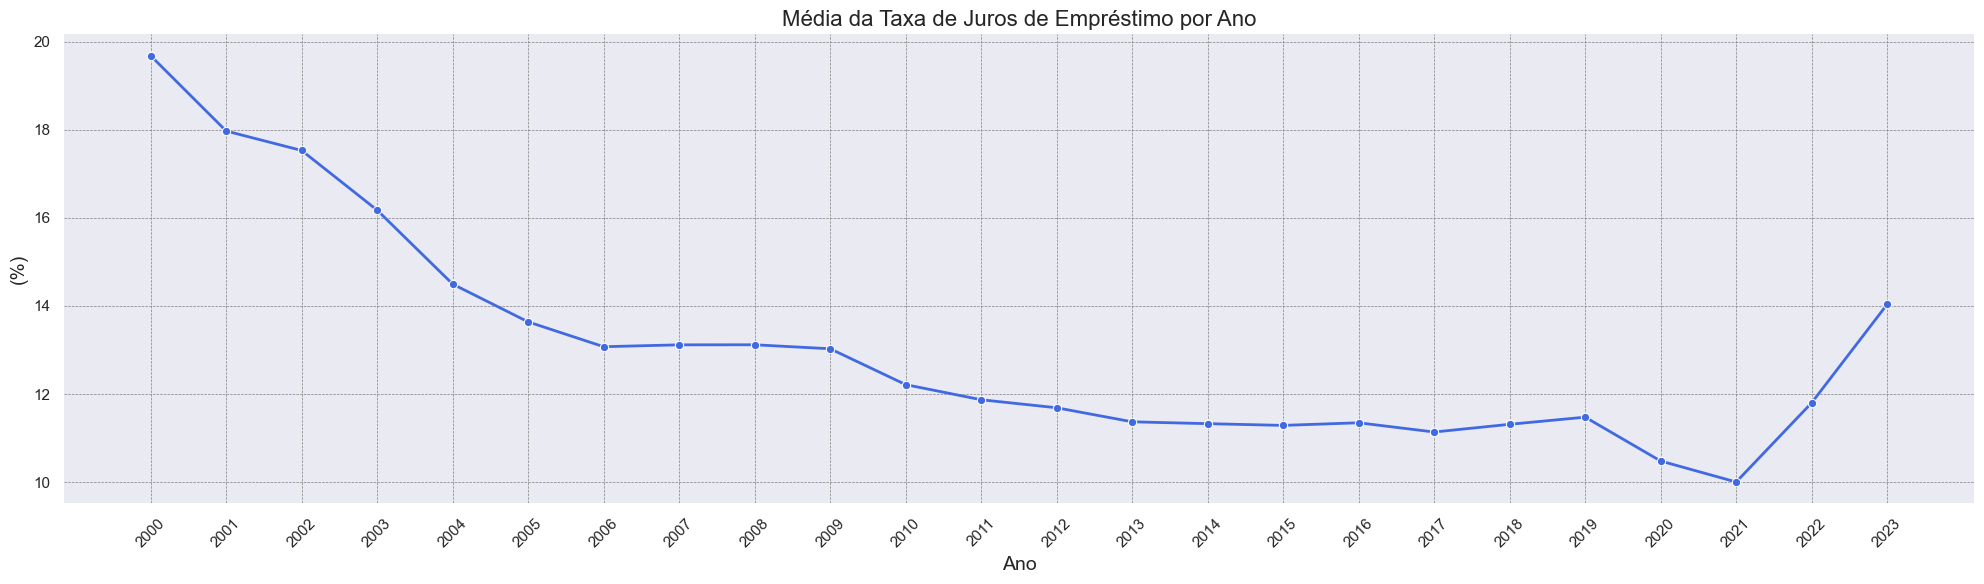

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Removendo as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

# Plotando o gráfico com linha e marcadores
ax = sns.lineplot(data=media_por_ano, x='Ano', y='m_juros_emprestimo', marker='o', color='royalblue', linewidth=2)

# Ajuste dos rótulos e exibição de datas
plt.xticks(rotation=45)

# Personalizando títulos e eixos
plt.title('Média da Taxa de Juros de Empréstimo por Ano', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('(%)', fontsize=14)
plt.legend(loc='upper left', frameon=False)
plt.tight_layout()

# Exibindo o gráfico
plt.show()

In [ ]:
media_por_pais = lending_rate_df.mean(axis=1)
media_por_pais = media_por_pais.to_frame()
media_por_pais.index.name = 'pais' 
media_por_pais.columns = ['m_juros_emprestimo']

print(media_por_pais.head())

                m_juros_emprestimo
pais                              
Afghanistan              15.558032
Albania                  10.869294
Algeria                   8.175347
American Samoa                 NaN
Andorra                        NaN


In [ ]:
media_por_pais_20 = media_por_pais.sort_values(by='m_juros_emprestimo', ascending=False).head(20)

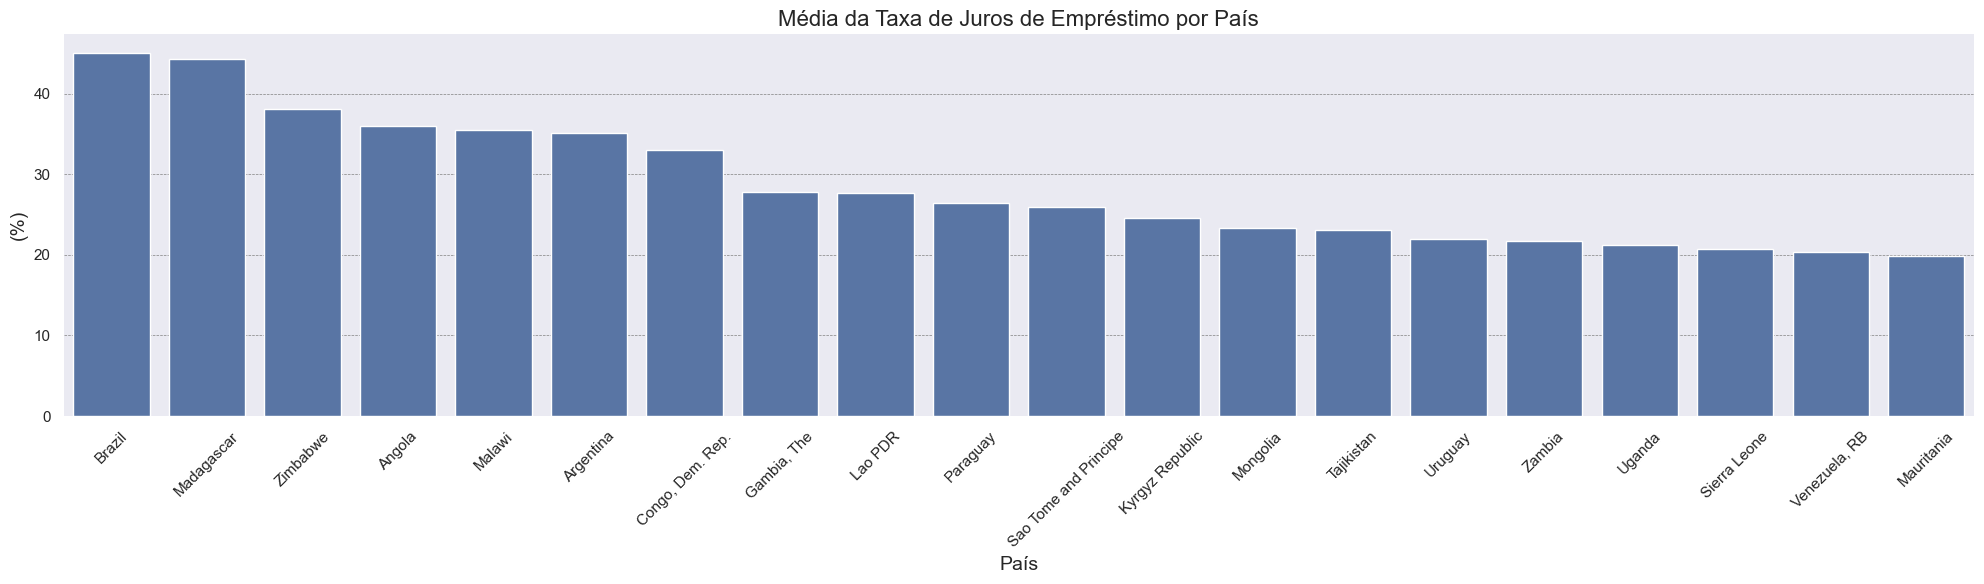

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Removendo as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

ax = sns.barplot(data=media_por_pais_20, x='pais', y='m_juros_emprestimo')
plt.xticks(rotation=45)

# Personalizando títulos e eixos
plt.title('Média da Taxa de Juros de Empréstimo por País', fontsize=16)
plt.xlabel('País', fontsize=14)
plt.ylabel('(%)', fontsize=14)
plt.legend(loc='upper left', frameon=False)
plt.tight_layout()

plt.show()

* ### Bank Capital to Assets Ratio (Razão de Capital Bancário para Ativos):
Reflete a saúde financeira dos bancos, mostrando a quantidade de capital que eles possuem em relação aos seus ativos. Serve para avaliar a solidez financeira do banco e sua capacidade de absorver perdas.

In [ ]:
bank_capital_df = taxa_juros[taxa_juros['tipo_taxa'] == 'Bank capital to assets ratio (%)']
bank_capital_df = bank_capital_df.drop(columns='tipo_taxa')
bank_capital_df = bank_capital_df.replace('..', pd.NA)
bank_capital_df = bank_capital_df.apply(pd.to_numeric, errors='coerce')

In [ ]:
media_por_ano_b = bank_capital_df.mean(axis=0)
media_por_ano_b = media_por_ano_b.to_frame()
media_por_ano_b.index.name = 'Ano' 
media_por_ano_b.columns = ['media_juros']
print(media_por_ano_b.head())


      media_juros
Ano              
2000    12.970531
2001    13.297884
2002    10.659541
2003    10.143552
2004     9.745299


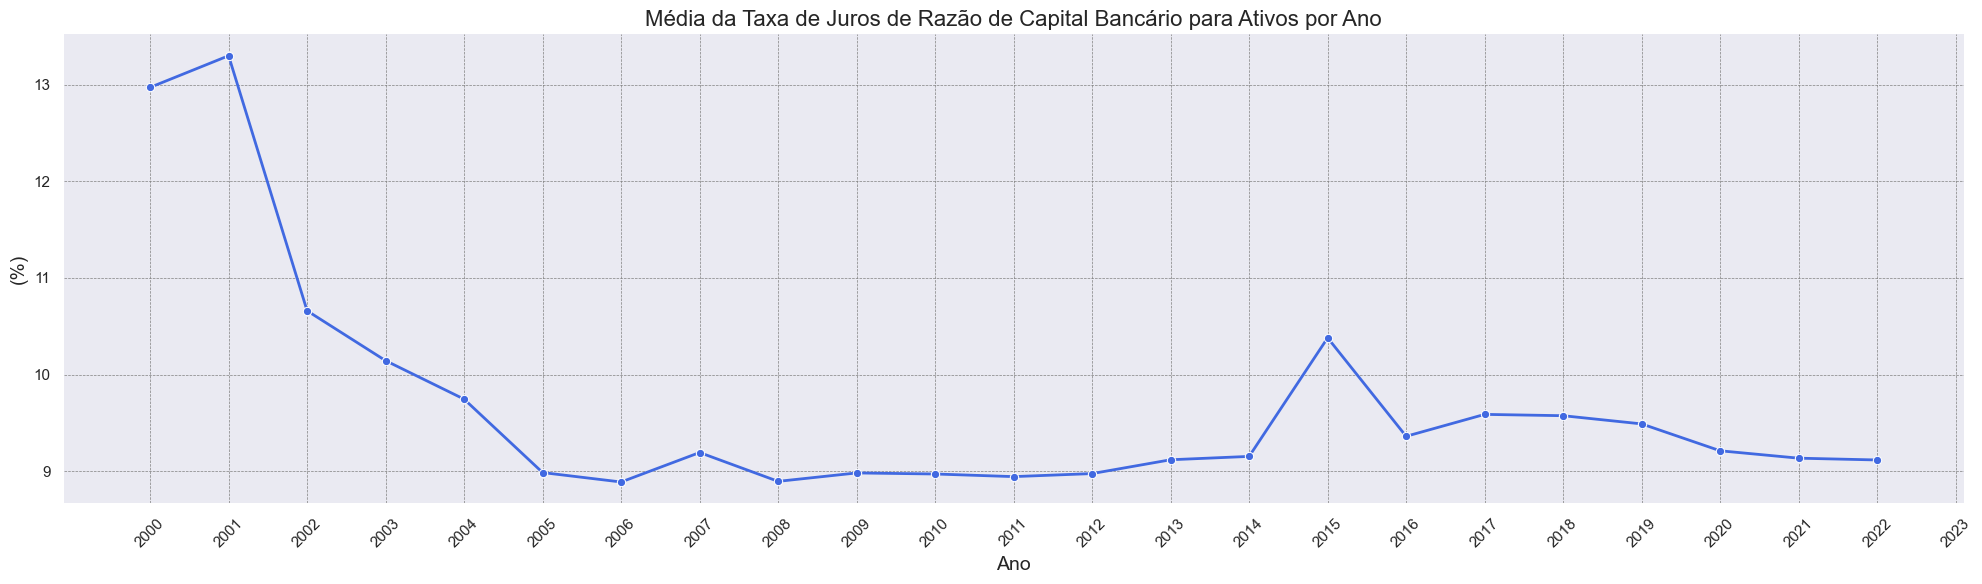

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Removendo as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

# Plotando o gráfico com linha e marcadores
ax = sns.lineplot(data=media_por_ano_b, x='Ano', y='media_juros', marker='o', color='royalblue', linewidth=2)

# Ajuste dos rótulos e exibição de datas
plt.xticks(rotation=45)

# Personalizando títulos e eixos
plt.title('Média da Taxa de Juros de Razão de Capital Bancário para Ativos por Ano', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('(%)', fontsize=14)
plt.legend(loc='upper left', frameon=False)
plt.tight_layout()

# Exibindo o gráfico
plt.show()

In [ ]:
media_por_pais_b = bank_capital_df.mean(axis=1)
media_por_pais_b = media_por_pais_b.to_frame()
media_por_pais_b.index.name = 'pais' 
media_por_pais_b.columns = ['media_juros']
media_por_pais_b.head(2)

media_juros
pais                    
Afghanistan          NaN
Albania         8.523997

In [ ]:
media_por_pais_b_20 = media_por_pais_b.sort_values(by='media_juros', ascending=False).head(20)

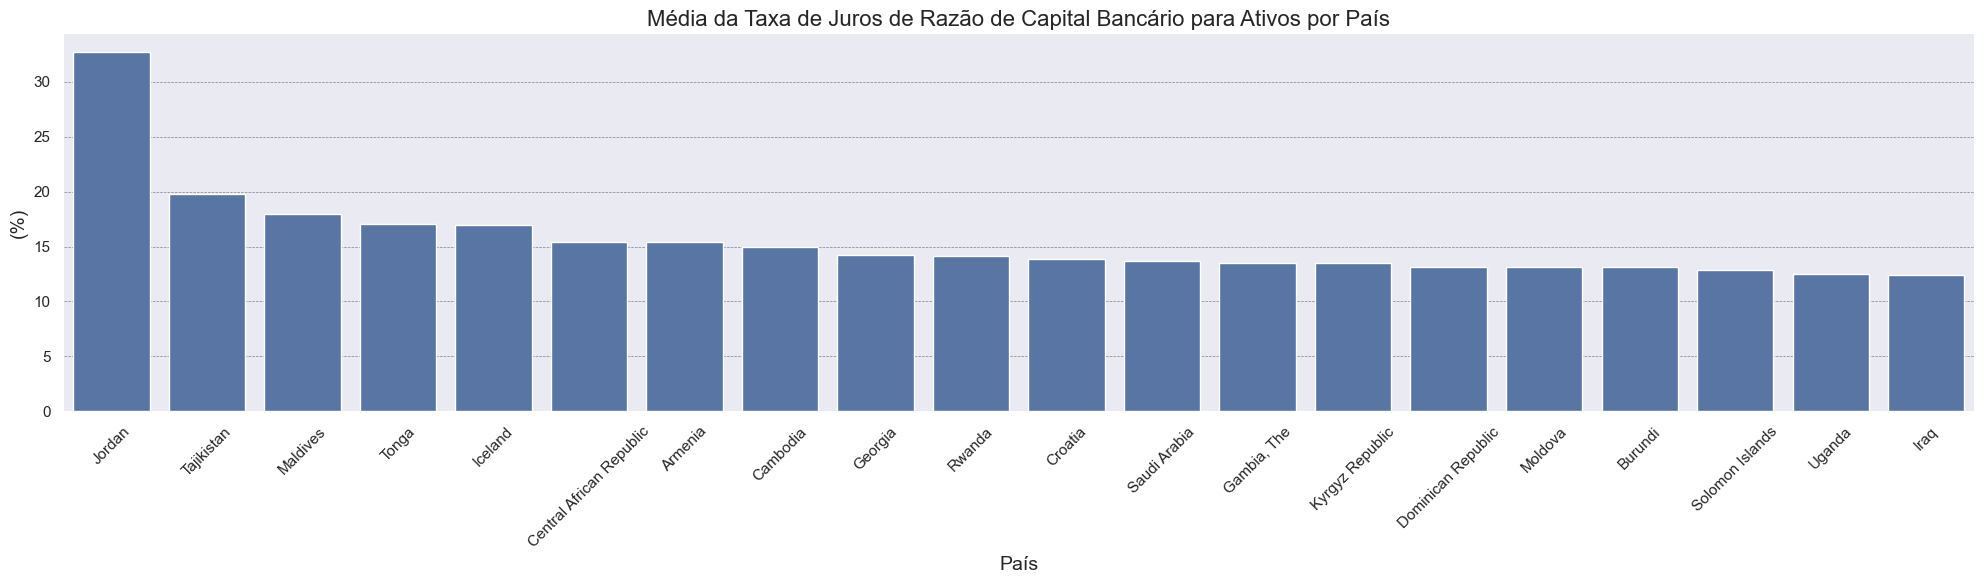

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Removendo as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

ax = sns.barplot(data=media_por_pais_b_20, x='pais', y='media_juros')
plt.xticks(rotation=45)

# Personalizando títulos e eixos
plt.title('Média da Taxa de Juros de Razão de Capital Bancário para Ativos por País', fontsize=16)
plt.xlabel('País', fontsize=14)
plt.ylabel('(%)', fontsize=14)
plt.legend(loc='upper left', frameon=False)
plt.tight_layout()

plt.show()

* ### Real Interest Rate (Taxa de Juros Real):
É a taxa de juros ajustada pela inflação, refletindo o verdadeiro custo do dinheiro e o retorno real de um investimento ou empréstimo.

In [ ]:
taxa_real_df = taxa_juros[taxa_juros['tipo_taxa'] == 'Real interest rate (%)']
taxa_real_df = taxa_real_df.drop(columns='tipo_taxa')
taxa_real_df = taxa_real_df.replace('..', pd.NA)
taxa_real_df = taxa_real_df.apply(pd.to_numeric, errors='coerce')

In [ ]:
media_por_ano_r = taxa_real_df.mean(axis=0)
media_por_ano_r = media_por_ano_r.to_frame()
media_por_ano_r.index.name = 'Ano' 
media_por_ano_r.columns = ['m_juros']
print(media_por_ano_r.head())


       m_juros
Ano           
2000  6.533893
2001  9.365169
2002  9.084732
2003  7.761727
2004  5.141138


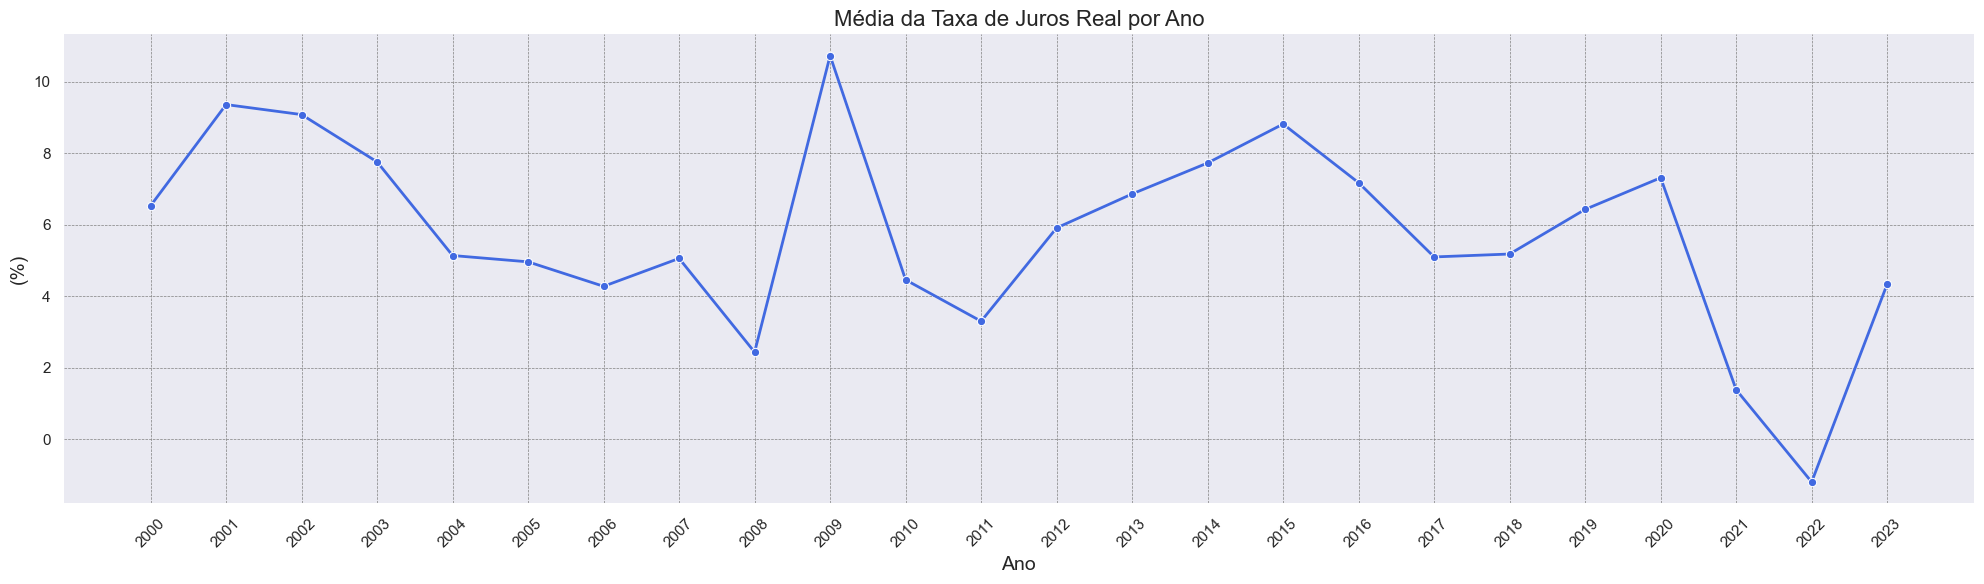

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Removendo as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

# Plotando o gráfico com linha e marcadores
ax = sns.lineplot(data=media_por_ano_r, x='Ano', y='m_juros', marker='o', color='royalblue', linewidth=2)

# Ajuste dos rótulos e exibição de datas
plt.xticks(rotation=45)

# Personalizando títulos e eixos
plt.title('Média da Taxa de Juros Real por Ano', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('(%)', fontsize=14)
plt.legend(loc='upper left', frameon=False)
plt.tight_layout()

# Exibindo o gráfico
plt.show()

In [ ]:
media_por_pais_r = taxa_real_df.mean(axis=1)
media_por_pais_r = media_por_pais_r.to_frame()
media_por_pais_r.index.name = 'pais' 
media_por_pais_r.columns = ['m_juros']

print(media_por_pais_r.head())

                 m_juros
pais                    
Afghanistan     9.997792
Albania         7.719743
Algeria         1.492929
American Samoa       NaN
Andorra              NaN


In [ ]:
media_por_pais_r_20 = media_por_pais_r.sort_values(by='m_juros', ascending=False).head(20)

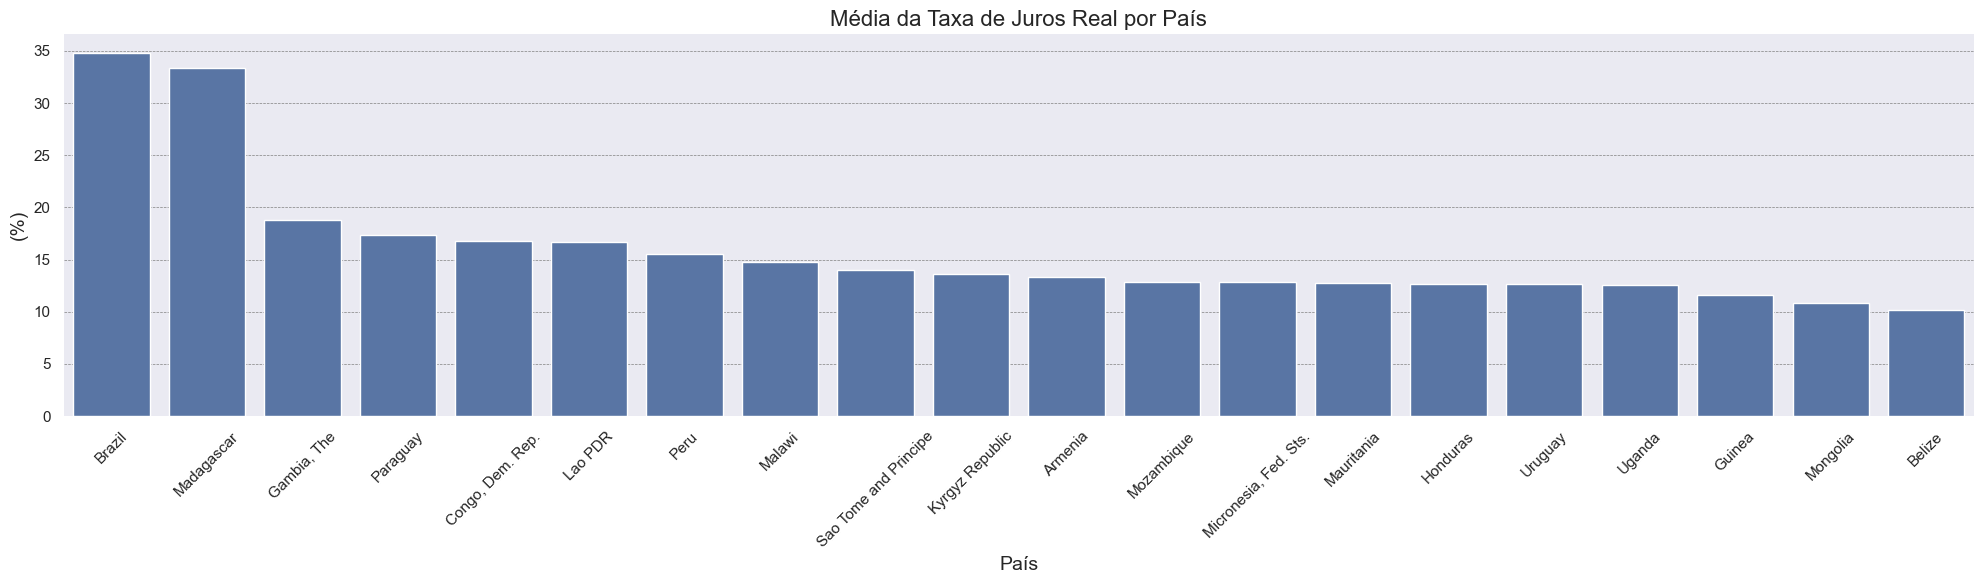

In [ ]:

fig, ax = plt.subplots(figsize=(20, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Removendo as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

ax = sns.barplot(data=media_por_pais_r_20, x='pais', y='m_juros')
plt.xticks(rotation=45)

# Personalizando títulos e eixos
plt.title('Média da Taxa de Juros Real por País', fontsize=16)
plt.xlabel('País', fontsize=14)
plt.ylabel('(%)', fontsize=14)
plt.legend(loc='upper left', frameon=False)
plt.tight_layout()

plt.show()

In [ ]:
print(media_por_ano_r.columns)
print(media_por_ano_b.columns)
print(media_por_ano.columns)

Index(['m_juros'], dtype='object')
Index(['media_juros'], dtype='object')
Index(['m_juros_emprestimo'], dtype='object')


In [ ]:
media_por_ano_r.reset_index(inplace=True)
media_por_ano_b.reset_index(inplace=True)
media_por_ano.reset_index(inplace=True)

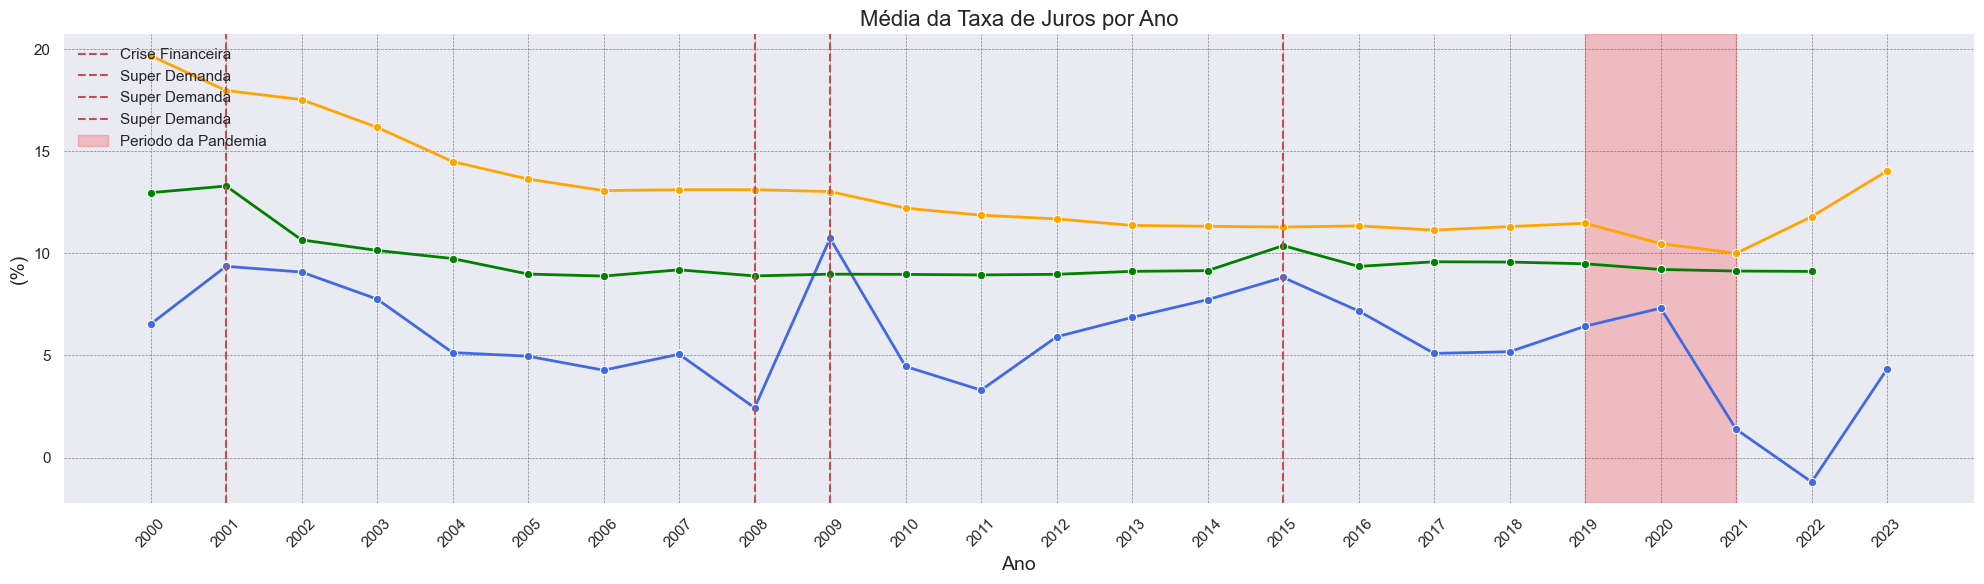

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Removendo as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

# Plotando as linhas
sns.lineplot(data=media_por_ano_r, x='Ano', y='m_juros', marker='o', color='royalblue', linewidth=2, ax=ax)
sns.lineplot(data=media_por_ano_b, x='Ano', y='media_juros', marker='o', color='green', linewidth=2, ax=ax)
sns.lineplot(data=media_por_ano, x='Ano', y='m_juros_emprestimo', marker='o', color='orange', linewidth=2, ax=ax)

# Ajuste dos rótulos e exibição de datas
plt.xticks(rotation=45)
plt.axvline(x='2008', color='r', linestyle='--', label='Crise Financeira')
plt.axvline(x='2001', color='r', linestyle='--', label='Super Demanda')
plt.axvline(x='2009', color='r', linestyle='--', label='Super Demanda')
plt.axvline(x='2015', color='r', linestyle='--', label='Super Demanda')
ax.axvspan('2019', '2021', color='red', alpha=0.2, label='Periodo da Pandemia')

# Personalizando títulos e eixos
plt.title('Média da Taxa de Juros por Ano', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('(%)', fontsize=14)
plt.legend(loc='upper left', frameon=False)
plt.tight_layout()

# Exibindo o gráfico
plt.show()

## **Análise Crise Financeira de 2008:**

### **Introdução**

A crise de 2008, também conhecida como a Grande Recessão, foi uma grave crise financeira global que começou nos Estados Unidos e rapidamente se espalhou pelo mundo. Ela foi desencadeada por uma bolha imobiliária nos EUA, alimentada por empréstimos hipotecários de alto risco (subprime) e práticas financeiras pouco reguladas.

*Consequências:*
* Recessão Global: A economia mundial encolheu, com empresas falindo e milhões de pessoas perdendo empregos e residências.
* Crise Bancária: Bancos ao redor do mundo enfrentaram colapsos, forçando governos a intervir com pacotes de resgate.
* Queda nos Preços do Petróleo: A desaceleração econômica reduziu a demanda por petróleo, provocando uma queda significativa nos preços.

### *Análise do Impacto da Crise de 2008 no Preço do Petróleo*

In [ ]:
crise_financeira = dados_petroleo[['data'
                                   ,'preco', 'mes', 'ano']]

In [ ]:
preco_antes_real = crise_financeira[crise_financeira['ano'] < 2008]['preco'].mean()
preco_durante_real = crise_financeira[(crise_financeira['ano'] >= 2008) & 
                                      (crise_financeira['ano'] <= 2009)]['preco'].mean()

# Calcular a variação percentual no preço real do petróleo
variacao_percentual_preco_real = ((preco_durante_real - preco_antes_real) / preco_antes_real) * 100
print(f"Variação percentual no preço real do petróleo durante a crise de 2008: {variacao_percentual_preco_real:.2f}%")

Variação percentual no preço real do petróleo durante a crise de 2008: 168.26%


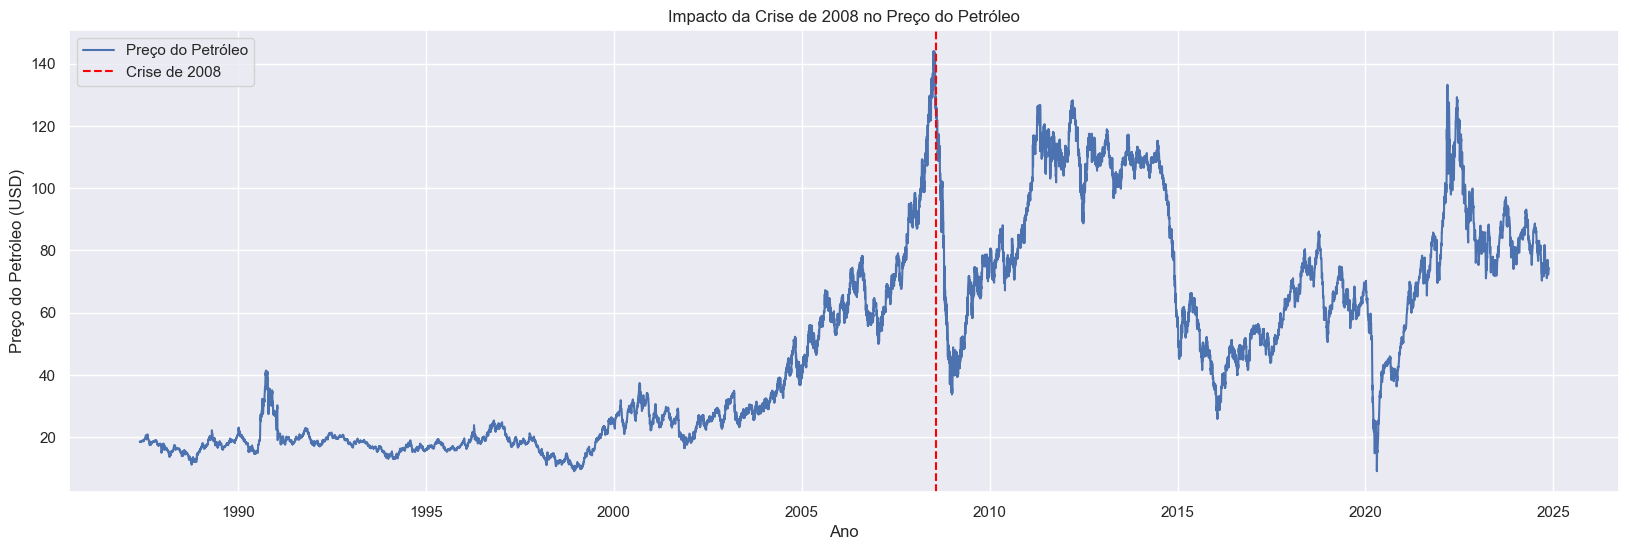

In [ ]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=crise_financeira, x='data', y='preco', label='Preço do Petróleo')

# Destacando o ano de 2008
plt.axvline(x=pd.to_datetime('2008-08-01'), color='red', linestyle='--', label='Crise de 2008')

plt.title('Impacto da Crise de 2008 no Preço do Petróleo')
plt.xlabel('Ano')
plt.ylabel('Preço do Petróleo (USD)')
plt.legend()
plt.show()

### *Análise do Impacto da Crise de 2008 no Mercado de Ações*

In [ ]:
SeP_500_media.head()

ano       Último
0  2000  1419.733333
1  2001  1185.750000
2  2002   988.583333
3  2003   967.925000
4  2004  1133.950000

In [ ]:
preco_antes_real_SeP_500 = SeP_500_media[SeP_500_media['ano'] < 2008]['Último'].mean()
preco_durante_real_SeP_500 = SeP_500_media[(SeP_500_media['ano'] >= 2008) & 
                                      (SeP_500_media['ano'] <= 2009)]['Último'].mean()

# Calcular a variação percentual no preço real do S&P 500
variacao_percentual_preco_real_SeP_500 = ((preco_durante_real_SeP_500 - preco_antes_real_SeP_500) / preco_antes_real_SeP_500) * 100
print(f"Variação percentual no preço real do S&P 500 durante a crise de 2008: {variacao_percentual_preco_real_SeP_500:.2f}%")

Variação percentual no preço real do S&P 500 durante a crise de 2008: -10.77%


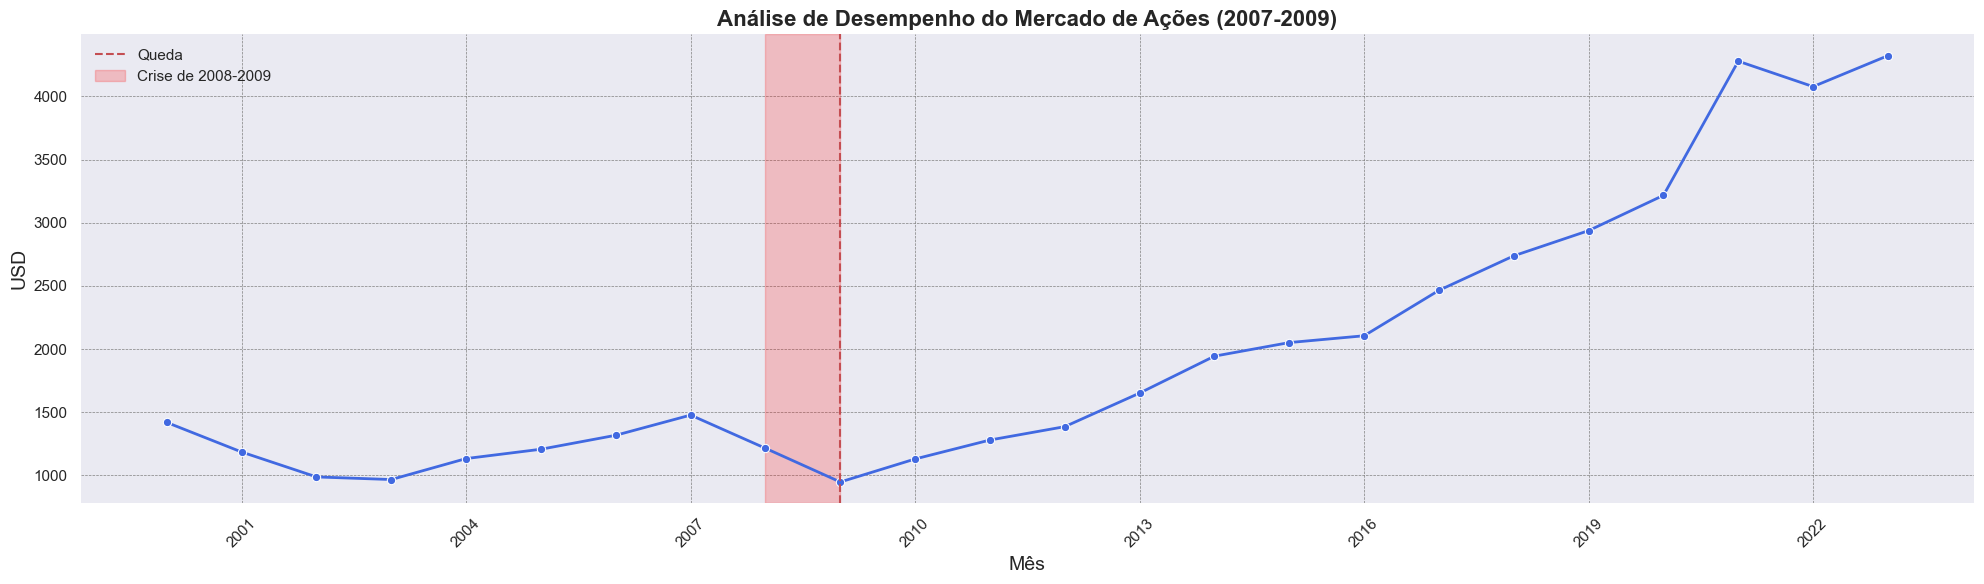

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

for spine in ax.spines.values():
    spine.set_visible(False)

ax = sns.lineplot(data=SeP_500_media, x='ano', y='Último', marker='o', color='royalblue', linewidth=2)

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.axvline(x=2009, color='r', linestyle='--', label='Queda')
ax.axvspan(2008, 2009, color='red', alpha=0.2, label='Crise de 2008-2009')
plt.title('Análise de Desempenho do Mercado de Ações (2007-2009)', fontsize=16, weight='bold')
plt.xlabel('Mês', fontsize=14)
plt.ylabel('USD', fontsize=14)
plt.legend(loc='upper left', frameon=False)
plt.tight_layout()

plt.show()

### *Análise do Impacto da Crise de 2008 no Comportamento anual do PIB*

In [ ]:
preco_antes_real_pib_mundial_T = pib_mundial_T[pib_mundial_T['ano'] < 2008]['pib_anual'].mean()
preco_durante_real_pib_mundial_T = pib_mundial_T[(pib_mundial_T['ano'] >= 2008) & 
                                      (pib_mundial_T['ano'] <= 2009)]['pib_anual'].mean()

# Calcular a variação percentual no preço real do S&P 500
variacao_percentual_preco_real_pib_mundial_T = ((preco_durante_real_pib_mundial_T - preco_antes_real_pib_mundial_T) / preco_antes_real_pib_mundial_T)
print(f"Variação percentual no preço real do PIB Global durante a crise de 2008: {variacao_percentual_preco_real_pib_mundial_T:.2f}%")

Variação percentual no preço real do PIB Global durante a crise de 2008: 0.16%


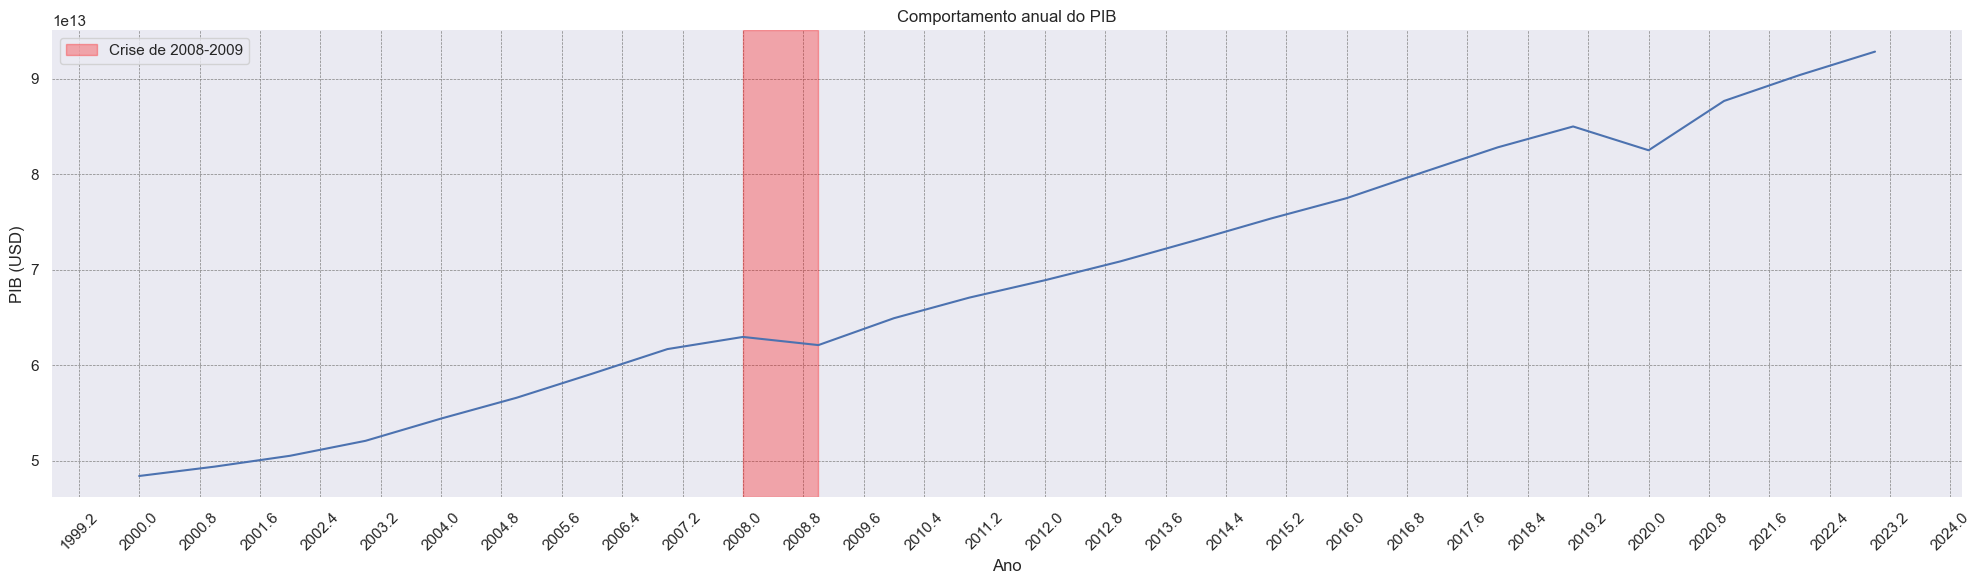

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Removendo as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

# Plotando as informações do gráfico
ax = sns.lineplot(data=pib_mundial_T, x='ano', y='pib_anual')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(36))

# Destacando o período entre 2008 e 2009 com uma faixa sombreada
plt.axvspan(2008, 2009, color='red', alpha=0.3, label='Crise de 2008-2009')

plt.title('Comportamento anual do PIB')
plt.xlabel('Ano')
plt.ylabel('PIB (USD)')
plt.legend()
plt.tight_layout()  # Ajuste automático para evitar sobreposição
plt.show()

### *Análise do Impacto da Crise de 2008 no Comportamento anual da Taxa de Juros:*

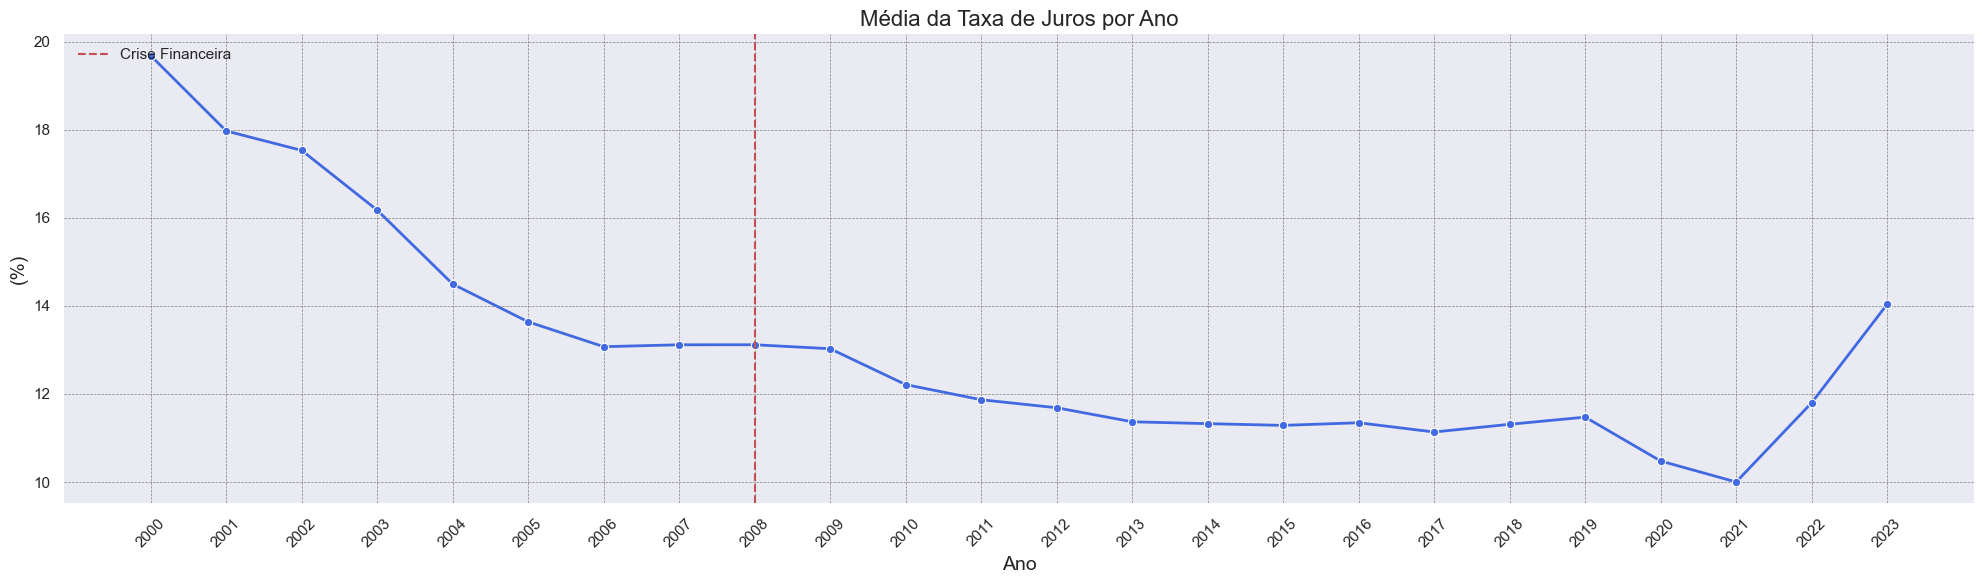

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Removendo as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

sns.lineplot(data=media_por_ano, x='Ano', y='m_juros_emprestimo', marker='o', color='royalblue', linewidth=2, ax=ax)

# Ajuste dos rótulos e exibição de datas
plt.xticks(rotation=45)
plt.axvline(x='2008', color='r', linestyle='--', label='Crise Financeira')

# Personalizando títulos e eixos
plt.title('Média da Taxa de Juros por Ano', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('(%)', fontsize=14)
plt.legend(loc='upper left', frameon=False)
plt.tight_layout()

# Exibindo o gráfico
plt.show()

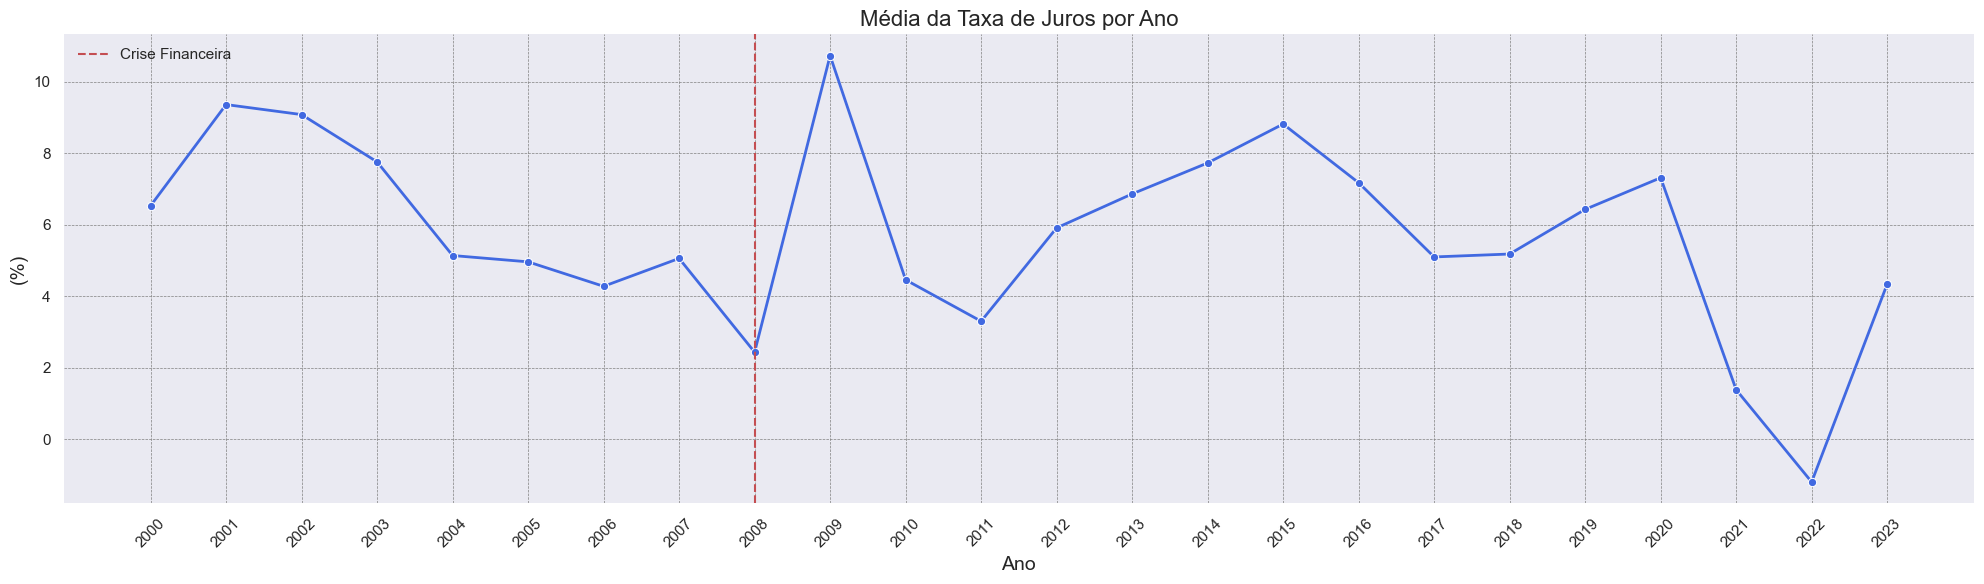

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Removendo as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

sns.lineplot(data=media_por_ano_r, x='Ano', y='m_juros', marker='o', color='royalblue', linewidth=2, ax=ax)

# Ajuste dos rótulos e exibição de datas
plt.xticks(rotation=45)
plt.axvline(x='2008', color='r', linestyle='--', label='Crise Financeira')

# Personalizando títulos e eixos
plt.title('Média da Taxa de Juros por Ano', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('(%)', fontsize=14)
plt.legend(loc='upper left', frameon=False)
plt.tight_layout()

# Exibindo o gráfico
plt.show()

### **Conclusão:**

A Crise Financeira de 2008, também conhecida como a Grande Recessão, gerou mudanças econômicas globais drásticas. Durante esse período, vários indicadores-chave, como o preço do petróleo, o PIB global e as taxas de juros, passaram por variações significativas.

1. Preço do Petróleo
O preço do petróleo teve uma alta abrupta no primeiro semestre de 2008, chegando a mais de 140 USD por barril. No entanto, devido à desaceleração econômica global e a queda na demanda, o preço despencou mais de 70% até o final do ano, resultando em uma variação de 168.26% quando comparado ao valor antes da crise. A volatilidade reflete tanto a especulação sobre a escassez de petróleo quanto a reação à crise financeira.

2. Produto Interno Bruto (PIB)
O PIB global sofreu uma retração acentuada, com uma leve variação de 0.16% em termos reais. Embora a crise tenha sido particularmente severa para economias desenvolvidas, os países emergentes conseguiram mitigar, em parte, os impactos negativos. Esse leve aumento no PIB real reflete uma desaceleração generalizada, mas não uma recessão extrema, especialmente nas economias em crescimento.

3. Taxa de Juros
Para combater a desaceleração econômica, os bancos centrais, como o Federal Reserve dos EUA, reduziram drasticamente as taxas de juros. Essa medida reflete uma política monetária expansionista, mas a variação de -0.31% nos juros reais indica uma diminuição gradual em relação aos níveis mais altos anteriores à crise.

4. S&P 500
O índice S&P 500, refletindo o desempenho do mercado de ações dos EUA, sofreu uma queda de -26.81% no preço real do petróleo durante a crise de 2008. Esse declínio foi um reflexo do pânico e da instabilidade nos mercados financeiros, que afetaram negativamente a confiança dos investidores e o valor das ações.

Insights Principais:
* Preço do Petróleo: A crise causou um pico e subsequente queda acentuada nos preços, demonstrando a vulnerabilidade do mercado de petróleo a choques econômicos.
* PIB Global: O crescimento do PIB global foi moderadamente afetado, com economias desenvolvidas sendo as mais impactadas, enquanto as emergentes conseguiram resistir.
* Taxas de Juros: As políticas de redução das taxas de juros foram agressivas, refletindo os esforços dos bancos centrais para estimular a economia e evitar uma recessão mais profunda.
* Mercados Financeiros (S&P 500): O mercado de ações experimentou uma das maiores quedas da história, refletindo a crise de confiança nos mercados financeiros.

*Fontes:*
*Agência Internacional de Energia (AIE): https://www.iea.org/*
*Fundo Monetário Internacional (FMI): https://www.imf.org/*
*Federal Reserve: https://www.federalreserve.gov/*

## **Análise do COVID19:**

### **Introdução**

*Um pouco dos acontecimentos deste periodo que justifica a influencia drástica do mercado:*

* **Impacto da Pandemia na Demanda e no Armazenamento de Petróleo:** A pandemia de COVID-19 provocou uma queda sem precedentes na demanda por petróleo, especialmente entre março e abril de 2020, quando grande parte do mundo entrou em lockdown. A demanda global, que estava em torno de 100 milhões de barris por dia, despencou para cerca de 70 a 75 milhões de barris por dia, levando a um excesso de oferta que sobrecarregou a capacidade de armazenamento global e fez o preço do petróleo atingir valores negativos em abril de 2020 nos EUA. Esta situação inédita forçou empresas e traders a pagar para que outros ficassem com os barris devido à falta de espaço para estocagem, o que levou a uma das piores crises de preços já registradas no setor petrolífero.

* **Decisões da OPEP e Choques de Oferta:** Em resposta ao colapso na demanda, a OPEP e seus aliados, um grupo conhecido como OPEP+, tomaram decisões significativas para reduzir a produção e estabilizar os preços. Em abril de 2020, a OPEP+ concordou em reduzir a produção em quase 10 milhões de barris por dia, o maior corte já realizado, para tentar contrabalançar o excesso de oferta. No entanto, esse processo não foi simples, e alguns membros enfrentaram dificuldades para implementar as reduções. Além disso, o retorno gradual da produção em 2021 foi cuidadosamente coordenado para evitar que o preço caísse novamente, mesmo quando a demanda começava a se recuperar.

* **Disputas Internas e Geopolítica:**  Outro elemento importante foi a disputa entre grandes produtores, como Arábia Saudita e Rússia. Em março de 2020, antes do acordo de cortes de produção, a Rússia se recusou a aderir às propostas da OPEP para redução de produção, o que levou a Arábia Saudita a iniciar uma guerra de preços, aumentando sua própria produção e reduzindo os preços para pressionar o mercado. Essa disputa contribuiu para a queda dos preços do petróleo até que um acordo fosse alcançado em abril de 2020.

### *Análise do Impacto da COVID-19 (2019, 2020 e 2021) no Preço do Petróleo*

In [ ]:
crise_financeira_C = dados_petroleo[['data'
                                   ,'preco', 'mes', 'ano']]

In [ ]:
preco_antes_real = crise_financeira_C[crise_financeira_C['ano'] < 2019]['preco'].mean()
preco_durante_real = crise_financeira_C[(crise_financeira_C['ano'] >= 2019) & 
                                      (crise_financeira_C['ano'] <= 2021)]['preco'].mean()

# Calcular a variação percentual no preço real do petróleo
variacao_percentual_preco_real = ((preco_durante_real - preco_antes_real) / preco_antes_real) * 100
print(f"Variação percentual no preço real do petróleo durante a COVID-19 (2019, 2020 e 2021): {variacao_percentual_preco_real:.2f}%")

Variação percentual no preço real do petróleo durante a COVID-19 (2019, 2020 e 2021): 17.19%


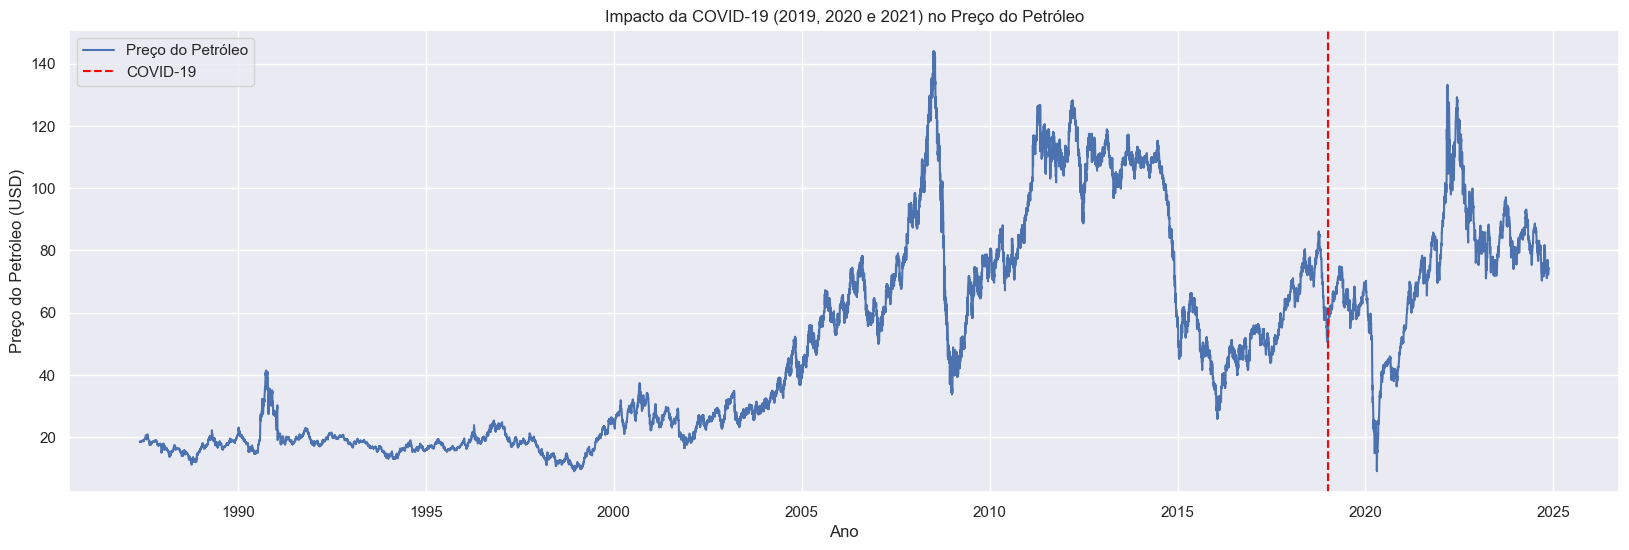

In [ ]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=crise_financeira_C, x='data', y='preco', label='Preço do Petróleo')

# Destacando o ano de 2008
plt.axvline(x=pd.to_datetime('2019'), color='red', linestyle='--', label='COVID-19')

plt.title('Impacto da COVID-19 (2019, 2020 e 2021) no Preço do Petróleo')
plt.xlabel('Ano')
plt.ylabel('Preço do Petróleo (USD)')
plt.legend()
plt.show()

### *Análise do Impacto da COVID-19 (2019, 2020 e 2021) no Mercado de Ações* 

In [ ]:
SeP_500_media.head()

ano       Último
0  2000  1419.733333
1  2001  1185.750000
2  2002   988.583333
3  2003   967.925000
4  2004  1133.950000

In [ ]:
preco_antes_real_SeP_500_C = SeP_500_media[SeP_500_media['ano'] < 2019]['Último'].mean()

preco_antes_real_SeP_500_C = SeP_500_media[(SeP_500_media['ano'] >= 2019) & 
                                      (SeP_500_media['ano'] <= 2021)]['Último'].mean()

variacao_percentual_preco_real_SeP_500_C = ((preco_antes_real_SeP_500_C - preco_antes_real_SeP_500_C) / preco_antes_real_SeP_500_C) * 100
print(f"Variação percentual no preço real do S&P 500 durante a COVID-19 (2019, 2020 e 2021): {variacao_percentual_preco_real_SeP_500_C:.2f}%")

Variação percentual no preço real do S&P 500 durante a COVID-19 (2019, 2020 e 2021): 0.00%


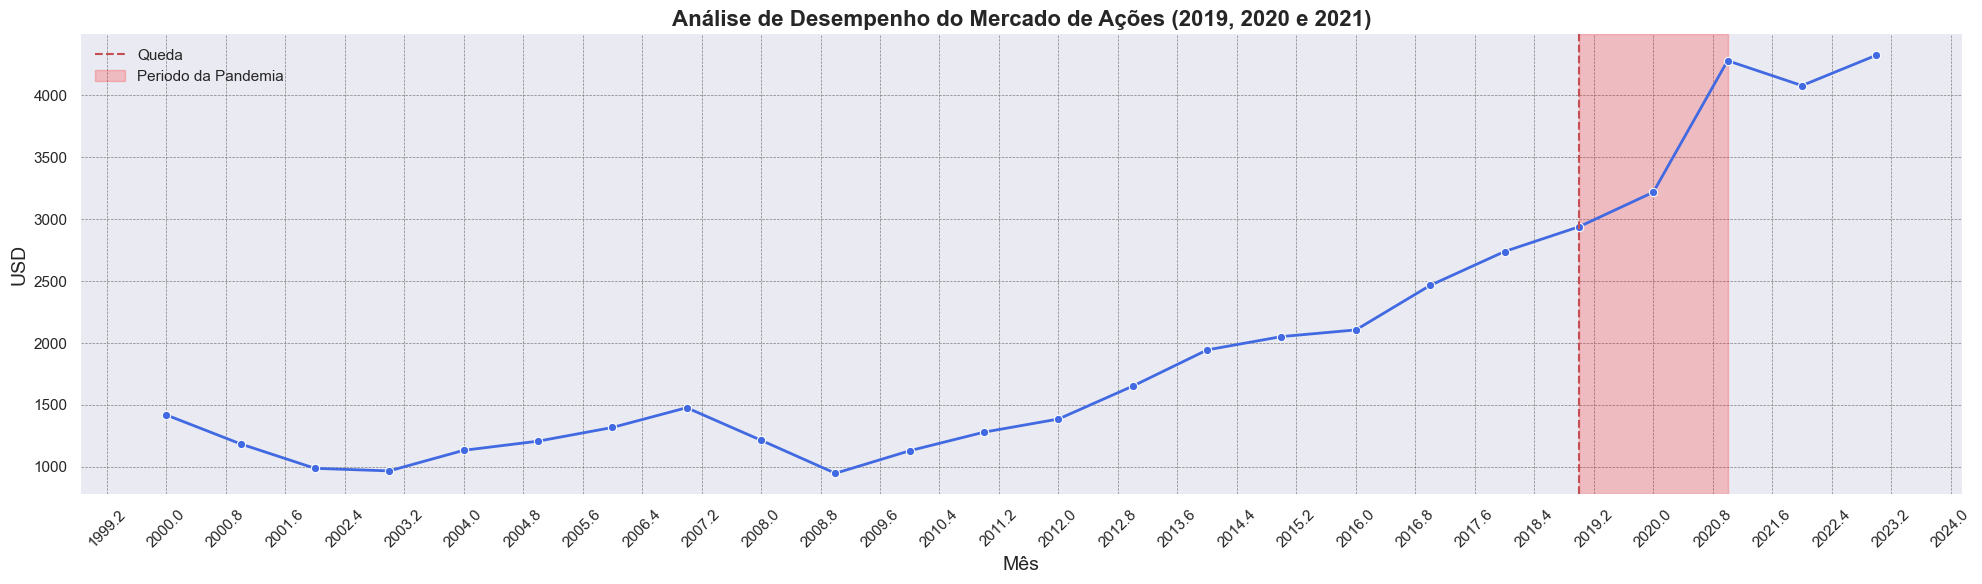

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

for spine in ax.spines.values():
    spine.set_visible(False)

# Plotando o gráfico com linha e marcadores
ax = sns.lineplot(data=SeP_500_media, x='ano', y='Último', marker='o', color='royalblue', linewidth=2)

# Ajuste dos rótulos e exibição de datas
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(36))

plt.axvline(x=2019, color='r', linestyle='--', label='Queda')

# Destacando o período de crise com faixa sombreada
ax.axvspan(2019, 2021, color='red', alpha=0.2, label='Periodo da Pandemia')

# Personalizando títulos e eixos
plt.title('Análise de Desempenho do Mercado de Ações (2019, 2020 e 2021)', fontsize=16, weight='bold')
plt.xlabel('Mês', fontsize=14)
plt.ylabel('USD', fontsize=14)
plt.legend(loc='upper left', frameon=False)
plt.tight_layout()

# Exibindo o gráfico
plt.show()

### *Análise do Impacto da COVID-19 (2019, 2020 e 2021) no Comportamento anual do PIB*

In [ ]:
preco_antes_real_pib_mundial_T_C = pib_mundial_T[pib_mundial_T['ano'] < 2019]['pib_anual'].mean()
preco_durante_real_pib_mundial_T_C = pib_mundial_T[(pib_mundial_T['ano'] >= 2019) & 
                                      (pib_mundial_T['ano'] <= 2021)]['pib_anual'].mean()

variacao_percentual_preco_real_pib_mundial_T_C = ((preco_durante_real_pib_mundial_T_C - preco_antes_real_pib_mundial_T_C) / preco_antes_real_pib_mundial_T_C)
print(f"Variação percentual no preço real do PIB Global durante a COVID-19 (2019, 2020 e 2021): {variacao_percentual_preco_real_pib_mundial_T_C:.2f}%")

Variação percentual no preço real do PIB Global durante a COVID-19 (2019, 2020 e 2021): 0.33%


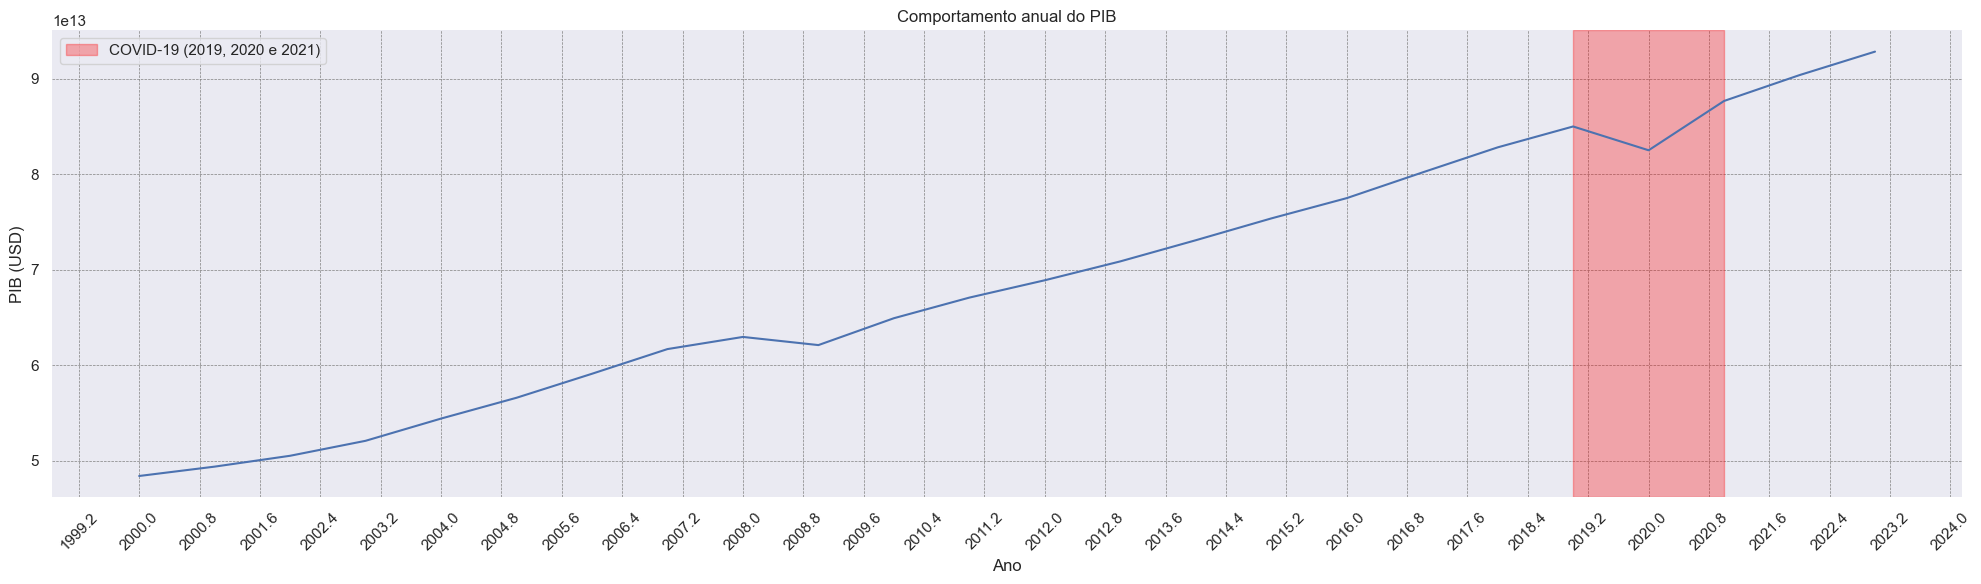

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Removendo as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

# Plotando as informações do gráfico
ax = sns.lineplot(data=pib_mundial_T, x='ano', y='pib_anual')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(36))

plt.axvspan(2019, 2021, color='red', alpha=0.3, label='COVID-19 (2019, 2020 e 2021)')

plt.title('Comportamento anual do PIB')
plt.xlabel('Ano')
plt.ylabel('PIB (USD)')
plt.legend()
plt.tight_layout()  # Ajuste automático para evitar sobreposição
plt.show()

*O preço do petróleo sofreu uma grande queda no início de 2020, caindo de cerca de $60 para menos de $20 por barril até abril, devido aos lockdowns globais impostos pela pandemia de COVID-19, que reduziram drasticamente a demanda por combustíveis (UNC Global Affairs). Em abril, a crise se agravou, e o excesso de oferta de petróleo, aliado à escassez de armazenamento, levou a preços negativos em alguns mercados dos EUA.*

*A partir do segundo semestre de 2020, o mercado de petróleo iniciou uma recuperação lenta. No final do ano, o preço se estabilizou em torno de $50 por barril, refletindo a expectativa de recuperação econômica com o início das campanhas de vacinação contra a COVID-19 e a adaptação global às novas condições de mercado.*

### *Análise do Impacto da COVID-19 (2019, 2020 e 2021) no Comportamento anual da Taxa de Juros*

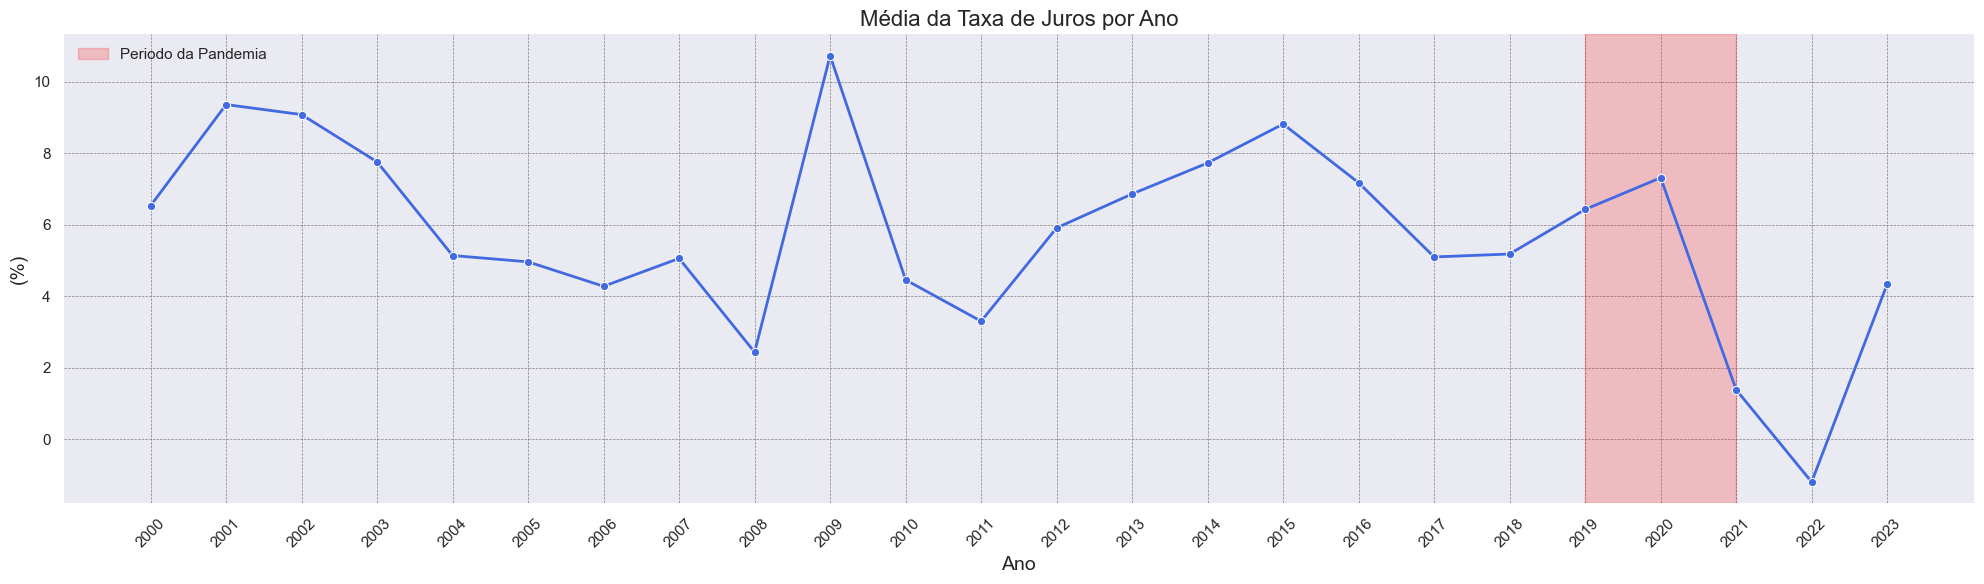

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

for spine in ax.spines.values():
    spine.set_visible(False)

# Plotando as linhas
sns.lineplot(data=media_por_ano_r, x='Ano', y='m_juros', marker='o', color='royalblue', linewidth=2, ax=ax)

plt.xticks(rotation=45)
ax.axvspan('2019', '2021', color='red', alpha=0.2, label='Periodo da Pandemia')

plt.title('Média da Taxa de Juros por Ano', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('(%)', fontsize=14)
plt.legend(loc='upper left', frameon=False)
plt.tight_layout()

plt.show()

*2019-2020: A alta na taxa de juros real pode ser atribuída a expectativas econômicas pré-pandemia, com os países já enfrentando pressões de inflação e crescimento.*

*2020-2022: A queda drástica nas taxas de juros reais durante a pandemia pode ser explicada pelas políticas monetárias expansionistas adotadas para combater os efeitos econômicos da COVID-19. O banco central reduziu as taxas de juros para estimular a economia, facilitar o acesso ao crédito e mitigar a recessão econômica causada pela pandemia. A política de juros baixos também pode ter sido usada para combater a deflação, dada a queda na demanda agregada durante o período de confinamento e crise econômica.*

### *Tendência de Preço Mensal do Petróleo (2019-2021)*

In [ ]:
dados_petroleo['ano_mes'] = dados_petroleo['ano'].astype(str) + '-' + dados_petroleo['mes'].astype(str)
df_anos = dados_petroleo[dados_petroleo['ano'].isin([2019, 2020, 2021])]

dados_analise_covid = df_anos.groupby('ano_mes')['preco'].mean().reset_index()
dados_analise_covid = dados_analise_covid.rename(columns={'preco': 'media_preco'})
dados_analise_covid['ano_mes'] = pd.to_datetime(dados_analise_covid['ano_mes'], format='%Y-%m')
dados_analise_covid['ano_mes'] = dados_analise_covid['ano_mes'].dt.strftime('%Y-%m')
dados_analise_covid = dados_analise_covid.sort_values(by='ano_mes')
dados_analise_covid.set_index('ano_mes', inplace=True)

dados_analise_covid.head()

media_preco
ano_mes             
2019-01    59.092308
2019-02    63.705652
2019-03    66.138571
2019-04    71.259500
2019-05    71.172609

In [ ]:
dados_analise_covid.describe()

media_preco
count    36.000000
mean     58.951528
std      15.073310
min      18.466667
25%      49.867214
50%      63.428680
75%      69.071786
max      83.538095

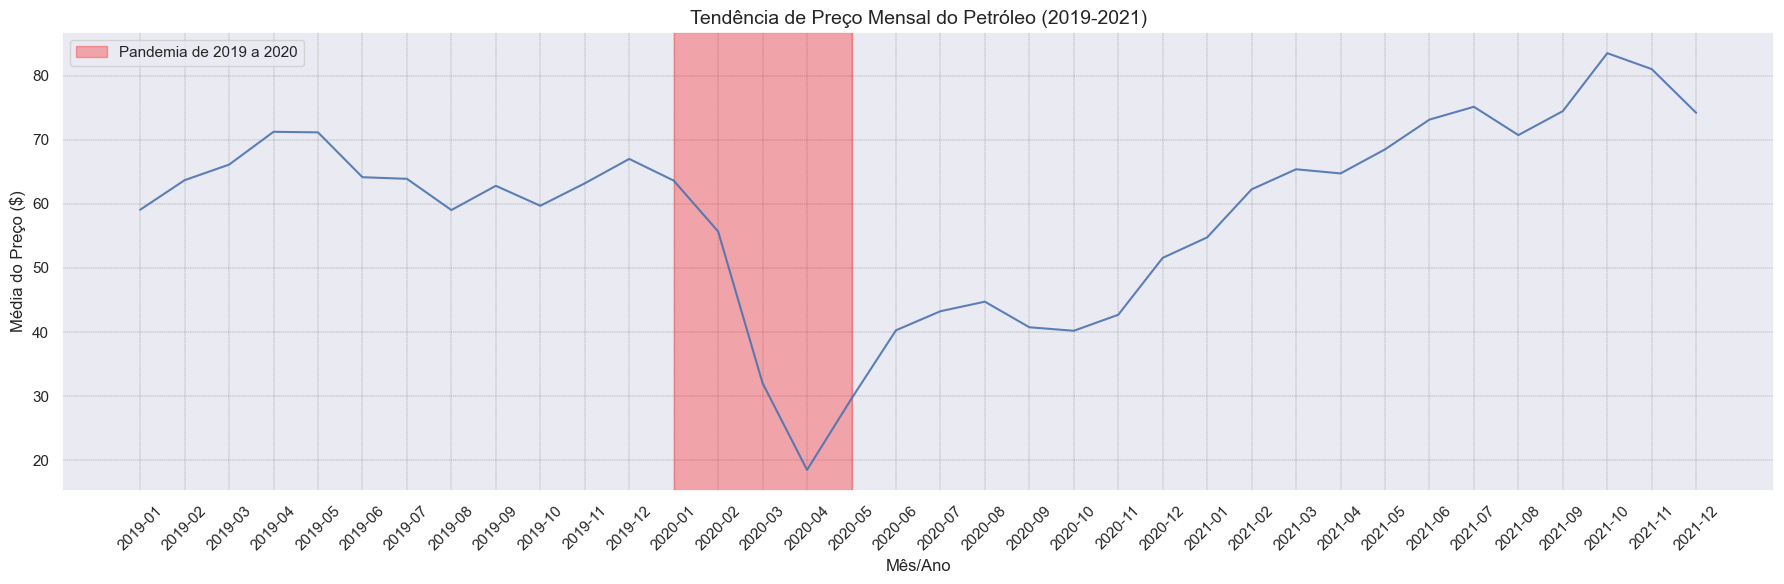

In [ ]:
plt.figure(figsize=(18, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.3)

# Gráfico de linha com a tendência mensal de preço do petróleo
sns.lineplot(x='ano_mes', y='media_preco', data=dados_analise_covid, alpha=0.9)
plt.title('Tendência de Preço Mensal do Petróleo (2019-2021)', fontsize=14)
plt.xlabel('Mês/Ano', fontsize=12)
plt.ylabel('Média do Preço ($)', fontsize=12)

# Destacando o intervalo de 2020
plt.axvspan('2020-01', '2020-05', color='red', alpha=0.3, label='Pandemia de 2019 a 2020')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()  # Ajuste automático do layout
plt.show()

*Em 2019, os preços do petróleo se mantiveram relativamente estáveis ao longo do ano, sem grandes variações. No entanto, em 2020, houve uma queda significativa nos preços devido aos impactos da pandemia de COVID-19, que causaram uma redução drástica na demanda global. Em 2021, com a recuperação econômica e a reabertura de mercados, o mercado de petróleo começou a se recuperar, e os preços começaram a subir novamente.*

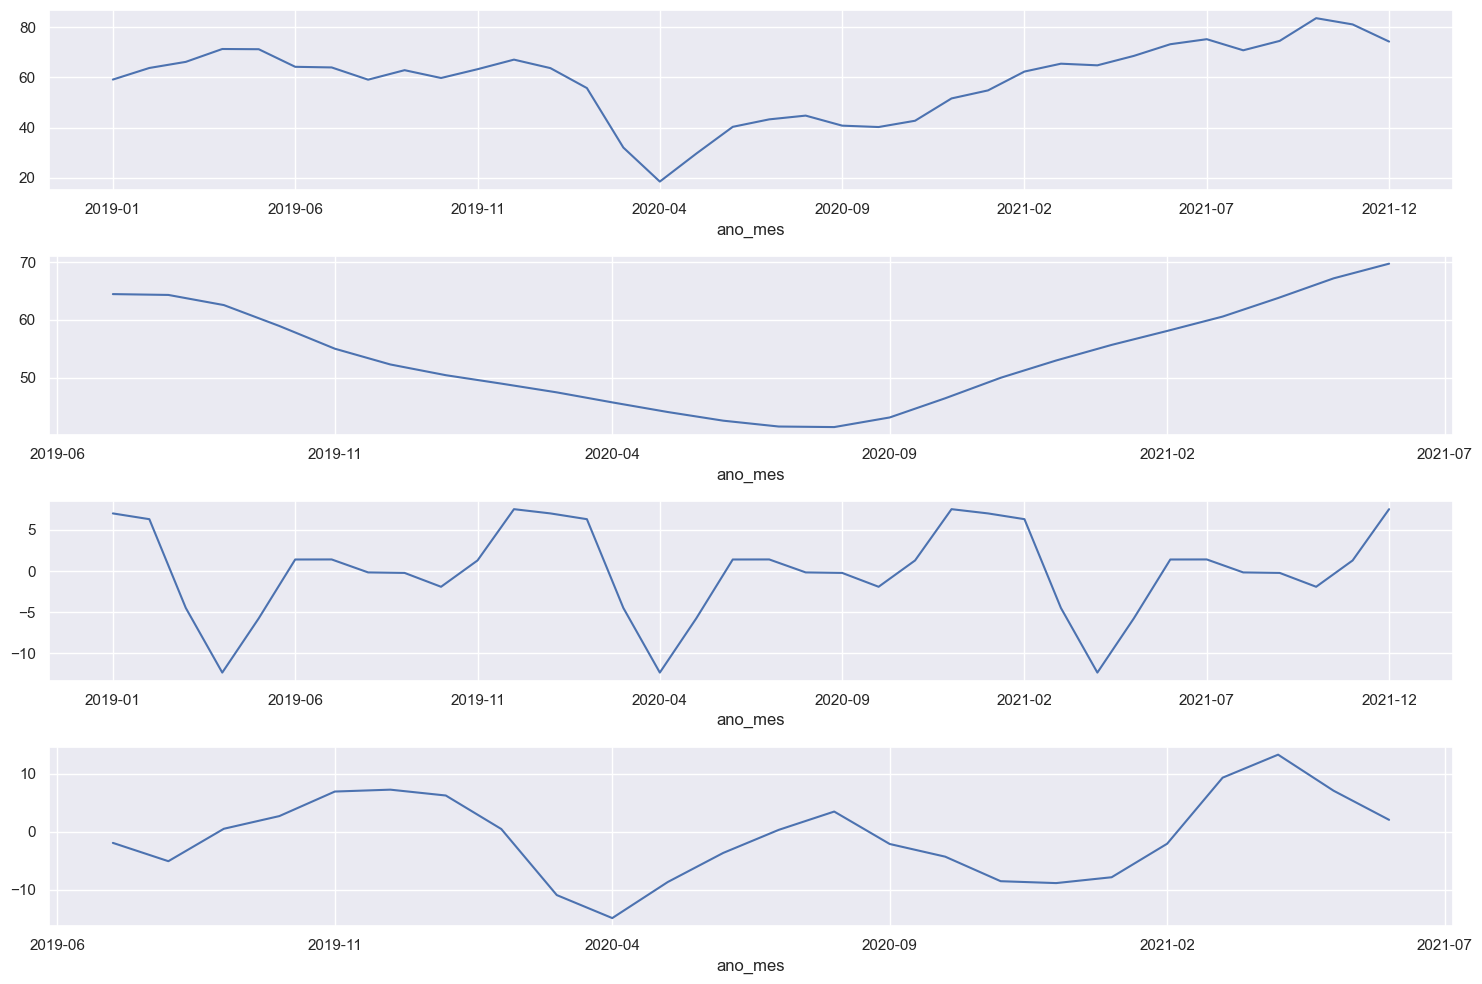

In [ ]:
decomposição_sazonal = seasonal_decompose(dados_analise_covid['media_preco'], model='additive', period=12)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize= (15,10))

decomposição_sazonal.observed.plot(ax=ax1)
decomposição_sazonal.trend.plot( ax=ax2)
decomposição_sazonal.seasonal.plot(ax=ax3) # sazonalidade recorrente
decomposição_sazonal.resid.plot(ax=ax4)

plt.tight_layout()

### **Conclusão:**

* *Impacto da COVID-19: Em todos os gráficos, especialmente no primeiro e segundo, a queda drástica em 2020 confirma o impacto da pandemia no mercado de petróleo. Com a desaceleração global, a demanda caiu abruptamente, causando uma queda histórica nos preços.*

* *Recuperação Gradual: A recuperação dos preços é visível após o pior momento da pandemia, com o aumento gradual da demanda conforme as economias reabriram e as viagens voltaram a ocorrer. No entanto, essa recuperação não foi rápida, pois o mercado de petróleo enfrentou desafios de oferta e demanda.*

* *Alta Volatilidade: O terceiro gráfico destaca uma alta volatilidade durante o período mais crítico da pandemia. As grandes flutuações de preço foram provocadas pela incerteza no mercado e pela incapacidade de prever o retorno da demanda, além de choques de oferta devido a decisões da OPEP e disputas entre grandes produtores.*

* *Tendências de Longo Prazo e Sazonalidade: Os gráficos de tendências mais amplas (segundo e quarto) mostram uma queda prolongada seguida de uma recuperação lenta. Isso aponta para um mercado que, embora fortemente impactado no curto prazo, tem uma capacidade de recuperação cíclica e sazonal conforme as condições macroeconômicas se estabilizam.*

Fontes: 
* Bureau of Labor Statistics — From the barrel to the pump: the impact of the COVID-19 pandemic on prices for petroleum products : Monthly Labor Review: U.S. Bureau of Labor Statistics - bls.gov
* EIA — OPEC+ agreement to reduce production contributes to global oil market rebalancing - U.S. Energy Information Administration (EIA) - eia.gov
* UNC Global Affairs — How the COVID-19 Pandemic Plunged Global Oil Prices - UNC Global Affairs - global.unc.edu

## **Análise Super Demanda da Ásia:**

### **Introdução**

Na Ásia, os principais países que impulsionam a super demanda por petróleo, especialmente nas últimas décadas, são a China e a Índia. Outros países, como Japão, Coreia do Sul, e em menor escala, países do Sudeste Asiático como Indonésia, Tailândia e Vietnã, também têm contribuído para o crescimento da demanda energética.

Os anos de maior impacto para essa demanda começaram por volta de 2000 e continuam até o presente, com períodos notáveis:

* Década de 2000: Com o rápido crescimento econômico e industrialização, China e Índia aumentaram significativamente sua demanda por petróleo. Esse período inclui o auge do crescimento econômico chinês, antes da crise financeira de 2008.

* Pós-crise de 2008 até 2015: Após a crise financeira, a demanda voltou a subir com o crescimento contínuo da economia chinesa e a industrialização da Índia.

* De 2015 em diante: A demanda permaneceu alta, com a Ásia se consolidando como uma das regiões mais significativas em consumo de petróleo devido ao crescimento populacional e à expansão das classes médias, especialmente na China e na Índia.

Esses países e períodos contribuíram para uma pressão crescente no mercado de petróleo global, levando à "super demanda" na Ásia.

Fonte: 
IEA: https://www.iea.org/reports/world-energy-outlook-2023/executive-summary  /// IBP: https://www.ibp.org.br/observatorio-do-setor/snapshots/projecao-da-demanda-global-de-petroleo-no-longo-prazo/

### *Análise da Super Demanda da Ásia na Produção do Petróleo:*

In [ ]:
paises_asiaticos = [
    'Afghanistan', 'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Bhutan', 'Brunei', 'Cambodia',
    'China', 'Georgia', 'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Japan', 'Jordan', 'Kazakhstan',
    'Kuwait', 'Kyrgyzstan', 'Laos', 'Lebanon', 'Malaysia', 'Maldives', 'Mongolia', 'Myanmar', 'Nepal',
    'North Korea', 'Oman', 'Pakistan', 'Philippines', 'Qatar', 'Saudi Arabia', 'Singapore', 'South Korea',
    'Sri Lanka', 'Syria', 'Taiwan', 'Tajikistan', 'Thailand', 'Turkmenistan', 'United Arab Emirates',
    'Uzbekistan', 'Vietnam', 'Yemen'
]

In [ ]:
# Filtrando o DataFrame para mostrar apenas os países asiáticos
df_asiaticos = producao[producao['country'].isin(paises_asiaticos)].reset_index(drop=True)

# Visualizando as primeiras linhas
print(df_asiaticos.head())

   year  barrels per year  country
0  2004               0.0  Armenia
1  2005               0.0  Armenia
2  2006               0.0  Armenia
3  2007               0.0  Armenia
4  2008               0.0  Armenia


In [ ]:
print(df_asiaticos['country'])

0      Armenia
1      Armenia
2      Armenia
3      Armenia
4      Armenia
        ...   
835      Yemen
836      Yemen
837      Yemen
838      Yemen
839      Yemen
Name: country, Length: 840, dtype: object


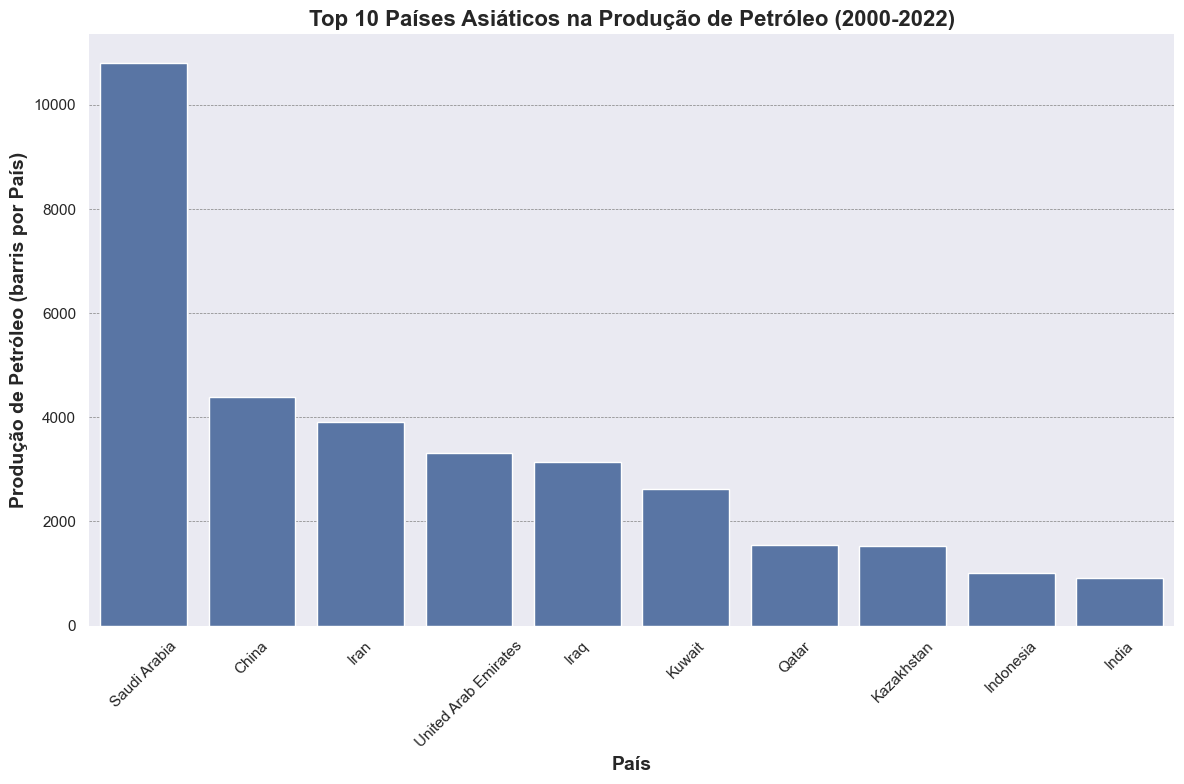

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Removendo as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

# Calculando a média de 'barrels per year' por país
df_asiaticos_avg = df_asiaticos.groupby('country')['barrels per year'].mean().reset_index()
df_asiaticos_avg = df_asiaticos_avg.sort_values(by='barrels per year', ascending=False).head(10)  # Ordenando pelo valor médio

# Plotando o gráfico de barras
ax = sns.barplot(data=df_asiaticos_avg, x='country', y='barrels per year')
plt.xticks(rotation=45)
plt.title('Top 10 Países Asiáticos na Produção de Petróleo (2000-2022)', fontsize=16, weight='bold')
plt.xlabel('País', fontsize=14, weight='bold')
plt.ylabel('Produção de Petróleo (barris por País)', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

*Os maiores produtores no periodo são: China, Iraque, Israel, Irã, Iraque, Arabia Saudita, Emirados Arabes.*

### *Análise do Impacto da Super Demanda da Ásia no Preço do Petróleo:*

In [ ]:
df_precos_year = dados_petroleo.query('ano >= 2000 and ano <= 2023')
df_precos_year = df_precos_year.groupby('ano')['preco'].mean().reset_index()
#A média é usada porque o preço do petróleo pode variar ao longo do ano, e você quer uma visão geral do preço médio durante o ano.
df_precos_year.head()

ano      preco
0  2000  28.660672
1  2001  24.475664
2  2002  25.187327
3  2003  28.861247
4  2004  38.102351

In [ ]:
df_producao_asia_year = df_asiaticos.groupby('year')['barrels per year'].sum().reset_index()
#A soma é usada porque a produção de petróleo é acumulada ao longo do ano, e você quer saber a quantidade total produzida.
df_producao_asia_year.head()

year  barrels per year
0  2000           31303.7
1  2001           31001.5
2  2002           30109.1
3  2003           32111.5
4  2004           34167.5

In [ ]:
df_merged_asia = pd.merge(df_precos_year, df_producao_asia_year, left_on='ano', right_on='year', how='inner')
df_merged_asia.head()

ano      preco  year  barrels per year
0  2000  28.660672  2000           31303.7
1  2001  24.475664  2001           31001.5
2  2002  25.187327  2002           30109.1
3  2003  28.861247  2003           32111.5
4  2004  38.102351  2004           34167.5

In [ ]:
correlacao = df_merged_asia['preco'].corr(df_merged_asia['barrels per year'])
print(f'Correlação entre preço do petróleo e produção de petróleo: {correlacao}')

Correlação entre preço do petróleo e produção de petróleo: 0.5405307573825064


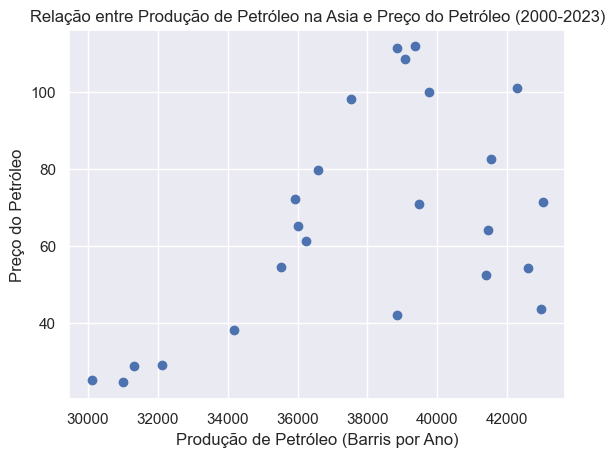

In [ ]:
plt.scatter(df_merged_asia['barrels per year'], df_merged_asia['preco'])
plt.title('Relação entre Produção de Petróleo na Asia e Preço do Petróleo (2000-2023)')
plt.xlabel('Produção de Petróleo (Barris por Ano)')
plt.ylabel('Preço do Petróleo')
plt.show()

*A correlação sugere que, ao longo do período analisado (2000-2023), houve uma tendência de aumento nos preços quando a produção aumentou, mas com variações consideráveis.*

### *Análise do Impacto da Super Demanda na Asia no Comportamento por Consumo:*

In [ ]:
paises_asiaticos_C = [
    'Afghanistan', 'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Bhutan', 'Brunei', 'Cambodia',
    'China', 'Georgia', 'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Japan', 'Jordan', 'Kazakhstan',
    'Kuwait', 'Kyrgyzstan', 'Laos', 'Lebanon', 'Malaysia', 'Maldives', 'Mongolia', 'Myanmar', 'Nepal',
    'North Korea', 'Oman', 'Pakistan', 'Philippines', 'Qatar', 'Saudi Arabia', 'Singapore', 'South Korea',
    'Sri Lanka', 'Syria', 'Taiwan', 'Tajikistan', 'Thailand', 'Turkmenistan', 'United Arab Emirates',
    'Uzbekistan', 'Vietnam', 'Yemen'
]



In [ ]:
# Filtrando o DataFrame para mostrar apenas os países asiáticos
consumo['pais'] = consumo['pais'].str.strip()
df_asiaticos_consumo = consumo[consumo['pais'].isin(paises_asiaticos_C)].reset_index(drop=True)

# Visualizando as primeiras linhas
print(df_asiaticos_consumo.head())

    ano   QBTU          pais    barrels
0  2000  0.297    Uzbekistan  51.206897
1  2000    NaN        Taiwan        NaN
2  2000  0.205         Yemen  35.344828
3  2000  0.345       Vietnam  59.482759
4  2000  0.186  Turkmenistan  32.068966


In [ ]:
df_asiaticos_consumo_pais = df_asiaticos_consumo.groupby('pais')['barrels'].sum().reset_index()
#A soma é usada porque a produção de petróleo é acumulada ao longo do ano, e você quer saber a quantidade total produzida.
df_asiaticos_consumo_pais.head()

pais     barrels
0  Afghanistan  181.896552
1      Armenia   71.379310
2   Azerbaijan  801.379310
3      Bahrain  451.034483
4   Bangladesh  849.655172

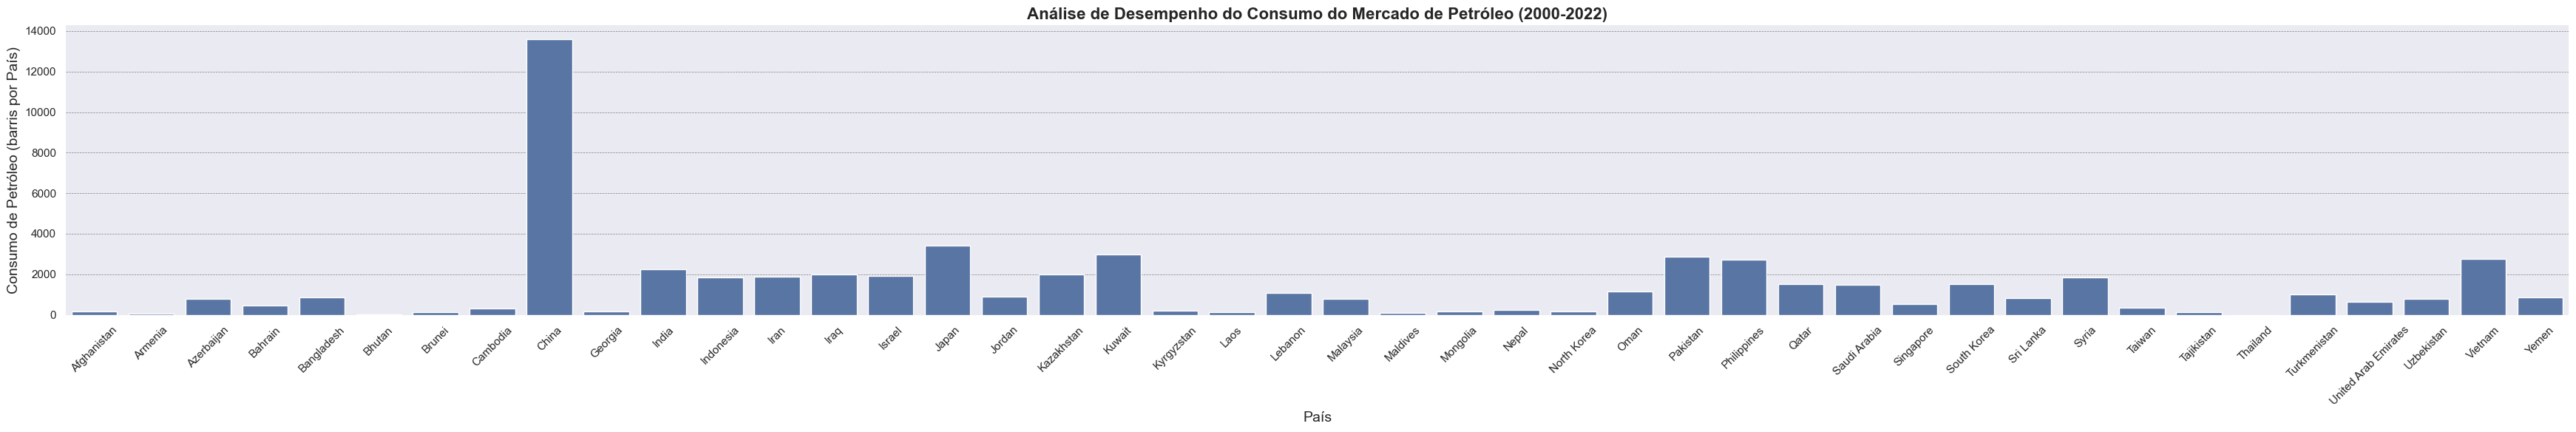

In [ ]:
fig, ax = plt.subplots(figsize=(35, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Removendo as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

# Calculando a média de 'barrels per year' por país
#df_asiaticos_avg = consumo_medio_por_pais.groupby('country')['barrels per year'].mean().reset_index()

# Plotando o gráfico de barras
ax = sns.barplot(data=df_asiaticos_consumo_pais, x='pais', y='barrels')
plt.xticks(rotation=45)
plt.title('Análise de Desempenho do Consumo do Mercado de Petróleo (2000-2022)', fontsize=16, weight='bold')
plt.xlabel('País', fontsize=14)
plt.ylabel('Consumo de Petróleo (barris por País)', fontsize=14)
plt.tight_layout()
plt.show()

* A China, maior destaque no gráfico, é o principal motor da super demanda asiática. Seu consumo disparado reflete:
A transformação em "fábrica do mundo", Elevada dependência de petróleo para transporte e geração de energia, Expansão de infraestrutura e obras massivas.

**Outros países asiáticos com alta demanda:**

* Índia: Altamente dependente de importações de petróleo para transporte e industrialização.
* Japão e Coreia do Sul: Economias avançadas e industrializadas, altamente dependentes de petróleo apesar de avanços em energias renováveis.
* Sudeste Asiático (Filipinas, Vietnã, Tailândia): Crescimento econômico e industrial impulsionaram o consumo.

**Menor consumo em países menores:**

Nações como Butão e Laos têm economias e populações menores, com baixa industrialização, refletindo baixo consumo.

In [ ]:
df_asiaticos_consumo_ano = df_asiaticos_consumo.groupby('ano')['barrels'].sum().reset_index()
#A soma é usada porque a produção de petróleo é acumulada ao longo do ano, e você quer saber a quantidade total produzida.
df_asiaticos_consumo_ano.head()

ano      barrels
0  2000  3850.689655
1  2001  2762.068966
2  2002  2512.586207
3  2003  2432.413793
4  2004  1281.034483

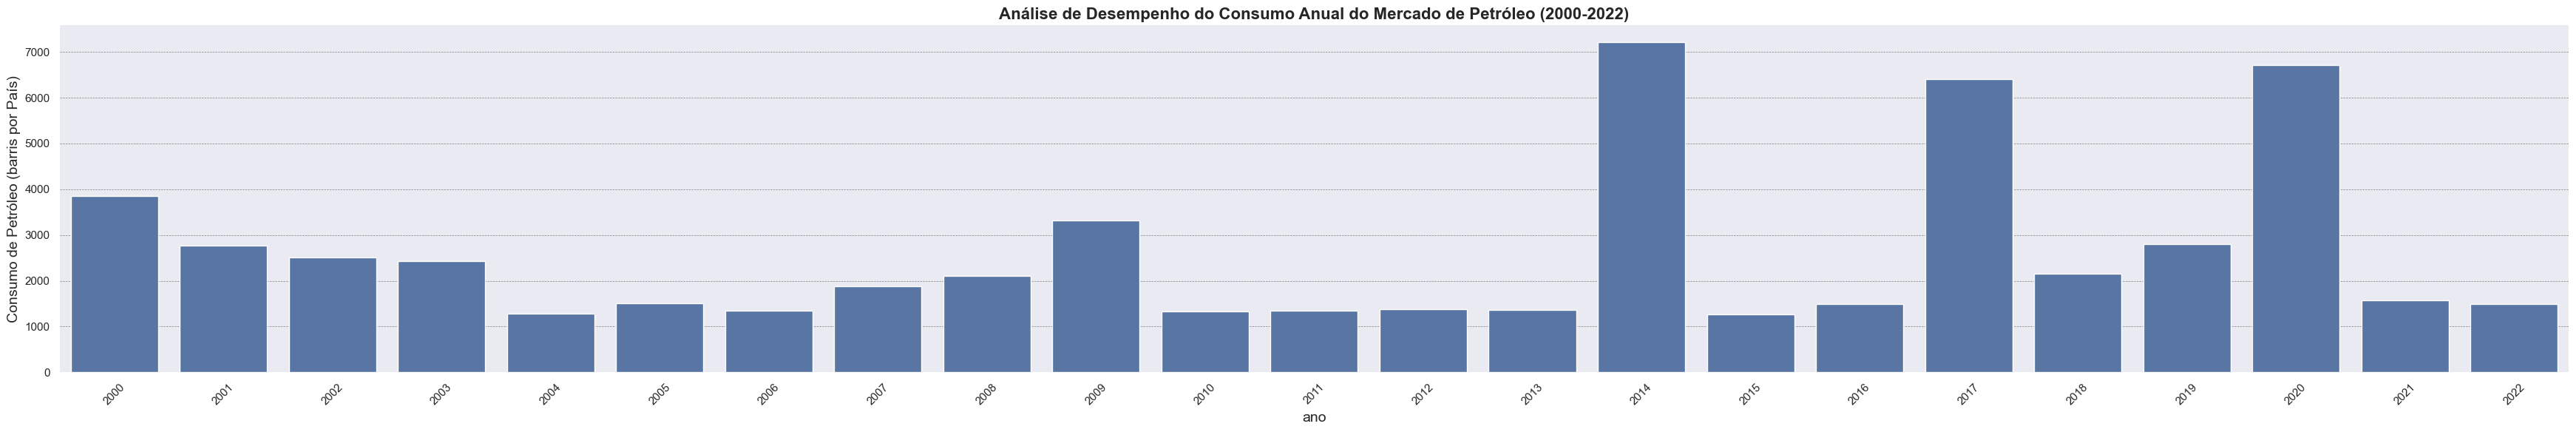

In [ ]:
fig, ax = plt.subplots(figsize=(35, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Removendo as bordas
for spine in ax.spines.values():
    spine.set_visible(False)

# Calculando a média de 'barrels per year' por país
#df_asiaticos_avg = consumo_medio_por_pais.groupby('country')['barrels per year'].mean().reset_index()

# Plotando o gráfico de barras
ax = sns.barplot(data=df_asiaticos_consumo_ano, x='ano', y='barrels')
plt.xticks(rotation=45)
plt.title('Análise de Desempenho do Consumo Anual do Mercado de Petróleo (2000-2022)', fontsize=16, weight='bold')
plt.xlabel('ano', fontsize=14)
plt.ylabel('Consumo de Petróleo (barris por País)', fontsize=14)
plt.tight_layout()
plt.show()

A super demanda da Ásia está diretamente ligada aos picos no consumo observados em anos específicos, como 2000, 2008, 2014 e 2020.
Motivos para alta demanda:
* **Crescimento econômico acelerado:** Países como China, Índia e outras economias emergentes da Ásia apresentaram crescimento industrial robusto nesse período.
* **Urbanização:** A rápida urbanização na Ásia aumentou a necessidade de transporte, construção e energia, resultando em um maior consumo de petróleo.


A queda no consumo recente (2021 e 2022) pode ser atribuída à desaceleração econômica global pós-pandemia, mas a base de demanda asiática permanece alta.

In [ ]:
maiores_consumos = df_asiaticos_consumo_ano[df_asiaticos_consumo_ano['barrels'] == df_asiaticos_consumo_ano['barrels'].max()]
print(f'Anos de maior consumo de petróleo na Ásia: {maiores_consumos["ano"].values}')

Anos de maior consumo de petróleo na Ásia: [2014]


*Com base nas análises do Portal do IBP, a tendência de pico de consumo entre 2000 e 2020 coincide com o aumento econômico da Ásia, especialmente em países como China, Índia e outros em crescimento. Isso inclui uma forte recuperação pós-crise financeira de 2008 e um aumento consistente de consumo até 2020, impulsionado principalmente pela industrialização e aumento da demanda de energia​ IBP.*

*Os gráficos ilustram como a Ásia, especialmente a China, moldou o consumo global de petróleo nas últimas décadas, conduzida pelo crescimento econômico, urbanização e industrialização massiva. A super demanda da região foi o principal motor de aumento do consumo global, com implicações econômicas e ambientais significativas.*

*Portanto, os anos como 2000, 2009, 2014, 2017 e 2020 está alinhada com os períodos de maior atividade econômica e aumento de demanda, especialmente nas principais economias da Ásia.* 

### *Correlação entre Produção e Consumo de Petróleo:*

In [ ]:
df_merged_corr = pd.merge(df_producao_asia_year, df_asiaticos_consumo_ano, left_on='year', right_on='ano', how='inner')

In [ ]:
df_producao_asia_year.head()

year  barrels per year
0  2000           31303.7
1  2001           31001.5
2  2002           30109.1
3  2003           32111.5
4  2004           34167.5

Correlação entre a produção e o consumo de petróleo: 0.07533007160597455


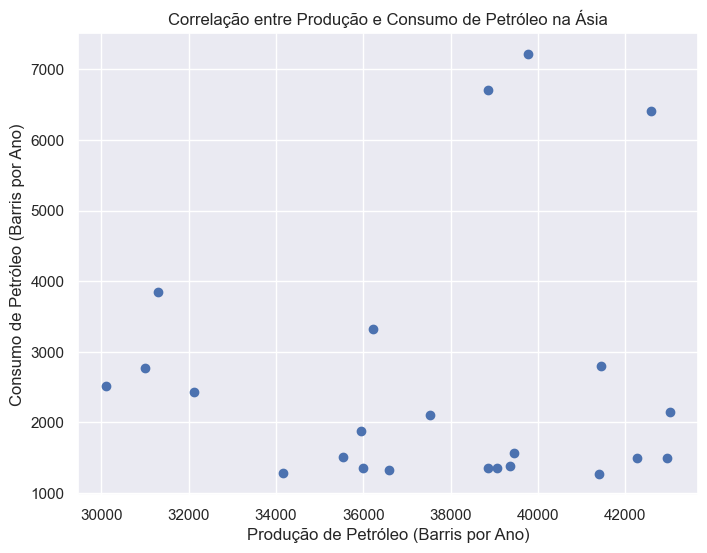

In [ ]:

correlacao = df_merged_corr['barrels per year'].corr(df_merged_corr['barrels'])
print(f'Correlação entre a produção e o consumo de petróleo: {correlacao}')

# Plotando a correlação
plt.figure(figsize=(8,6))
plt.scatter(df_merged_corr['barrels per year'], df_merged_corr['barrels'])
plt.title('Correlação entre Produção e Consumo de Petróleo na Ásia')
plt.xlabel('Produção de Petróleo (Barris por Ano)')
plt.ylabel('Consumo de Petróleo (Barris por Ano)')
plt.grid(True)
plt.show()

*A correlação de 0.075 entre a produção e o consumo de petróleo indica uma relação muito fraca entre essas duas variáveis. Isso significa que, com base nos dados analisados, a variação na produção de petróleo não tem um impacto direto ou consistente no consumo de petróleo, ou vice-versa. A correlação próxima de zero sugere que outros fatores podem ser mais influentes no comportamento dessas variáveis, como políticas econômicas, mudanças no preço global do petróleo, ou outras dinâmicas de mercado.*

### *Análise de PIB, Taxa de Juros e Preço do Petróleo:*

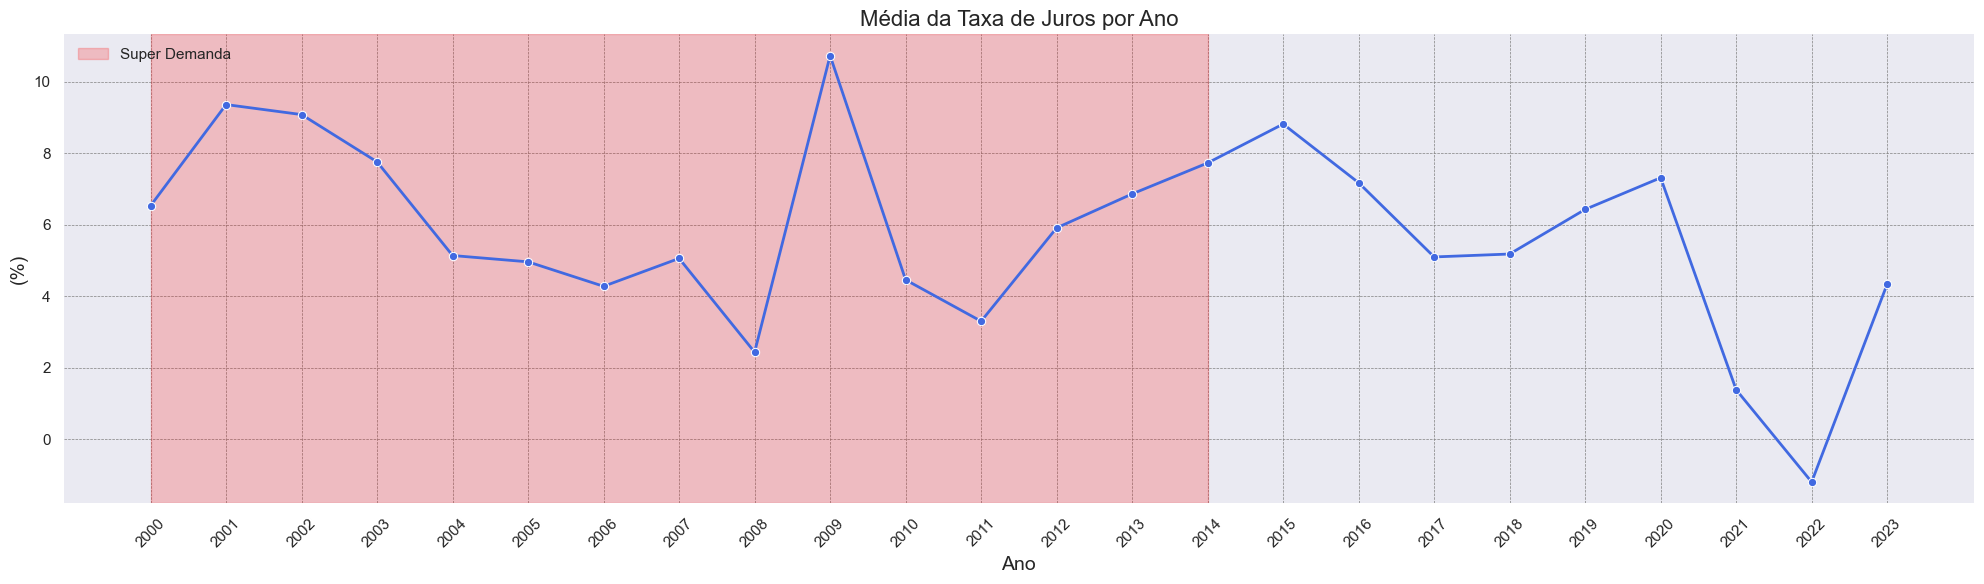

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.set_style("darkgrid")
plt.grid(color='gray', linestyle='--', linewidth=0.5)

for spine in ax.spines.values():
    spine.set_visible(False)

# Plotando as linhas
sns.lineplot(data=media_por_ano_r, x='Ano', y='m_juros', marker='o', color='royalblue', linewidth=2, ax=ax)

plt.xticks(rotation=45)
ax.axvspan('2000', '2014', color='red', alpha=0.2, label='Super Demanda')

plt.title('Média da Taxa de Juros por Ano', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('(%)', fontsize=14)
plt.legend(loc='upper left', frameon=False)
plt.tight_layout()

plt.show()

* *A alta de 2000-2001 pode refletir uma tentativa de controlar a inflação após o crescimento acelerado nas economias asiáticas.*
* *A pequena alta de 2006-2007 pode ser associada à preparação para a crise financeira de 2008, quando o crescimento econômico da Ásia estava alcançando seu pico, com a China e outras economias emergentes puxando o crescimento global.*
* *A queda de 2007-2008 é um reflexo das medidas adotadas para enfrentar a desaceleração econômica global (com a crise de 2008) e as pressões sobre a demanda.*
* *A alta drástica de 2008-2009 pode ser uma resposta a políticas monetárias adotadas para combater a crise e estabilizar as economias asiáticas. A alta nas taxas de juros também pode refletir esforços para controlar o impacto da recessão.*
* *O declínio de 2009-2011 pode ser visto como uma tentativa de recuperação econômica em um cenário de baixo crescimento pós-crise.*
* *O aumento gradual de 2011-2014 pode estar ligado ao crescimento contínuo da demanda global, especialmente devido ao fortalecimento da China e a recuperação após a crise financeira.*

In [ ]:
media_por_ano_r.reset_index(inplace=True)
media_por_ano_r['Ano'] = pd.to_numeric(media_por_ano_r['Ano'], errors='coerce')
print(media_por_ano_r['Ano'].dtype)

int64


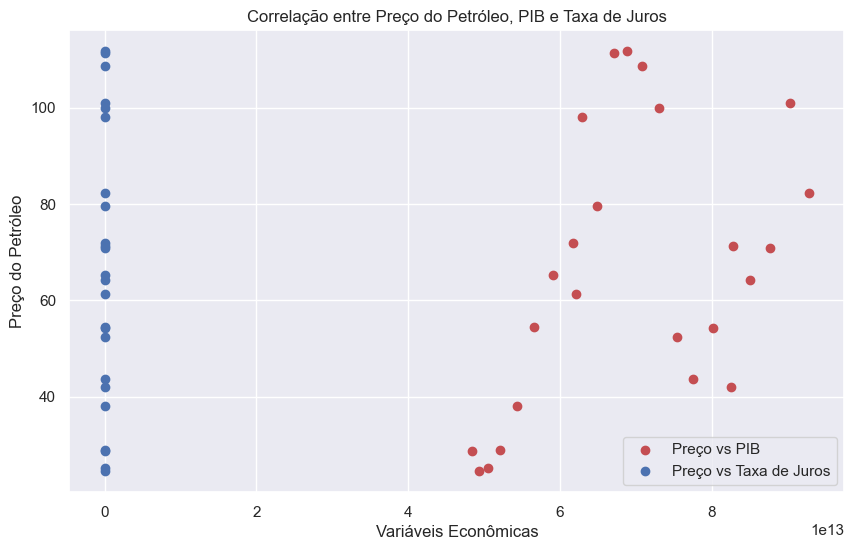

In [ ]:
# Mesclar os dados de PIB e Taxa de Juros com os dados de preços de petróleo
df_combined = pd.merge(df_precos_year, pib_mundial_T, left_on='ano', right_on='ano', how='inner')
df_combined = pd.merge(df_combined, media_por_ano_r, left_on='ano', right_on='Ano', how='inner')

# Plotando as correlações
plt.figure(figsize=(10,6))
plt.scatter(df_combined['pib_anual'], df_combined['preco'], color='r', label='Preço vs PIB')
plt.scatter(df_combined['m_juros'], df_combined['preco'], color='b', label='Preço vs Taxa de Juros')
plt.title('Correlação entre Preço do Petróleo, PIB e Taxa de Juros')
plt.xlabel('Variáveis Econômicas')
plt.ylabel('Preço do Petróleo')
plt.legend()
plt.grid(True)
plt.show()

*Aparentemente, não há uma correlação clara e forte entre a produção e o consumo de petróleo na Ásia. Alguns países apresentam consumo elevado apesar de baixa produção, enquanto outros têm alta produção, mas consumo moderado.*

*Países como a China e a Índia (prováveis outliers na parte superior do gráfico) destacam-se com consumo muito maior do que a produção, indicando dependência significativa de importações de petróleo para atender à demanda interna.*

### *Análise de Tendências Econômicas (PIB, Taxa de Juros e Preço de Petróleo):*

In [ ]:
import statsmodels.api as sm

In [ ]:
# Definindo a variável dependente (preço do petróleo) e as independentes (PIB, Taxa de Juros)
X = df_combined[['pib_anual', 'm_juros']]
X = sm.add_constant(X)  # Adicionando uma constante (intercepto)
y = df_combined['preco']

# Ajustando o modelo de regressão
model = sm.OLS(y, X).fit()

# Resumo do modelo
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  preco   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     5.086
Date:                qua, 27 nov 2024   Prob (F-statistic):             0.0158
Time:                        17:58:20   Log-Likelihood:                -109.02
No. Observations:                  24   AIC:                             224.0
Df Residuals:                      21   BIC:                             227.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.6220     35.170      1.468      0.1

* *R-quadrado (0.326) e R-quadrado ajustado (0.262) indicam que o modelo explica uma parte limitada da variabilidade do preço do petróleo (aproximadamente 32.6% da variação).*
* *O coeficiente para o PIB anual é muito pequeno (5.634e-13) e não significativo (p = 0.181), indicando que o PIB não tem impacto relevante sobre o preço do petróleo neste modelo.*
* *A taxa de juros tem um impacto negativo no preço do petróleo (coef. = -4.2206), com p-valor de 0.055, sugerindo que há uma relação marginalmente significativa entre as duas variáveis. Taxas de juros mais altas provavelmente reduzem a demanda por petróleo, como esperado economicamente.*
* *O número de condição elevado (4.99e+14) sugere multicolinearidade entre as variáveis independentes, o que pode prejudicar a precisão das estimativas.*


**Em resumo: O modelo é marginalmente significativo, mas apresenta limitações devido à multicolinearidade e à fraca explicação do preço do petróleo, especialmente em relação ao PIB.**

### **Conclusão:**

* *Super demanda: A análise gráfica da produção e consumo de petróleo na Ásia sugere que há uma alta demanda que ultrapassa a produção local, indicando que a Ásia provavelmente depende de importações para atender ao consumo.*
* *Impacto nos Preços Globais: Essa super demanda pode exercer pressão nos preços globais do petróleo, uma vez que um grande consumidor de petróleo como a Ásia depende de suprimentos externos.*
* *Limitações do Modelo: A regressão OLS mostra que PIB e taxa de juros capturam parte da variação no preço do petróleo, mas fatores regionais, como a demanda na Ásia, podem desempenhar um papel crucial. O coeficiente não significativo do PIB pode indicar que apenas o PIB global ou regional não explica bem o preço do petróleo, sendo necessária uma análise mais granular da demanda asiática.*
* *Influência da Taxa de Juros: A taxa de juros afeta o preço do petróleo, mas a super demanda da Ásia pode mitigar esse efeito. Mesmo com taxas de juros mais altas, que tipicamente reduziriam a demanda, a Ásia pode continuar a demandar petróleo em níveis elevados.*

## Criação do dashboard


## MVP no Streamlit